In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from math import *
import itertools
import os.path
import ast
%matplotlib inline

# Original Experiment.  IOIs: 10-25, standard tones: 5-12, 2000 generations.

# 1) Psychometric Analysis.

## 1-1) Generate Psychometric Curves. Calculate PSE, JND, CE, etc.

In [2]:
# readResponses takes 1) the address in which test_ files are stored, 2) a list of replicates, and 
# 3) generation. reps and generation are included in tests_ filenames.
# reads longer/shorter responses of Markov Brains from tests_ files 
# returns a pandas dataframe containing trial properties and responses.
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from math import *
import itertools
import os.path
import sys

def readResponses(ad,reps,gen):
    repsInd=[reps.index(rep)+1 for rep in reps]
    
    fn=ad+"tests_"+str(reps[0])+"_"+str(gen)+".csv"
    if (os.path.exists(fn)):
        df=pd.read_csv(fn)
    else:
        print (fn,"does not exist")
        return
    df["pattern"]=list(zip(df.ioi,df.tone))
    patterns=df.pattern.unique()
    tup=list()
    for pat in patterns:
        ioi,tone=pat
        for delay in range(tone-ioi+1,ioi-tone):
            for rep in repsInd:
                tup.append((pat,delay,rep))

    levels=pd.MultiIndex.from_tuples(tup,names=['pattern','delay','rep'])
    res=pd.DataFrame(index=levels,columns=['obTones','response'])
    for ind,rep in enumerate(reps):
        print(rep, end=' ')
        sys.stdout.flush()
        fn=ad+"tests_"+str(rep)+"_"+str(gen)+".csv"
        
        if (not os.path.exists(fn)):
            print (fn+" does not exist")
            continue
        df=pd.read_csv(fn)
        #df['obAction']=1-df.obAction
        for pat in patterns:
            ioi,tone=pat
            dfp=df[(df.ioi==ioi) & (df.tone==tone)].reset_index(drop=True)
            for delay in range(tone-ioi+1,ioi-tone):#dfp.obDelay.unique():
                dfd=dfp[dfp.obDelay==delay].reset_index(drop=True)
                responses=np.mean([dfd[dfd.obPos==obPos].obAction.tolist() for obPos in [4,5,6,7]],axis=0)
                obTones=np.array(dfd[dfd.obPos==4].obTone.tolist())
                
                res.loc[pat,delay,ind+1]=[obTones,responses]

    return res.sort_index()

# sigmoid function for fitting psychometric curves
def sigmoid(x,k,x0):
    return 1.0/(1+np.exp(-k*(x-x0)))

# psyCurveRep takes the response dataframe filled in readResponses
# fits sigmoid psychometric curves to each trial for each Markov Brain
# returns a pandas dataframe containing psychometric values: 
# PSE: point of subjective equality, PseStd: standard deviation of PSE, JND: just noticeable difference
# JndStd: standard deviation of JND, PseJndCov: the covariance of fitting for PSE and JND, 
# relJND: relative JND=JND/std tone, DDF: duration distortion factor=PSE/POE, CE: constant error=PSE-std tone
def psyCurveRep(res):
    levels=res.index.droplevel(level=2).drop_duplicates()
    psyRep=pd.DataFrame(index=levels,columns=['PSE','PseStd','JND','JndStd','PseJndCov','relJND','DDF','CE'],dtype=float)
    for (pat,delay) in psyRep.index:
        ioi,tone=pat
        if (len(res.loc[pat].loc[delay].obTones.tolist()[0])<2):
            continue
        obTones=list(res.loc[pat].loc[delay,1].obTones)#[0]
        responses=list(np.mean(res.loc[pat].loc[delay].response.tolist(),axis=0))
        rSigmas=list(stats.sem(res.loc[pat].loc[delay].response.tolist(),axis=0))
        tre=list(zip(obTones,responses,rSigmas))
        #tre=list(filter(lambda arg: arg[2] != 0, tre))

        # remove zeros from the beginning
        for init, (ob,resp,sig) in enumerate(tre):
            if resp!=0:
                break
        # remove ones from the end
        for fin, (ob,resp,sig) in enumerate(tre[::-1]):
            if resp!=1:
                break

        fin=len(tre)-fin
        tre=tre[init:fin]

        obTones,responses,rSigmas=[list(t) for t in zip(*tre)]

        # correct ones and zeros in the middle
        errMin = np.min(list(filter(lambda el: el>0, rSigmas)))
        for ind, (ob,resp,sig) in enumerate(tre):
            if (resp==0):
                responses[ind]=0.01
                rSigmas[ind]=errMin
                print ("response correction in",pat,delay,"at",ob,"\tnew response, sigma:", 0.01, errMin)
            if (resp==1):
                responses[ind]=0.99
                rSigmas[ind]=errMin
                print ("response correction in",pat,delay,"at",ob,"\tnew response, sigma:", 0.99, errMin)

        if (len(tre)<3):
            print ("less than 3 datapoints for",pat,delay)
            continue

        if (responses.count(0)!=0 or responses.count(1)!=0):
            print ("responses contain 0 or 1")

        try:
            x0_0=obTones[min(range(len(responses)), key=lambda i: abs(responses[i]-0.5))]
            popt,pcov=curve_fit(sigmoid,obTones,responses,sigma=rSigmas,absolute_sigma=True,p0=(1,x0_0),maxfev=10000)
            k,x0=popt
            kStd,pseStd=np.sqrt(np.diag(pcov))
            pseJndCov=pcov[0,1]
            jnd=log(3.0)/k
            jndStd=log(3.0)/(k*k)*kStd
            relJND=jnd/tone
            ddf=tone/x0
            ce=x0-tone
            psyRep.loc[pat,delay]=[x0,pseStd,jnd,jndStd,pseJndCov,relJND,ddf,ce]
        except RuntimeError:
            print (pat,delay,"curve_fit failed")
            continue
    return psyRep

ad,fnRes,fnPsy,gen=sys.argv[1],sys.argv[2],sys.argv[3],sys.argv[4]
reps=range(int(sys.argv[5]), int(sys.argv[6])+1)

print ("Reading responses from tests files ...")
res=readResponses(ad,reps,gen)
print ("\nWriting responses to",fnRes)
res.to_csv(fnRes)

print ("Generating psychometric curves from responses ...")
psy=psyCurveRep(res.dropna())
print ("\nWriting psychometric data to",fnPsy)
psy.to_csv(fnPsy)



## Formula(1): JND=ln(3)/k

### Sigmoid function: $S(x)=\frac{1}{1+e^{-k(x-x_0)}}$ 
### $S(x)=\frac{1}{1+e^{-k(x-x_0)}}=0.25 \: \rightarrow -k(x-x_0)=ln(3) \: \rightarrow \: 
x_{0.25}=x_0+\frac{1}{k} ln(\frac{1}{3})$
### $S(x)=\frac{1}{1+e^{-k(x-x_0)}}=0.75 \: \rightarrow -k(x-x_0)=ln(\frac{1}{3}) \: \rightarrow \: 
x_{0.75}=x_0+\frac{1}{k} ln(3)$
### $JND=\frac{x_{0.75}-x_{0.25}}{2}=\frac{1}{2k}(ln(3)-ln(\frac{1}{3}))=\frac{ln(3)}{k}$

## Formula(2): $SD_{JND} = \frac{ln(3)}{k^2 SD_k}$

### $JND = \frac{ln(3)}{k}$
### $\delta JND = |\frac{\partial JND}{\partial k}| \delta k = \frac{ln(3)}{k^2} \delta k$

In [6]:
def makeObs(row):
    if not ("[" in row.obTones):
        return []
    obs=row.obTones.replace("[","") 
    obs=obs.replace("]","")
    return [int(ob) for ob in obs.split()]

def makeRes(row):
    if not ("[" in row.response):
        return []
    resp=row.response.replace("[","")
    resp=resp.replace("]","")
    return [float(r) for r in resp.split()]

def readResponseFile(fn):
    res=pd.read_csv(fn,converters={"pattern":ast.literal_eval})
    #res=res[res28.delay==0]
    #res.drop('delay',axis=1,inplace=True)

    res['obTones']=res.apply(lambda row: makeObs(row),axis=1)
    res['response']=res.apply(lambda row: makeRes(row),axis=1)
    res.set_index(['pattern','delay','rep'],inplace=True)
    return res

In [3]:
ad="longer-shorter/34-setup-same-sensor-10k/"
res34_2000 = readResponseFile(ad+"res-2000.csv")
psy34_2000 = pd.read_csv(ad+"psy-"+str(2000)+".csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy34_2000[psy34_2000.index.get_level_values('delay')==0]

PSE    PseStd       JND    JndStd  PseJndCov    relJND  \
pattern  delay                                                                 
(10, 5)  0       4.890689  0.072925  0.334829  0.050351   0.002943  0.066966   
(11, 5)  0       5.091898  0.067926  0.292071  0.039224  -0.010620  0.058414   
(12, 6)  0       5.923420  0.083209  0.458498  0.051004   0.004237  0.076416   
(13, 6)  0       6.265012  0.072003  0.339126  0.049691  -0.003573  0.056521   
(14, 7)  0       6.795629  0.079880  0.404495  0.049889   0.004798  0.057785   
(15, 7)  0       7.049450  0.071507  0.415548  0.040519   0.002856  0.059364   
(16, 8)  0       7.757535  0.067467  0.379564  0.037431  -0.002297  0.047445   
(17, 8)  0       8.051133  0.064124  0.402181  0.038499   0.000029  0.050273   
(18, 9)  0       8.582521  0.072028  0.371506  0.048730   0.004444  0.041278   
(19, 9)  0       9.011994  0.080534  0.469423  0.047568  -0.003078  0.052158   
(20, 10) 0       9.760310  0.078166  0.403185  0.051632  -0.005151  0.040318   
(21, 10) 0      10.447969  0.093402  0.442364  0.044550  -0.009464  0.044236   
(22, 11) 0      11.192370  0.108812  0.655495  0.084968  -0.003876  0.059590   
(23, 11) 0      11.992977  0.115594  0.756483  0.075032   0.000227  0.068771   
(24, 12) 0      13.036475  0.119368  0.829176  0.071024   0.001621  0.069098   
(25, 12) 0      13.819445  0.128050  0.899939  0.078525   0.002070  0.074995   

                     DDF        CE  
pattern  delay                      
(10, 5)  0      1.022351 -0.109311  
(11, 5)  0      0.981952  0.091898  
(12, 6)  0      1.012928 -0.076580  
(13, 6)  0      0.957700  0.265012  
(14, 7)  0      1.030074 -0.204371  
(15, 7)  0      0.992985  0.049450  
(16, 8)  0      1.031255 -0.242465  
(17, 8)  0      0.993649  0.051133  
(18, 9)  0      1.048643 -0.417479  
(19, 9)  0      0.998669  0.011994  
(20, 10) 0      1.024558 -0.239690  
(21, 10) 0      0.957124  0.447969  
(22, 11) 0      0.982812  0.192370  
(23, 11) 0      0.917203  0.992977  
(24, 12) 0      0.920494  1.036475  
(25, 12) 0      0.868342  1.819445

In [5]:
psy34_2000[psy34_2000.index.get_level_values('delay')==0].describe()

PSE     PseStd        JND     JndStd  PseJndCov     relJND  \
count  16.000000  16.000000  16.000000  16.000000  16.000000  16.000000   
mean    8.729302   0.085937   0.490868   0.053665  -0.000927   0.057727   
std     2.770974   0.020640   0.187176   0.015116   0.004776   0.011373   
min     4.890689   0.064124   0.292071   0.037431  -0.010620   0.040318   
25%     6.662975   0.071879   0.377549   0.043542  -0.003649   0.049566   
50%     8.316827   0.079023   0.410022   0.049790   0.000128   0.058100   
75%    10.634069   0.097255   0.515941   0.056480   0.002878   0.067417   
max    13.819445   0.128050   0.899939   0.084968   0.004798   0.076416   

             DDF         CE  
count  16.000000  16.000000  
mean    0.983796   0.229302  
std     0.049103   0.588845  
min     0.868342  -0.417479  
25%     0.957556  -0.133076  
50%     0.993317   0.050291  
75%     1.022903   0.310751  
max     1.048643   1.819445

In [6]:
print (psy34_2000[psy34_2000.index.get_level_values('delay')==0].reset_index().drop(['delay','PseJndCov','DDF'],axis=1).round(2).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} &   pattern &    PSE &  PseStd &   JND &  JndStd &  relJND &    CE \\
\midrule
0  &   (10, 5) &   4.89 &    0.07 &  0.33 &    0.05 &    0.07 & -0.11 \\
1  &   (11, 5) &   5.09 &    0.07 &  0.29 &    0.04 &    0.06 &  0.09 \\
2  &   (12, 6) &   5.92 &    0.08 &  0.46 &    0.05 &    0.08 & -0.08 \\
3  &   (13, 6) &   6.27 &    0.07 &  0.34 &    0.05 &    0.06 &  0.27 \\
4  &   (14, 7) &   6.80 &    0.08 &  0.40 &    0.05 &    0.06 & -0.20 \\
5  &   (15, 7) &   7.05 &    0.07 &  0.42 &    0.04 &    0.06 &  0.05 \\
6  &   (16, 8) &   7.76 &    0.07 &  0.38 &    0.04 &    0.05 & -0.24 \\
7  &   (17, 8) &   8.05 &    0.06 &  0.40 &    0.04 &    0.05 &  0.05 \\
8  &   (18, 9) &   8.58 &    0.07 &  0.37 &    0.05 &    0.04 & -0.42 \\
9  &   (19, 9) &   9.01 &    0.08 &  0.47 &    0.05 &    0.05 &  0.01 \\
10 &  (20, 10) &   9.76 &    0.08 &  0.40 &    0.05 &    0.04 & -0.24 \\
11 &  (21, 10) &  10.45 &    0.09 &  0.44 &    0.04 &    0.04 &  0.45 \\
12 &  (

## 1-2) Psychometric Curve. Weber's Law

In [37]:
def sigmoid(x,k,x0):
    return 1.0/(1+np.exp(-k*(x-x0)))

def plotRespWeber(res,psy,delay=0):
    res=res[res.index.get_level_values('delay')==delay]
    #res.index=res.index.droplevel('delay')
    
    psy=psy[psy.index.get_level_values('delay')==delay]
    #psy.index=psy.index.droplevel('delay')
    plt.figure(figsize=(8,4.5))
    alphas = list(np.arange(0.2,0.7,0.5/10))+list(np.arange(0.2,0.7,0.5/6))
    alphas = alphas[::-1]
    for ind,pat in enumerate(res.index.get_level_values('pattern').unique()[::-1]):
        #print pat, ind, alphas[ind]
        #print pat
        ioi,tone=pat
        c='k'#'r' if (ioi>=23) else 'k'
        m='o'#'^' if (ioi>=23) else 'o'
        obs=res.loc[pat].loc[delay,1].obTones
        normObs=[2*(ob-tone)/float(ioi) for ob in obs]#max(obs)
        resp=np.mean(res.loc[pat].loc[delay].response.tolist(),axis=0)
        respErr=stats.sem(res.loc[pat].loc[delay].response.tolist(),axis=0)
        
        #plt.scatter(normObs,resp,s=60,color=c,alpha=0.6,marker=m)
        plt.errorbar(normObs,resp,markersize=9,color=c,alpha=0.5,marker=m,fmt=m,markeredgecolor=c)#yerr=respErr
        x0=(psy.loc[pat].loc[delay].PSE - tone)/(tone)#max(obs)
        k=(log(3.0)/psy.loc[pat].loc[delay].JND)*(tone)#max(obs)
        
        dt=0.01
        ts=np.arange(normObs[0],normObs[-1]+dt,dt)
        plt.plot(ts,[sigmoid(ob,k,x0) for ob in ts],linewidth=1.5,
                 color='0.3',alpha=0.3,zorder=-1,linestyle='-')#,label="std tone="+str(tone))#,dashes=(10,8))
        #plt.show()

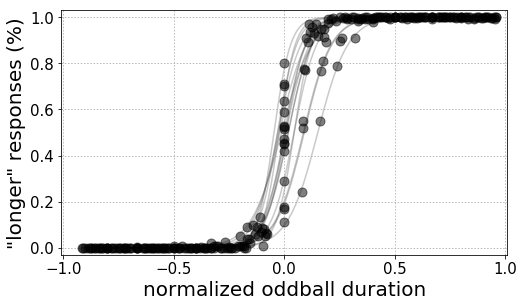

In [38]:
import matplotlib.font_manager as font_manager

plotRespWeber(res34_2000,psy34_2000)

plt.xlim(-1.01,1.01)
plt.ylim(-0.03,1.03)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xticks([-1,-0.5,0.0,0.5,1.0])

plt.grid(True,which='both',linestyle='--',dashes=(2,2))

plt.xlabel("normalized oddball duration",fontsize=20)
plt.ylabel("\"longer\" responses (%)",fontsize=20)

colors = ['k','r']
markers=['-o','-^']

font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal', size=16)

labels = [r'IOI$<$23', r'IOI$\geq$23']
dummies = [plt.plot([], [], markers[colors.index(c)], c=c, ms=10, markeredgecolor='c', alpha=0.7)[0] for c in colors]

plt.savefig("longer-shorter/34-setup-same-sensor-10k/psychometric-curves.pdf", bbox_inches='tight')

In [40]:
def sigmoid(x,k,x0):
    return 1.0/(1+np.exp(-k*(x-x0)))

def plotRespWeber(res,psy,delay=0):
    res=res[res.index.get_level_values('delay')==delay]
    #res.index=res.index.droplevel('delay')
    
    psy=psy[psy.index.get_level_values('delay')==delay]
    #psy.index=psy.index.droplevel('delay')
    plt.figure(figsize=(8,4.5))
    alphas = list(np.arange(0.2,0.7,0.5/10))+list(np.arange(0.2,0.7,0.5/6))
    alphas = alphas[::-1]
    for ind,pat in enumerate(res.index.get_level_values('pattern').unique()[::-1]):
        #print pat, ind, alphas[ind]
        #print pat
        ioi,tone=pat
        c='r' if (ioi>=23) else 'k'
        m='^' if (ioi>=23) else 'o'
        obs=res.loc[pat].loc[delay,1].obTones
        normObs=[2*(ob-tone)/float(ioi) for ob in obs]#max(obs)
        resp=np.mean(res.loc[pat].loc[delay].response.tolist(),axis=0)
        respErr=stats.sem(res.loc[pat].loc[delay].response.tolist(),axis=0)
        
        #plt.scatter(normObs,resp,s=60,color=c,alpha=0.6,marker=m)
        plt.errorbar(normObs,resp,markersize=9,color=c,alpha=0.5,marker=m,fmt=m,markeredgecolor=c)#yerr=respErr
        x0=(psy.loc[pat].loc[delay].PSE - tone)/(tone)#max(obs)
        k=(log(3.0)/psy.loc[pat].loc[delay].JND)*(tone)#max(obs)
        
        dt=0.01
        ts=np.arange(normObs[0],normObs[-1]+dt,dt)
        plt.plot(ts,[sigmoid(ob,k,x0) for ob in ts],linewidth=1.5,
                 color=c,alpha=0.3,zorder=-1,linestyle='-')#,label="std tone="+str(tone))#,dashes=(10,8))
        #plt.show()

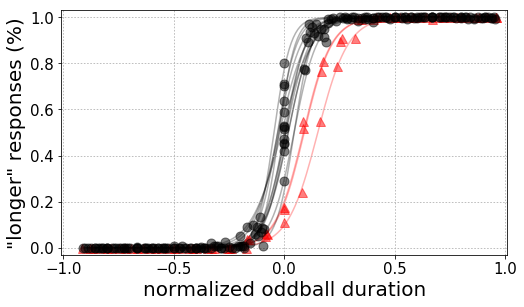

In [41]:
import matplotlib.font_manager as font_manager

plotRespWeber(res34_2000,psy34_2000)

plt.xlim(-1.01,1.01)
plt.ylim(-0.03,1.03)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xticks([-1,-0.5,0.0,0.5,1.0])

plt.grid(True,which='both',linestyle='--',dashes=(2,2))

plt.xlabel("normalized oddball duration",fontsize=20)
plt.ylabel("\"longer\" responses (%)",fontsize=20)

colors = ['k','r']
markers=['-o','-^']

font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal', size=16)

labels = [r'IOI$<$23', r'IOI$\geq$23']
dummies = [plt.plot([], [], markers[colors.index(c)], c=c, ms=10, markeredgecolor='c', alpha=0.7)[0] for c in colors]

plt.savefig("longer-shorter/34-setup-same-sensor-10k/psychometric-curves-2-colors.pdf", bbox_inches='tight')

In [15]:
def plotRelJND(psy, xTickStep=1, delay=0):
    df = psy[psy.index.get_level_values('delay')==delay]#.relJND.tolist()
    tones = [tone for (ioi,tone) in df.index.get_level_values('pattern')]
    jndErr=[e*2 for e in df.JndStd.tolist()]

    relJnds=df.relJND
    relJndErr=[je/tone for (je,tone) in zip(jndErr,tones)]

    plt.figure(figsize=(8,4.5))
    
    plt.errorbar(tones, relJnds, yerr=relJndErr, fmt='o', color='k', markersize=9, capsize=5, elinewidth=1.1)
    plt.axhline(y=np.mean(relJnds),xmin=0.03,xmax=0.97,linestyle='--',color='0.6',dashes=(6,3),linewidth=3.5,zorder=-1)
    
    print (stats.linregress(tones,relJnds))
    
    plt.xticks(range(tones[0],tones[-1]+1,xTickStep),fontsize=14)
    plt.yticks(fontsize=14)
    #plt.xlim(4.5,20.5)
    #plt.ylim(0,0.20)
    plt.grid(True,which='both',linestyle='--',dashes=(2,2))
    plt.xlabel('standard tone', fontsize=20)
    plt.ylabel('relative JND', fontsize=20)


LinregressResult(slope=3.600211137501892e-05, intercept=0.05742088510855294, rvalue=0.007491312171213318, pvalue=0.9780333147690704, stderr=0.0012843809979586674)


([<matplotlib.axis.XTick at 0x1a1f93d438>,
 <a list of 8 Text xticklabel objects>)

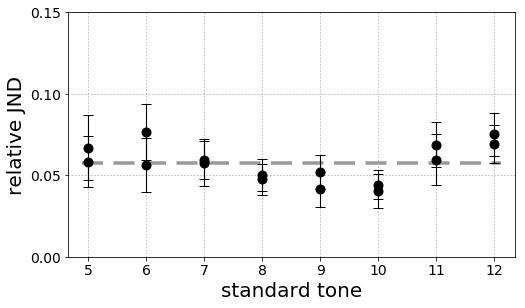

In [16]:
plotRelJND(psy34_2000,5)
plt.ylim(0,0.15)
plt.yticks([0.0,0.05,0.10,0.15])
plt.xticks(range(5,13))
#plt.savefig("data processing-final/relative-JNDs-new.pdf",bbox_inches='tight')

In [90]:
def plotRelJND(psy, xTickStep=1, delay=0):
    df = psy[psy.index.get_level_values('delay')==delay]#.relJND.tolist()
    tones = [tone for (ioi,tone) in df.index.get_level_values('pattern')]
    patterns=df.index.get_level_values('pattern')
    jndErr=[e*2 for e in df.JndStd.tolist()]

    relJnds=df.relJND
    relJndErr=[je/tone for (je,tone) in zip(jndErr,tones)]

    plt.figure(figsize=(8,4.5))
    
    plt.errorbar(range(len(patterns)), relJnds, yerr=relJndErr, fmt='o', color='k', markersize=9, capsize=5, elinewidth=1.1)
    plt.axhline(y=np.mean(relJnds),xmin=0.02,xmax=0.98,linestyle='--',color='0.6',dashes=(6,3),linewidth=3.5,zorder=-1)
    
    print (stats.linregress(tones,relJnds))
    
    #plt.xticks(range(tones[0],tones[-1]+1,xTickStep),fontsize=14)
    plt.xticks(range(len(patterns))[::xTickStep], patterns[::xTickStep], fontsize=14,rotation=70,ha='center')
    plt.yticks(fontsize=14)
    #plt.xlim(4.5,20.5)
    #plt.ylim(0,0.20)
    plt.grid(True,which='both',linestyle='--',dashes=(2,2))
    plt.xlabel('inter-onset-interval, standard tone', fontsize=20)
    plt.ylabel('relative JND', fontsize=20)


LinregressResult(slope=3.600211137501892e-05, intercept=0.05742088510855294, rvalue=0.007491312171213318, pvalue=0.9780333147690704, stderr=0.0012843809979586674)


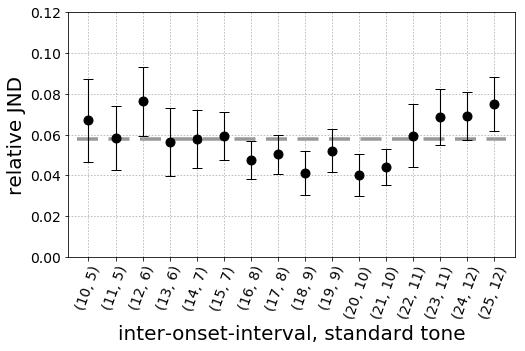

In [18]:
plotRelJND(psy34_2000,1)
plt.ylim(0.0,0.12)
#plt.yticks([0.0,0.05,0.10])

plt.savefig("longer-shorter/34-setup-same-sensor-10k/relative-JNDs.pdf",bbox_inches='tight')

LinregressResult(slope=0.0006893306217304505, intercept=0.03774084716642777, rvalue=0.16534239782755047, pvalue=0.5405664598696422, stderr=0.0010989053109007124)


(0.0, 0.12)

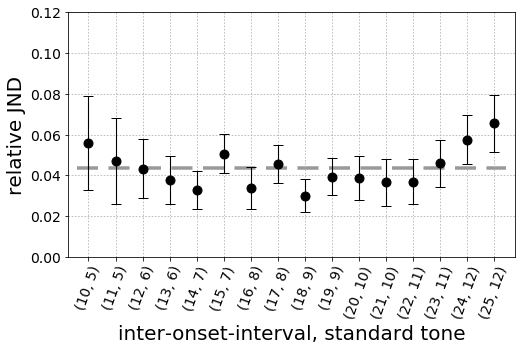

In [94]:
ad="longer-shorter/34-setup-same-sensor-10k/"
psy34_10000=pd.read_csv(ad+"psy-"+str(10000)+".csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
plotRelJND(psy34_10000,1)
plt.ylim(0.0,0.12)

## 1-3) Constant Errors (CEs)
## CE: the difference between Point of Subjective Equality (PSE) and Point of Objective Equality (POE)

In [19]:
def plotsCEs(psy,xTickStep=1):
    
    plt.figure(figsize=(8,4.5))

    df = psy[psy.index.get_level_values('delay')==0]
    patterns=df.index.get_level_values('pattern').tolist()
    xs=range(len(patterns))
    CEs=df.CE
    pseErr=[e*2 for e in df.PseStd.tolist()]

    
    plt.errorbar(xs, CEs, yerr=pseErr, fmt='o', color='k', markersize=9, capsize=5, elinewidth=1.1)
    plt.axhline(y=0,xmin=0.02,xmax=0.98,linestyle='--',color='0.6',dashes=(6,3),linewidth=3.5,zorder=-1)
        
    plt.xticks(range(len(patterns))[::xTickStep], patterns[::xTickStep], fontsize=14,rotation=70,ha='center')
    plt.yticks(fontsize=14)
    #plt.xlim(4.5,20.5)
    #plt.ylim(0,0.20)
    plt.grid(True,which='both',linestyle='--',dashes=(2,2))
    plt.xlabel('inter-onset-interval, standard tone', fontsize=20)
    plt.ylabel('constant error', fontsize=20)

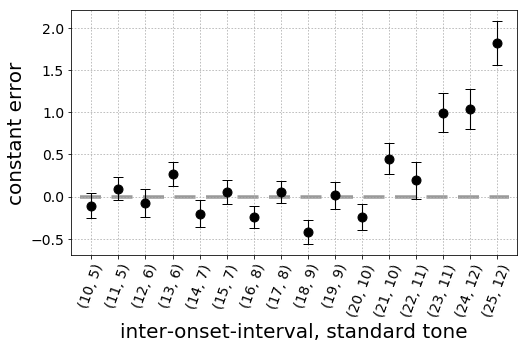

In [20]:
plotsCEs(psy34_2000)
plt.savefig("longer-shorter/34-setup-same-sensor-10k/CE-2000.pdf",bbox_inches='tight')

In [459]:
def subplotsCEs(ad,gens,figFn,yMin,yMax,yticks):
    psyList=list()
    for gen in gens:
        psyList.append(pd.read_csv(ad+"psy-"+str(gen)+".csv",converters={"pattern":ast.literal_eval},index_col=[0,1]))

    fig, ax = plt.subplots(4,2,figsize=(14,18))
    for ind,gen in enumerate(gens):
        psy=psyList[gens.index(gen)]
        i, j = ind//2, ind%2

        df = psy[psy.index.get_level_values('delay')==0]
        #tones = [tone for (ioi,tone) in df.index.get_level_values('pattern')]
        patterns=df.index.get_level_values('pattern').tolist()
        xs=range(len(patterns))
        CEs=df.CE
        pseErr=[e*2 for e in df.PseStd.tolist()]

        ax[i,j].errorbar(xs, CEs, yerr=pseErr, fmt='o', color='k', markersize=5, capsize=5, elinewidth=1.1)
        ax[i,j].axhline(y=0,xmin=0.03,xmax=1.0,linestyle='--',color='0.6',dashes=(5,3),linewidth=3.5,zorder=-1)
        ax[i,j].grid(True,which='both',linestyle='--',dashes=(2,2))
        
        ax[i,j].set_xlim(-0.5, len(xs)-0.5)
        ax[i,j].set_ylim(yMin,yMax)

        ax[i,j].tick_params(axis='both', labelsize=14)
        ax[i,j].tick_params(axis='x', rotation=70)
        ax[i,j].set_xticks(xs)
        ax[i,j].set_xticklabels([str(p) for p in patterns])
        ax[i,j].set_yticks(yticks)
        
        #ax.set_yticks(fontsize=15)
        ax[i,j].set_title("generation="+str(gen),fontsize=18)

    fig.text(-0.03,0.5,"constant error",rotation=90,fontsize=25,va='center')
    fig.text(0.5,-0.03,"inter-onset-interval, standard tone",fontsize=25,ha='center')

    fig.tight_layout(w_pad=2,h_pad=1.5)
    fig.savefig(figFn,bbox_inches='tight')

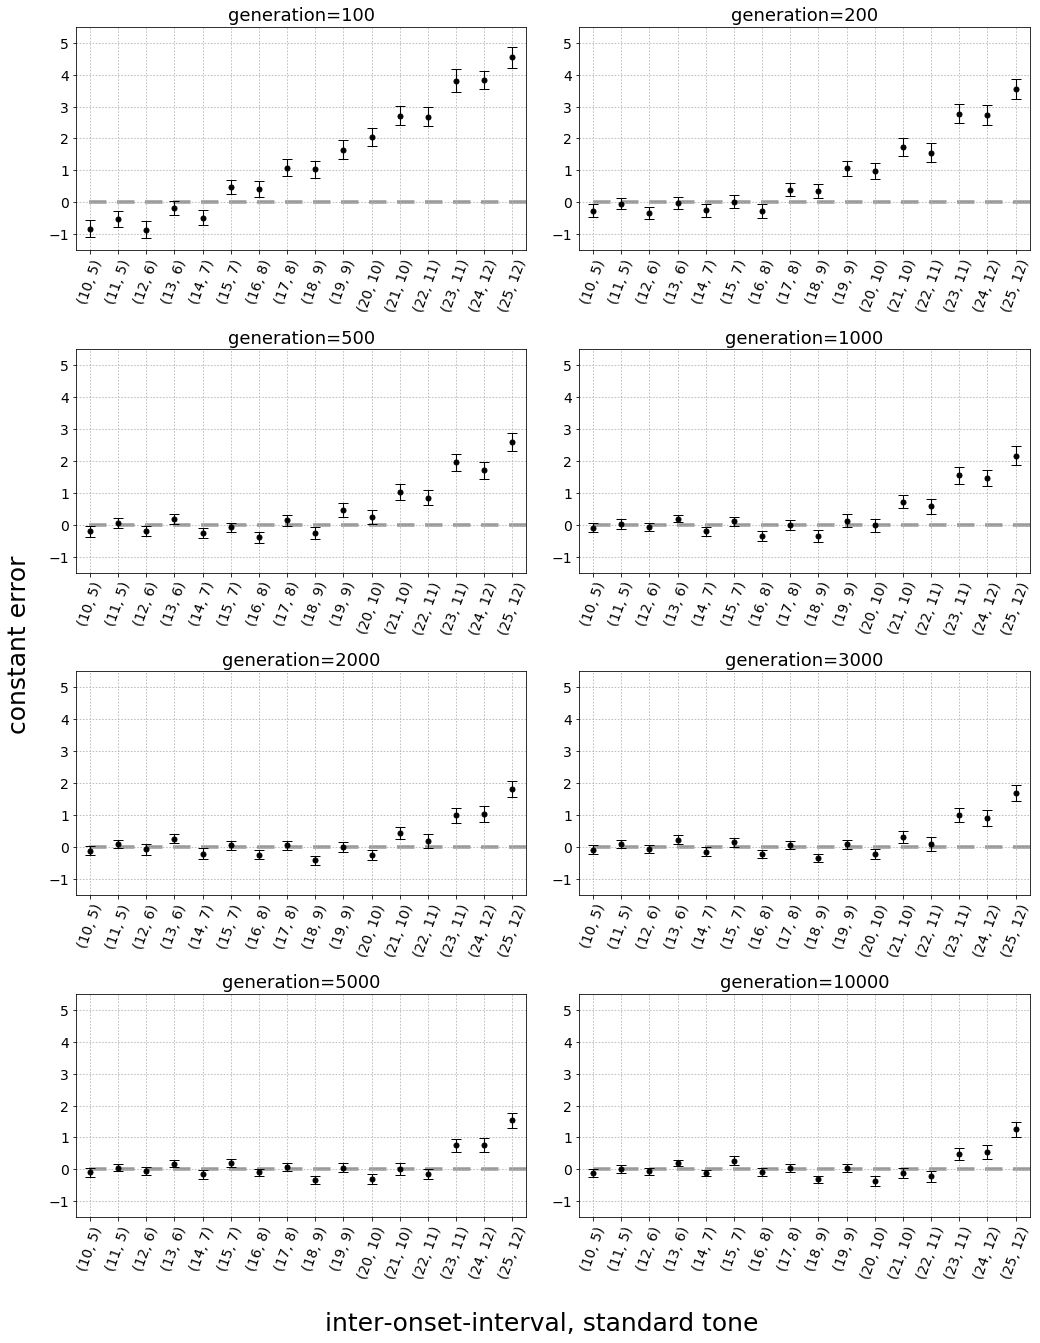

In [460]:
ad = "longer-shorter/34-setup-same-sensor-10k/"
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsCEs(ad,gens,"longer-shorter/34-setup-same-sensor-10k/CEs-8panels.pdf",-1.5,5.5,range(-1,6))

## 1-4) Duration Distortion Factor

In [33]:
def plotDDFSubplots(psyRep, yMin, yMax, yTicks):
    
    patterns=psyRep.index.get_level_values('pattern').unique()
    nr=(len(patterns)+1)/2
    fig,ax=plt.subplots(4,4,figsize=(18,14))
    for ind,pat in enumerate(patterns):
        #print (pat)
        #plt.figure(figsize=(8,5))
        ioi,tone=pat
        X,Y=psyRep.loc[pat].index.tolist(),psyRep.loc[pat].DDF.tolist()
        delLim=2*tone//3
        indInit=X.index(-delLim)# if X[0]<-tone else 0#X.index(-tone) if X[0]<-tone else 0
        indFin=X.index(delLim)+1# if X[-1]>tone else len(X)#X.index(tone)+1 if X[-1]>tone else len(X)
        X=X[indInit:indFin]
        Y=Y[indInit:indFin]
        
        pses=psyRep.loc[pat].PSE.tolist()[indInit:indFin]
        pseStds=psyRep.loc[pat].PseStd.tolist()[indInit:indFin]
        
        yerr=[2*err*tone/(pse*pse) for (err,pse) in zip(pseStds,pses)]
        
        i,j=ind//4,ind%4
        ax[i,j].errorbar(X,Y,yerr=yerr,color='k',fmt='o',markersize=8,capsize=5,elinewidth=1.1)#,s=80,color='k')
        #ax[ind/2,ind%2].errorbar(X,Y,yerr=yerr,fmt='none')
        reg=stats.linregress(X,Y)
        txt=str(pat)+", slope: "+str(round(reg.slope,2))+", $r^{2}$: "+str(round(reg.rvalue*reg.rvalue,2))
        
        delays=psyRep.loc[pat].index.tolist()
        ax[i,j].axhline(1.0,delays[indInit],delays[indFin-1],linestyle='-.',linewidth=4,color='0.6',dashes=(5,3),
                        zorder=-1)       
        ax[i,j].axhline(tone/psyRep.loc[pat].loc[0].PSE,delays[indInit],delays[indFin-1],linestyle=':',
                        linewidth=4,color='0.6')       
        
        ax[i,j].set_title("IOI="+str(pat[0])+", std tone="+str(pat[1]),fontsize=20)
        ax[i,j].tick_params(axis='both', labelsize=15)
        ax[i,j].grid(which='both',linestyle=':')
        ax[i,j].set_xlim(X[0]-0.5,X[-1]+0.5)
        ax[i,j].set_ylim(yMin, yMax)
        ax[i,j].set_yticks(yTicks)
        #plt.ylim(0,2.2)
    plt.rcParams['mathtext.default']='regular'
    
    fig.text(-0.03,0.5,"duration distortion factor",rotation=90,fontsize=28,va='center')
    fig.text(0.5,-0.03,"oddball onset",fontsize=28,ha='center')

    #plt.show()
    return fig,ax


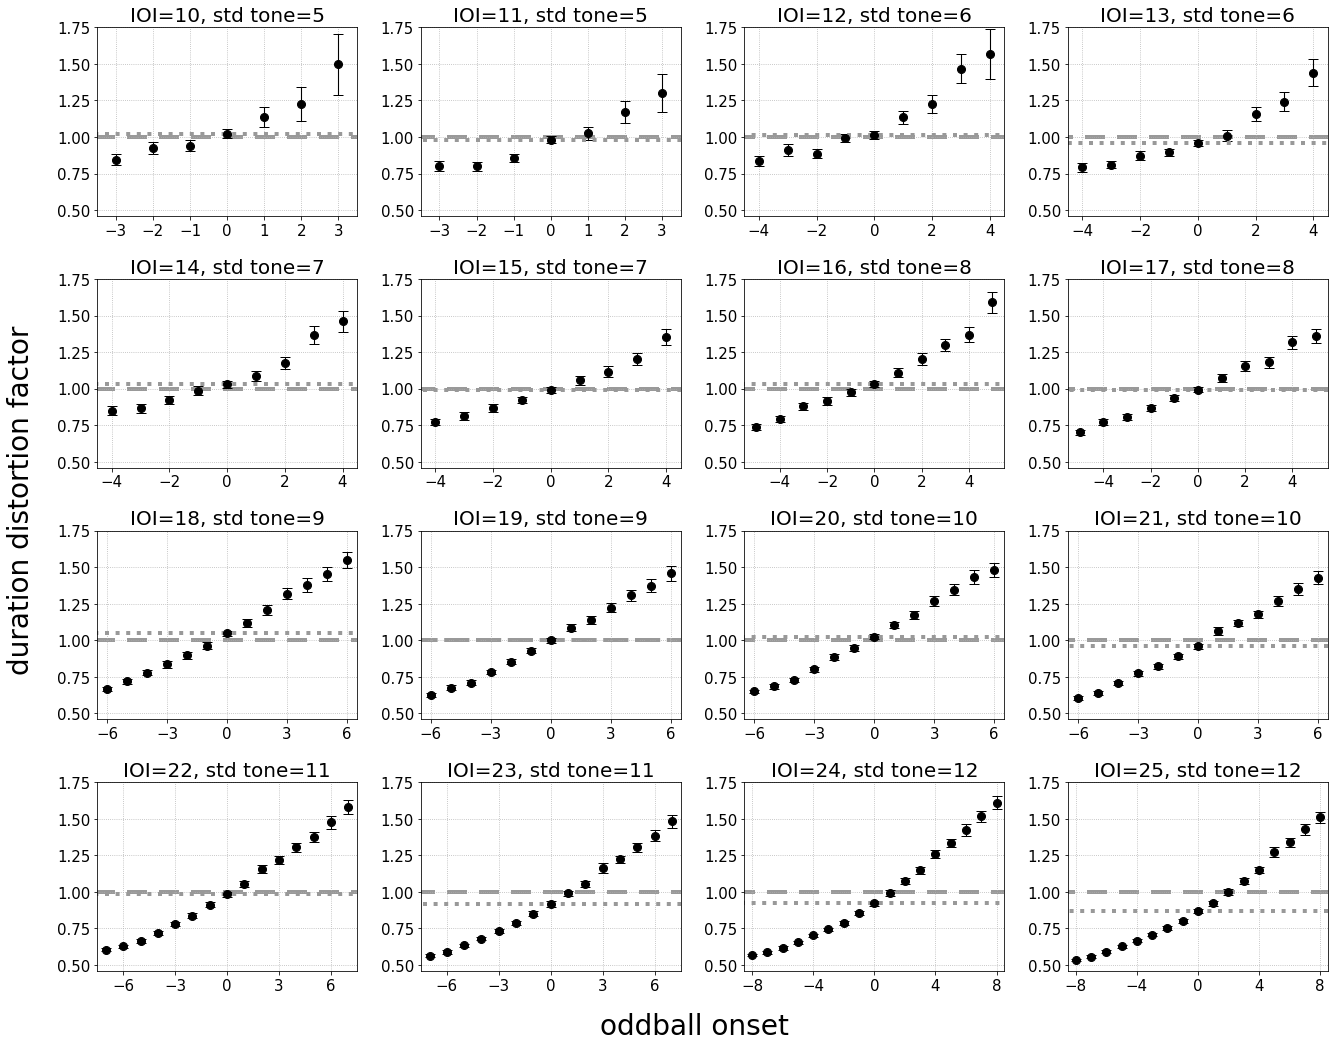

In [42]:
# ad="longer-shorter/34-setup-same-sensor-10k/"
# fig,ax = plotDDFSubplots(pd.read_csv(ad+"psy-2000.csv",index_col=[0,1],
#                             converters={"pattern":ast.literal_eval}), 0.46, 1.75, np.arange(0.5,1.76,0.25))

fig,ax = plotDDFSubplots(psy34_2000, 0.46, 1.75, np.arange(0.5,1.76,0.25))

ax[0,0].set_xticks(range(-3,4))
ax[0,1].set_xticks(range(-3,4))
# ax[0,2].set_xticks(range(-4,5))
# ax[0,3].set_xticks(range(-4,5))
ax[1,2].set_xticks(range(-4,5,2))
ax[1,3].set_xticks(range(-4,5,2))
ax[2,0].set_xticks(range(-6,7,3))
ax[2,1].set_xticks(range(-6,7,3))
ax[2,2].set_xticks(range(-6,7,3))
ax[2,3].set_xticks(range(-6,7,3))
ax[3,0].set_xticks(range(-6,7,3))
ax[3,1].set_xticks(range(-6,7,3))
ax[3,2].set_xticks(range(-8,9,4))
ax[3,3].set_xticks(range(-8,9,4))

fig.tight_layout(w_pad=2,h_pad=2)

fig.savefig("longer-shorter/34-setup-same-sensor-10k/DDFs.pdf",bbox_inches='tight')

## curve_fit function from scipy.stats may not converge in some cases which can be remedied using different set of initial values for $k$, and $x_0$.
## The following functions can be utilized to rerun curve_fit on response files and also to visualize the outcome to check whether the resulting sigmoid functions fit the data.
## It is necessary, however, to run the following code for current experimental setup since all shown data points are from converged curve_fits.

In [8]:
def sigmoid(x,k,x0):
    return 1.0/(1+np.exp(-k*(x-x0)))

def correctFit(res,psy,p,delay,initial_guess=(np.nan,np.nan)):
    ioi,tone=p
    
    obTones=list(res.loc[pat].loc[delay,1].obTones)
    responses=list(np.mean(res.loc[pat].loc[delay].response.tolist(),axis=0))
    rSigma=list(stats.sem(res.loc[pat].loc[delay].response.tolist(),axis=0))
    
    tre=list(zip(obTones,responses,rSigma))
    #tre=list(filter(lambda arg: arg[2] != 0, tre))

    # remove zeros from the beginning
    for init, (ob,resp,sig) in enumerate(tre):
        if resp!=0:
            break
    # remove ones from the end
    for fin, (ob,resp,sig) in enumerate(tre[::-1]):
        if resp!=1:
            break

    fin=len(tre)-fin
    tre=tre[init:fin]

    obTones,responses,rSigma=[list(t) for t in zip(*tre)]

    # correct ones and zeros in the middle
    errMin = np.min(list(filter(lambda el: el>0, rSigma)))
    print (errMin)
    for ind, (ob,resp,sig) in enumerate(tre):
        if (resp==0):
            responses[ind]=0.01
            rSigma[ind]=errMin
        if (resp==1):
            responses[ind]=0.99
            rSigma[ind]=errMin

    if (responses.count(0)!=0 or responses.count(1)!=0):
        print ("responses contain 0 or 1")
        print (obTones,'\n',responses,'\n',sigmas,'\n')

    if (len(tre)<2):
        print ("less than 3 data points are invalid")
        return []
    
    try:
        if (initial_guess==(np.nan,np.nan)):
            x0_0=obTones[min(range(len(responses)), key=lambda i: abs(responses[i]-0.5))]
            popt,pcov=curve_fit(sigmoid,obTones,responses,sigma=rSigma,absolute_sigma=True,p0=(1,x0_0),maxfev=10000)
        else:
            popt,pcov=curve_fit(sigmoid,obTones,responses,sigma=rSigma,absolute_sigma=True,maxfev=10000,
                                p0=[initial_guess[0],initial_guess[1]])
            
        k,x0=popt
        kStd,pseStd=np.sqrt(np.diag(pcov))
        pseJndCov=pcov[0,1]
        jnd=log(3.0)/k
        jndStd=log(3.0)/(k*k)*kStd
        relJND=jnd/tone
        ddf=tone/x0
        ce=x0-tone
    except RuntimeError:
        print ("Runtime Error")

    return [x0,pseStd,jnd,jndStd,pseJndCov,relJND,ddf,ce]

def plotResponseCurve(res,psy,pat,delay=0):
    obs=res.loc[pat].loc[delay,1].obTones
    resp=np.mean(res.loc[pat].loc[delay].response.tolist(),axis=0)

    plt.scatter(obs,resp)
    x0=psy.loc[pat].loc[delay].PSE
    k=log(3.0)/psy.loc[pat].loc[delay].JND

    dt=0.1
    ts=np.arange(obs[0]-dt,obs[-1]+dt,dt)
    plt.plot(ts,[sigmoid(ob,k,x0) for ob in ts])
    plt.show()

pattern: (22, 11) 	delay: 7 

psychometric curve for current values:


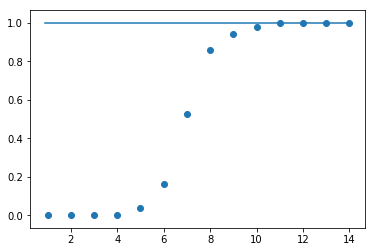

0.01999999999999999
psychometric curve after corrections:


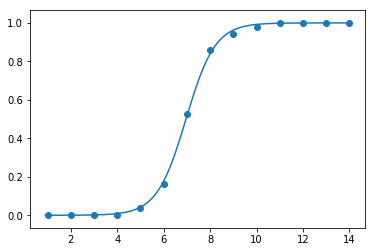

pattern: (24, 12) 	delay: 8 

psychometric curve for current values:


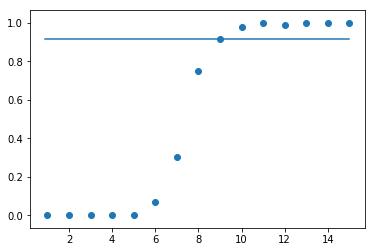

0.009999999999999993
psychometric curve after corrections:


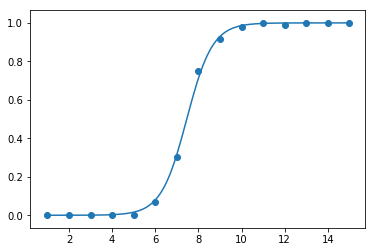

pattern: (25, 12) 	delay: 8 

psychometric curve for current values:


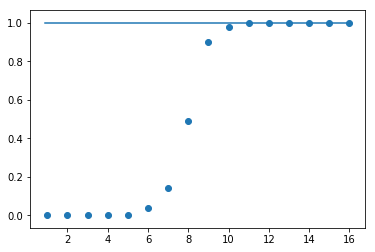

0.01999999999999999
psychometric curve after corrections:


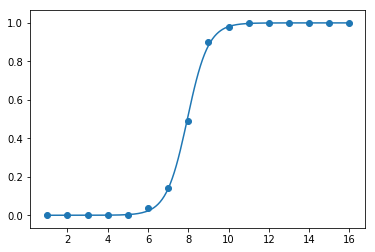

In [82]:
psy_34_2000_corrected = psy_34_2000.copy(deep=True)

inq=[((22,11),7), ((24,12),8), ((25,12),8)]

for (pat,delay) in inq:
    print ("pattern:",pat,"\tdelay:",delay,'\n')
    print ("psychometric curve for current values:")
    plotResponseCurve(res_34_2000, psy_34_2000, pat, delay)

    l=correctFit(res_34_2000, psy_34_2000_corrected, pat, delay)

    print ("psychometric curve after corrections:")
    psy_34_2000_corrected.loc[pat,delay]=l
    plotResponseCurve(res_34_2000, psy_34_2000_corrected, pat, delay)

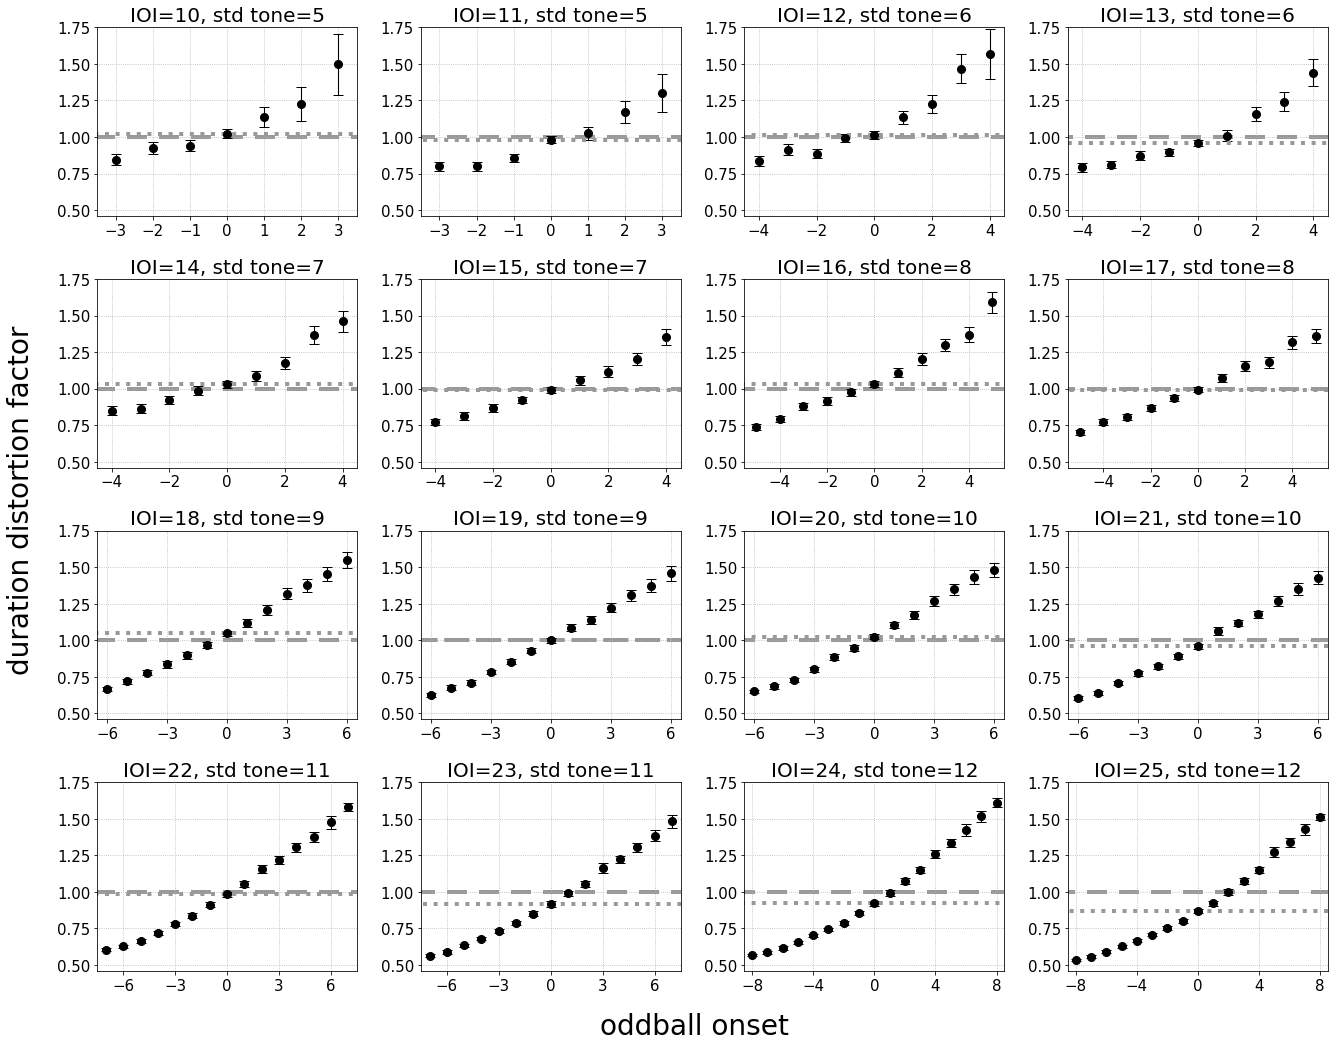

In [75]:
ad="longer-shorter/34-setup-same-sensor-10k/"

fig,ax = plotDDFSubplots(psy_34_2000_corrected, 0.46, 1.75, np.arange(0.5,1.76,0.25))

ax[0,0].set_xticks(range(-3,4))
ax[0,1].set_xticks(range(-3,4))
# ax[0,2].set_xticks(range(-4,5))
# ax[0,3].set_xticks(range(-4,5))
ax[1,2].set_xticks(range(-4,5,2))
ax[1,3].set_xticks(range(-4,5,2))
ax[2,0].set_xticks(range(-6,7,3))
ax[2,1].set_xticks(range(-6,7,3))
ax[2,2].set_xticks(range(-6,7,3))
ax[2,3].set_xticks(range(-6,7,3))
ax[3,0].set_xticks(range(-6,7,3))
ax[3,1].set_xticks(range(-6,7,3))
ax[3,2].set_xticks(range(-8,9,4))
ax[3,3].set_xticks(range(-8,9,4))

fig.tight_layout(w_pad=2,h_pad=2)

fig.savefig("longer-shorter/34-setup-same-sensor-10k/DDFs.pdf",bbox_inches='tight')

# 2) Fitness

## 2-1) Fitness in Line-of-Descent: Fitness vs. Generation

In [128]:
def plotLodFitness(M,E,step,end,xticks,fnSave=''):
    fitL = [m-2*e for (m,e) in list(zip(M,E))]
    fitH = [m+2*e for (m,e) in list(zip(M,E))]

    plt.figure(figsize=(7,5))
    plt.plot(lodMean.index[: end: step], fitL[: end: step], color='grey',linestyle='-')
    plt.plot(lodMean.index[: end: step], fitH[: end: step], color='grey',linestyle='-')
    plt.fill_between(lodMean.index[: end:step], fitL[: end: step], fitH[: end: step], color='lightgrey',alpha=0.5)
    plt.plot(lodMean.index[: end: step], lodMean.fitness[: end: step],color='k')

    plt.xlabel('generation',fontsize=20)
    plt.ylabel('fitness',fontsize=20)
    plt.xticks(xticks, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(which='both',linestyle='--',dashes=(1,4))
    plt.xlim(-10,end)
    plt.ylim(0.50,1.00)
    if (fnSave!=''):
        plt.savefig(fnSave,bbox_inches='tight')

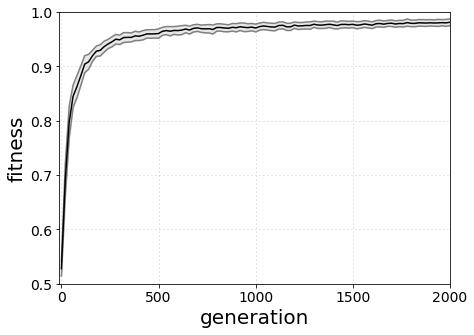

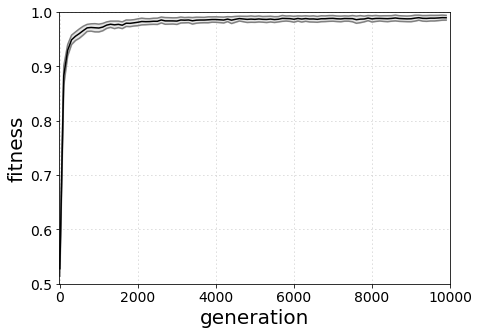

In [296]:
ad = "longer-shorter/34-setup-same-sensor-10k/"
reps = range(1,51)
lods = list()
for rep in reps:
    lod = pd.read_csv(ad+"LOD_"+str(rep)+".csv",names=['generation','fitness'],skiprows=[0,1])
    lod['rep'] = rep
    lods.append(lod)
    
lod34_10k = pd.concat(lods)
lod34_10k.set_index(['rep','generation'], inplace=True)
lodMean = lod34_10k.mean(level=1)/100.0
lodErr = lod34_10k.sem(level=1)/100.0

plotLodFitness(lodMean.fitness,lodErr.fitness,20,2001,range(0,2001,500))
plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-generation-2000.pdf",bbox_inches='tight')

plotLodFitness(lodMean.fitness,lodErr.fitness,100,10001,range(0,10001,2000))
plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-generation-10000.pdf",bbox_inches='tight')

## 2-2) Fitness Disributions vs. Trials (Inter-onset-interval, Standard Tone)

In [30]:
# calculate fitnesses in each IOI/std tone
def fitness(res):
    df = res[res.index.get_level_values('delay')==0]
    df.index = df.index.droplevel('delay')
    levels = df.index
    fit = pd.DataFrame(index = levels, columns=['absFit','relFit'],dtype=float)
    for pat,rep in df.index:
        ioi,tone = pat
        res = df.loc[pat].loc[rep].response
        f = np.sum([1-r for r in res[:tone-1]])
        f += np.sum([r for r in res[tone:]])
        fit.loc[pat,rep]=[f, f/float(ioi-2)]

    return fit

def plotFitness(fit, fnSave=''):
    #plt.figure(figsize=(8,5))
    
    patterns = fit.index.get_level_values('pattern').unique().tolist()
    tones = [t for (i,t) in patterns]
    xs=range(len(patterns))
    plt.errorbar(xs, fit.mean(level=0).relFit.tolist(),
                 yerr=fit.sem(level=0).relFit.tolist(),fmt='o',capsize=5,color='0.3')
    #plt.xticks(range(5,21), fit25ss_2000.index.get_level_values('pattern').unique().tolist())
    plt.xlabel('standard tone',fontsize=15)
    plt.ylabel('fitness',fontsize=15)
    
    plt.xlabel('standard tone',fontsize=20)
    plt.ylabel('fitness',fontsize=20)
    plt.xticks(xs,[str(x) for x in patterns], fontsize=14, rotation=70, position=(0.1,0))#range(0,end+1,500), 
    plt.yticks(fontsize=14)
    plt.grid(which='both',linestyle='--',dashes=(1,4))

    #plt.ylim(0.85,1.0)
    
    if (fnSave!=''):
        plt.savefig(fnSave,bbox_inches='tight')

0.9796418414715657


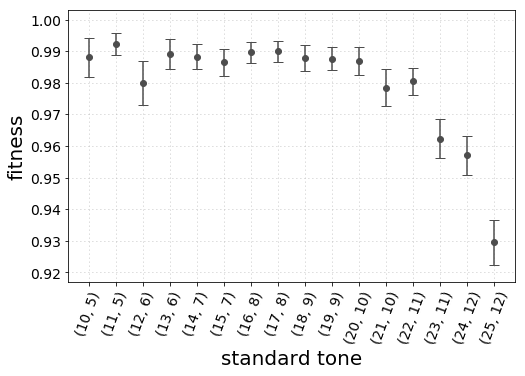

In [307]:
ad="longer-shorter/34-setup-same-sensor-10k/"
res34_2000=readResponseFile(ad+"res-2000.csv")

fit34_2000 = fitness(res34_2000)
plotFitness(fit34_2000)

plt.ylim(0.917,1.003)

print (fit34_2000.relFit.mean())
plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-trial-2000.pdf",bbox_inches='tight')

0.9888161904028575


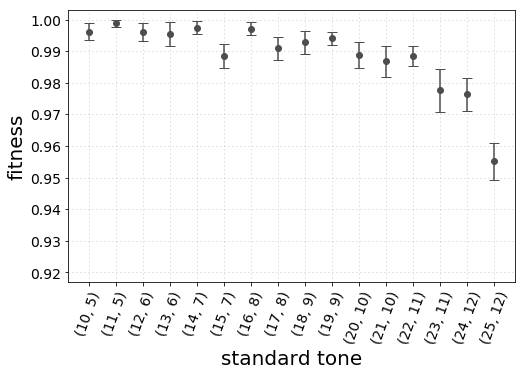

In [297]:
ad="longer-shorter/34-setup-same-sensor-10k/"
res34_10000=readResponseFile(ad+"res-10000.csv")

fit34_10000 = fitness(res34_10000)
plotFitness(fit34_10000)

plt.ylim(0.917,1.003)

print (fit34_10000.relFit.mean())
plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-trial-10000.pdf",bbox_inches='tight')

In [144]:
def plotFitness(fit, sm):
    #plt.figure(figsize=(8,5))
    sym,col=sm
    
    patterns = fit.index.get_level_values('pattern').unique().tolist()
    tones = [t for (i,t) in patterns]
    xs=range(len(patterns))
    
    plt.errorbar(xs, fit.mean(level=0).relFit.tolist(),
                 yerr=fit.sem(level=0).relFit.tolist(),fmt=sym,capsize=5,color=col,alpha=0.7)
    #plt.xticks(range(5,21), fit25ss_2000.index.get_level_values('pattern').unique().tolist())
    plt.xlabel('standard tone',fontsize=15)
    plt.ylabel('fitness',fontsize=15)
    
    plt.xlabel('standard tone',fontsize=20)
    plt.ylabel('fitness',fontsize=20)
    plt.xticks(xs,[str(x) for x in patterns], fontsize=14, rotation=70, position=(0.1,0))#range(0,end+1,500), 
    plt.yticks(fontsize=14)
    plt.grid(which='both',linestyle='--',dashes=(1,4))

(0.917, 1.003)

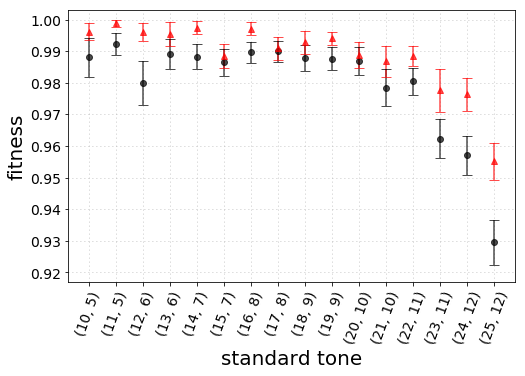

In [40]:
ad="longer-shorter/34-setup-same-sensor-10k/"
res34_2000=readResponseFile(ad+"res-2000.csv")

fit34_2000 = fitness(res34_2000)

#print (fit34_2000.relFit.mean())

ad="longer-shorter/34-setup-same-sensor-10k/"
res34_10000=readResponseFile(ad+"res-10000.csv")

fit34_10000 = fitness(res34_10000)

plt.figure(figsize=(8,5))
plotFitness(fit34_2000, ('o','k'))
plotFitness(fit34_10000, ('^','red'))

#plt.ylim(0.917,1.003)

plt.ylim(0.917,1.003)

#print (fit34_10000.relFit.mean())
#plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-trial-10000.pdf",bbox_inches='tight')
#plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-trial-2000.pdf",bbox_inches='tight')

In [43]:
def plotFitness(fit, sm):
    #plt.figure(figsize=(8,5))
    sym,col=sm
    
    patterns = fit.index.get_level_values('pattern').unique().tolist()
    tones = [t for (i,t) in patterns]
    xs=range(len(patterns))
    plt.bar(xs, fit.mean(level=0).relFit.tolist(),
                 yerr=fit.sem(level=0).relFit.tolist(),capsize=5,color=col,alpha=0.7)
    #plt.xticks(range(5,21), fit25ss_2000.index.get_level_values('pattern').unique().tolist())
    plt.xlabel('standard tone',fontsize=15)
    plt.ylabel('fitness',fontsize=15)
    
    plt.xlabel('standard tone',fontsize=20)
    plt.ylabel('fitness',fontsize=20)
    plt.xticks(xs,[str(x) for x in patterns], fontsize=14, rotation=70, position=(0.1,0))#range(0,end+1,500), 
    plt.yticks(fontsize=14)
    plt.grid(which='both',linestyle='--',dashes=(1,4))

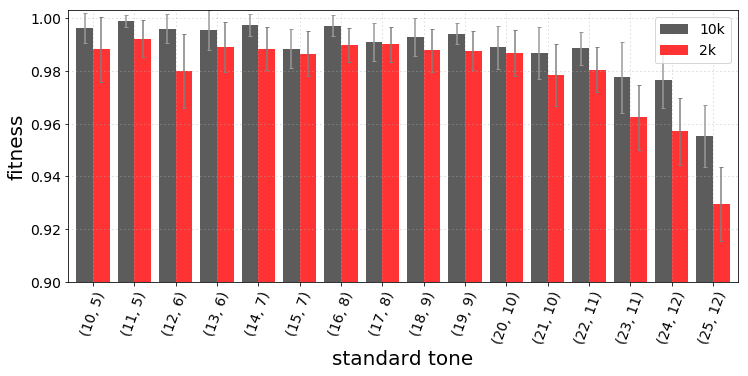

In [469]:
ad="longer-shorter/34-setup-same-sensor-10k/"
res34_2000=readResponseFile(ad+"res-2000.csv")
fit34_2000 = fitness(res34_2000)
res34_10000=readResponseFile(ad+"res-10000.csv")
fit34_10000 = fitness(res34_10000)

plt.figure(figsize=(12,5))

patterns = fit34_2000.index.get_level_values('pattern').unique().tolist()
tones = [t for (i,t) in patterns]
xs=range(len(patterns))
plt.bar([x-0.2 for x in xs], fit34_10000.mean(level=0).relFit.tolist(),
        yerr=[2*e for e in fit34_10000.sem(level=0).relFit.tolist()],
        color='0.2', alpha=0.8, width=0.4, capsize=2, ecolor='0.6', label='10k')

plt.bar([x+0.2 for x in xs], fit34_2000.mean(level=0).relFit.tolist(),
        yerr=[2*e for e in fit34_2000.sem(level=0).relFit.tolist()],
        color='red', alpha=0.8, width=0.4, capsize=2, ecolor='0.5', label='2k')


plt.xlabel('standard tone',fontsize=15)
plt.ylabel('fitness',fontsize=15)

plt.xlabel('standard tone',fontsize=20)
plt.ylabel('fitness',fontsize=20)
plt.xticks(xs,[str(x) for x in patterns], fontsize=14, rotation=70, position=(0.1,0))#range(0,end+1,500), 
plt.yticks(fontsize=14)
plt.grid(which='both',linestyle='--',dashes=(1,4))
plt.xlim(-0.6,15.6)
plt.ylim(0.90,1.003)

plt.legend(fontsize=14)#loc

#print (fit34_10000.relFit.mean())
#plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-trial-10000.pdf",bbox_inches='tight')
#plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-trial-2000.pdf",bbox_inches='tight')

In [349]:
# calculate fitnesses in each IOI/std tone
def fitness(res):
    df = res[res.index.get_level_values('delay')==0]
    df.index = df.index.droplevel('delay')
    levels = df.index
    fit = pd.DataFrame(index = levels, columns=['absFit','relFit'],dtype=float)
    for pat,rep in df.index:
        ioi,tone = pat
        res = df.loc[pat].loc[rep].response
        f = np.sum([1-r for r in res[:tone-1]])
        f += np.sum([r for r in res[tone:]])
        fit.loc[pat,rep]=[f, f/float(ioi-2)]

    return fit

ad="longer-shorter/34-setup-same-sensor-10k/"
gens=[100,200,500,1000,2000,3000,5000,10000]

l=[]
for gen in gens:
    res34=readResponseFile(ad+"res-"+str(gen)+".csv")
    fit=fitness(res34)#.reset_index()
    fit['gen']=gen
    #fit.set_index('gen')
    l.append(fit)
    del res34,fit
    
fits34=pd.concat(l)
fits34.set_index(['gen'],append=True,inplace=True)
fits34=fits34.reorder_levels(['gen','pattern','rep'])

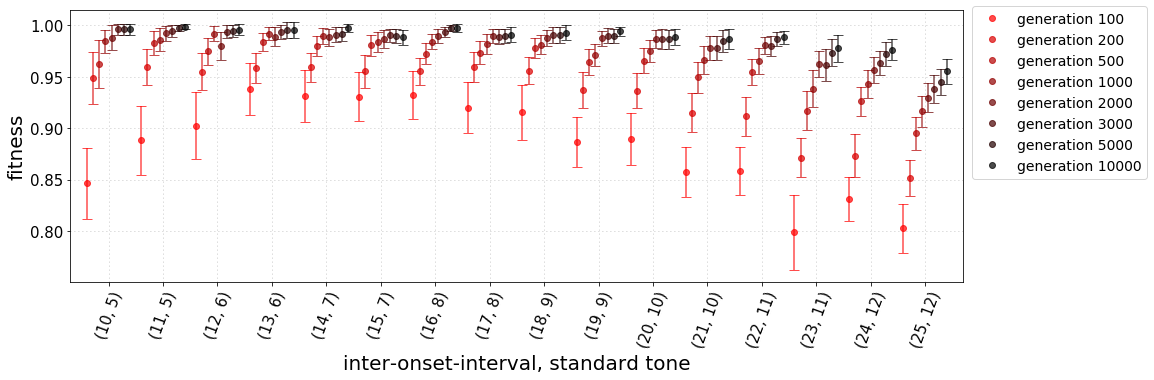

In [484]:
from matplotlib import container

rs=np.arange(1,-0.01,-1/7)
bs=np.arange(0,1.01,1/7)
gs=np.arange(0,1.01,1/7)
xOffset=np.arange(-0.4,0.41,0.8/7)

fig=plt.figure(figsize=(16,5))

patterns = fits34.index.get_level_values('pattern').unique().tolist()
gens = fits34.index.get_level_values('gen').unique().tolist()

meanFit34=fits34.mean(level=[0,1])
semFit34=fits34.sem(level=[0,1])
for i,gen in enumerate(gens):
    xs=[x+xOffset[i] for x in range(len(patterns))]
    plt.errorbar(xs,meanFit34[meanFit34.index.get_level_values('gen')==gen].relFit.tolist(),
                 yerr=[2*e for e in semFit34[semFit34.index.get_level_values('gen')==gen].relFit.tolist()],
                 fmt='o',capsize=5,color=(rs[i],0,0),alpha=0.7,label='generation '+str(gens[i]))

plt.xlabel('inter-onset-interval, standard tone',fontsize=20)
plt.ylabel('fitness',fontsize=20)
plt.xticks(range(len(xs)),[str(x) for x in patterns], fontsize=15, rotation=70, position=(0.1,0))#range(0,end+1,500), 
plt.yticks(fontsize=15)
plt.grid(which='both',linestyle='--',dashes=(1,4))
plt.xlim(-0.7,15.7)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles=[h[0] for h in handles]
ax.legend(handles, labels, loc=[1.01,0.38],fontsize=14)
#plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-generation-IOI.pdf",bbox_inches='tight')

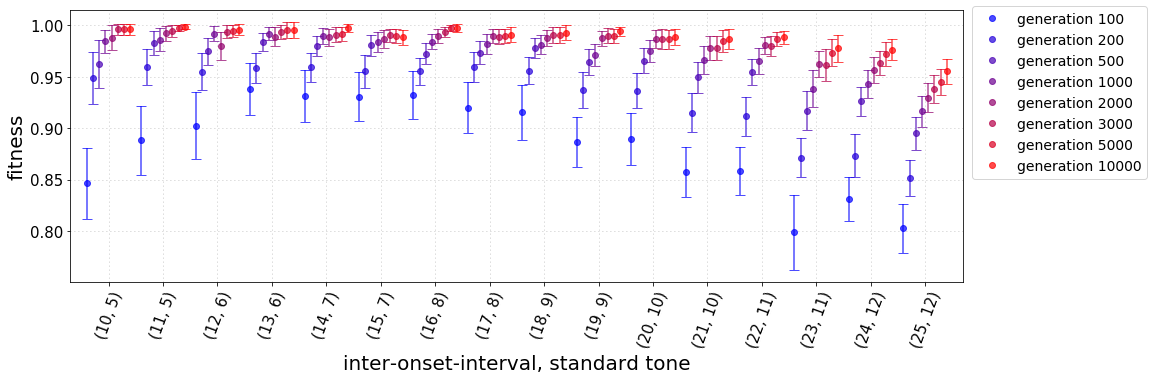

In [476]:
from matplotlib import container

rs=np.arange(0,1.01,1/7)
bs=np.arange(1,-0.01,-1/7)
xOffset=np.arange(-0.4,0.41,0.8/7)

fig=plt.figure(figsize=(16,5))

patterns = fits34.index.get_level_values('pattern').unique().tolist()
gens = fits34.index.get_level_values('gen').unique().tolist()

meanFit34=fits34.mean(level=[0,1])
semFit34=fits34.sem(level=[0,1])
for i,gen in enumerate(gens):
    xs=[x+xOffset[i] for x in range(len(patterns))]
    plt.errorbar(xs,meanFit34[meanFit34.index.get_level_values('gen')==gen].relFit.tolist(),
                 yerr=[2*e for e in semFit34[semFit34.index.get_level_values('gen')==gen].relFit.tolist()],
                 fmt='o',capsize=5,color=(rs[i],0,bs[i]),alpha=0.7,label='generation '+str(gens[i]))

plt.xlabel('inter-onset-interval, standard tone',fontsize=20)
plt.ylabel('fitness',fontsize=20)
plt.xticks(range(len(xs)),[str(x) for x in patterns], fontsize=15, rotation=70, position=(0.1,0))#range(0,end+1,500), 
plt.yticks(fontsize=15)
plt.grid(which='both',linestyle='--',dashes=(1,4))
plt.xlim(-0.7,15.7)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles=[h[0] for h in handles]
ax.legend(handles, labels, loc=[1.01,0.38],fontsize=14)
#plt.savefig("longer-shorter/34-setup-same-sensor-10k/fitness-generation-IOI.pdf",bbox_inches='tight')

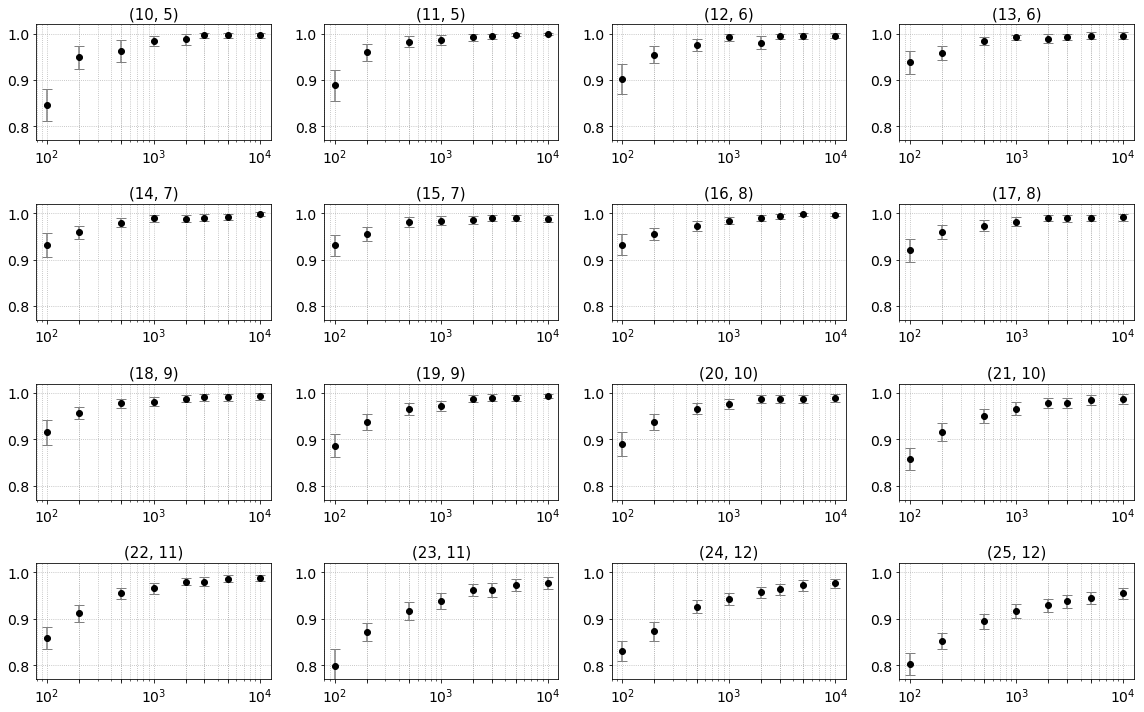

In [455]:
fig,ax=plt.subplots(4,4,figsize=(16,10))

plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

patterns = fits34.index.get_level_values('pattern').unique().tolist()
gens = fits34.index.get_level_values('gen').unique().tolist()
for i,pat in enumerate(patterns):
    ax[i//4,i%4].errorbar(gens,meanFit34[meanFit34.index.get_level_values('pattern')==pat].relFit.tolist(),
                          yerr=[2*e for e in semFit34[semFit34.index.get_level_values('pattern')==pat].relFit.tolist()],
                          fmt='o',capsize=5,color='k',ecolor='0.5')
    ax[i//4,i%4].set_xscale('log')    
    ax[i//4,i%4].set_xticks(gens)
    #ax[i//4,i%4].set_xticklabels([str(np.format_float_scientific(gen)) for gen in gens])
    ax[i//4,i%4].set_title(str(pat),fontsize=15)
    #ax[i//4,i%4].ticklabel_format(axis='x',style='sci')
    ax[i//4,i%4].grid(which='both',linestyle=':')
    ax[i//4,i%4].set_yticks(np.arange(0.8,1.01,0.1))
    ax[i//4,i%4].set_ylim(0.77,1.02)
    
    #ax[i//4,i%4].set_yticklabels()
    
fig.tight_layout(w_pad=2,h_pad=2)

# 3) State Space Analysis

## 3-1) Perception (Brain state at decision time)
## Brain State Visits Frequency

In [ ]:
import pandas as pd
import numpy as np
import sys
from ast import literal_eval

inDir = sys.argv[1]
visFn = sys.argv[2]
seqFn = sys.argv[3]
gen = sys.argv[4]
repInit = sys.argv[5]
repFin = sys.argv[6]

reps=range(int(repInit), int(repFin) + 1)

####### find patterns
fn = inDir+"tests_"+str(reps[0])+"_"+str(gen)+".csv"
temp = pd.read_csv(fn,index_col=[0,1,2,3])
patterns = list(temp.index.unique())

del temp

####### create df, and indices
ind=list([])
for rep in reps:
    for (ioi,tone,obTone,obDelay) in patterns:
        ind.append((rep,ioi,tone,obTone,obDelay))

levels=pd.MultiIndex.from_tuples(ind,names=['rep','ioi','tone','ob','delay'])
contexts=pd.DataFrame(index=levels,columns=['trials','fa','ig','unseen'],dtype=int)
contexts.trials=[0]*len(contexts)
contexts.fa=[0]*len(contexts)
contexts.ig=[0]*len(contexts)
contexts.unseen=[0]*len(contexts)

sequences = pd.DataFrame(columns=['rep','ioi','tone','ob','delay','pos','depth','similarity'])

####### read tests files and fill contexts and sequences
for rep in reps:
    print (rep)
    t = pd.read_csv(inDir+"tests_"+str(rep)+"_"+str(gen)+".csv", index_col=[0,1,2,3,4])
    t.sort_index(inplace=True)

    #training states: states visited for on-time trials
    dfTrain = t[t.index.get_level_values('obDelay')==0].copy(deep=True)
    trStates=set([int(s) for v in dfTrain.vid for s in v.split(',')])
    del dfTrain

    ####### go through all trials
    for (ioi,tone,ob,delay,pos) in t.index:
        
        ####### exclude unwanted trials
        ####### delay should not be 0 (early or late only), not too early/late (|delay|<tone)
        if delay==0 or delay<tone-ioi+1 or delay>ioi-tone-1:
            continue
        ## oddball ends outside interval
        if delay+ob<=0:
            continue
        
        contexts.loc[rep,ioi,tone,ob,delay].trials += 1

        ####### misjudgments
        dec = t.loc[ioi,tone,ob,delay,pos].obAction

        ## delayed: decision==longer, advanced: decision==shorter
        if (delay<0 and dec==1) or (delay>0 and dec==0):# or (delay>0 and ob>tone) or (delay<0 and ob<tone):
            continue
        ## oddball that is delayed and shorter, or advanced and longer (otherwise it is not a misjudgment)
        if (delay>0 and ob>tone) or (delay<0 and ob<tone):
            continue
        ## exclude cases that can't technically be compared to ontime cases
        if (delay>0 and ob+delay<tone) or (delay<0 and ob+delay>tone):
            continue

        ####### misjudgment occured
        contexts.loc[rep,ioi,tone,ob,delay].fa += 1

        ## the entire states sequence of the trial
        s1 = [int(s) for s in t.loc[ioi,tone,ob,delay,pos].vid.split(',')] #it should be states rather than vid but in tests_* files header, 'states' and 'vid' are written the other way around (incorrectly)

        ## the portion regarding misjudgment. +1 in first index excludes state=0 at the very beginning, for early oddballs we are interested in portion including the early oddball
        lead = delay if delay<0 else 0
        sInt1 = s1[pos*ioi + 1 + lead : (pos+1)*ioi + 1]
        
        ####### misjudgment from unseen (new) states
        if not (sInt1[-1] in trStates):
            contexts.loc[rep,ioi,tone,ob,delay].unseen+=1

        ####### is it ignore onset? compare (mis)judgment state with judgment states in which ob_out_of_time+delay==ob_ontime
        ig = 0
        for p in range(4,8):
            s2 = [int(s) for s in t.loc[ioi,tone,delay+ob,0,p].vid.split(',') ]
            sInt2 = s2[p*ioi + 1 + lead : (p+1)*ioi + 1]
            
            ## judgment states of out-of-time and on-time are the same
            if sInt1[-1]==sInt2[-1]:
                ig=1
                break # if they are the same in one position only that is sufficient, also break out of the for loop so that we compare correct sequence of states (proabably doesn't make a difference but must be here)
        
        if (ig==1):
            eq = [int(i==j) for (i,j) in zip(sInt1, sInt2) ]
            ## for depth: find the first 0 in reverse equality sequence
            depth = eq[::-1].index(0) if 0 in eq else len(eq)
            if (depth==0):
                print (sInt1)
                print (sInt2)
                print (eq)
            ## similarity is just how many states are exactly the same
            similarity = np.sum(eq)

            ## only include trials with ignore onset in sequence dataframe, push it to the end of df
            sequences.loc[len(sequences)] = [rep,ioi,tone,ob,delay,pos,depth,similarity]
        
        contexts.loc[rep,ioi,tone,ob,delay].ig += ig # ig is either 0 or 1, but in different traverses of the index loop we count instances of ignore-onset in different pos (not p btw)


contexts.to_csv(visFn)
sequences.to_csv(seqFn)

(0, 1.19)

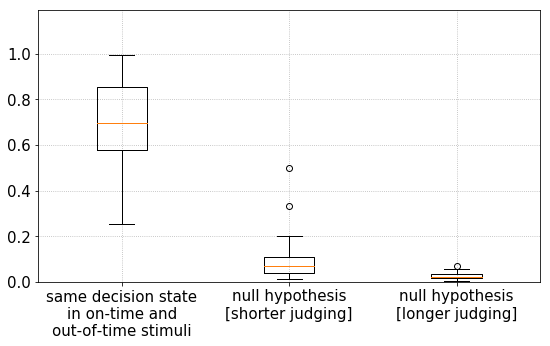

In [2]:
rndFn = "longer-shorter/34-setup-same-sensor-10k/rnd-2000.csv"

rnd_34_2000 = pd.read_csv(rndFn, index_col=0)
rnd_34_2000['probFsmLo']=1.0/rnd_34_2000.fsmLo
rnd_34_2000['probFsmSh']=1.0/rnd_34_2000.fsmSh
rnd_34_2000['probDecLo']=1.0/rnd_34_2000.decLo
rnd_34_2000['probDecSh']=1.0/rnd_34_2000.decSh

vis34_2000=pd.read_csv("longer-shorter/34-setup-same-sensor-10k/vis-1-50-2000.csv",
                  index_col=[0,1,2,3,4],dtype=int)

# average across trials for each Brain
visRep34=vis34_2000[vis34_2000.trials!=0]
visRep34=vis34_2000.sum(level=0)
visRep34['igProb']=visRep34.ig/visRep34.fa
plt.figure(figsize=(9,5))
plt.boxplot([visRep34.igProb.tolist(), rnd_34_2000.probFsmSh.tolist(), rnd_34_2000.probFsmLo.tolist()],
            labels=['same decision state\nin on-time and\nout-of-time stimuli','null hypothesis\n[shorter judging]',
                    'null hypothesis\n[longer judging]'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(which='both',linestyle=':')

plt.ylim(0,1.19)

#plt.savefig("longer-shorter/34-setup-same-sensor-10k/perceptions.pdf",bbox_inches='tight')

In [11]:
len(vis34_2000[vis34_2000.fa>=vis34_2000.ig])

238200

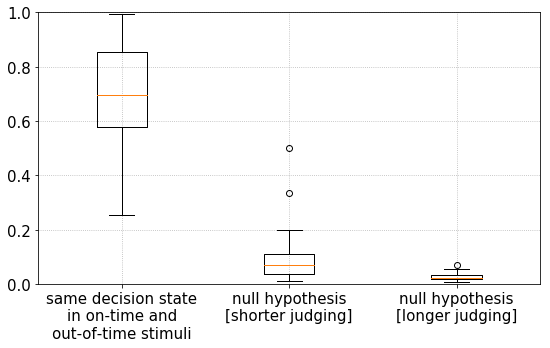

In [298]:
rndFn = "longer-shorter/34-setup-same-sensor-10k/rnd-2000.csv"

rnd_34_2000 = pd.read_csv(rndFn, index_col=0)
rnd_34_2000['probFsmLo']=1.0/rnd_34_2000.fsmLo
rnd_34_2000['probFsmSh']=1.0/rnd_34_2000.fsmSh
rnd_34_2000['probDecLo']=1.0/rnd_34_2000.decLo
rnd_34_2000['probDecSh']=1.0/rnd_34_2000.decSh

vis34_2000=pd.read_csv("longer-shorter/34-setup-same-sensor-10k/vis-1-50-2000.csv",
                  index_col=[0,1,2,3,4],dtype=int)

# average across trials for each Brain
visRep34=vis34_2000.sum(level=0)
visRep34['igProb']=visRep34.ig/visRep34.fa
plt.figure(figsize=(9,5))
plt.boxplot([visRep34.igProb.tolist(), rnd_34_2000.probFsmSh.tolist(), rnd_34_2000.probFsmLo.tolist()],
            labels=['same decision state\nin on-time and\nout-of-time stimuli','null hypothesis\n[shorter judging]',
                    'null hypothesis\n[longer judging]'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(which='both',linestyle=':')

plt.ylim(0,1)

plt.savefig("longer-shorter/34-setup-same-sensor-10k/perceptions.pdf",bbox_inches='tight')

MannwhitneyuResult(statistic=2494.0, pvalue=5.0285714228777366e-18)
MannwhitneyuResult(statistic=2500.0, pvalue=3.513960663101903e-18)
MannwhitneyuResult(statistic=2494.0, pvalue=4.935002373792817e-18)
MannwhitneyuResult(statistic=2500.0, pvalue=3.513960663101903e-18)


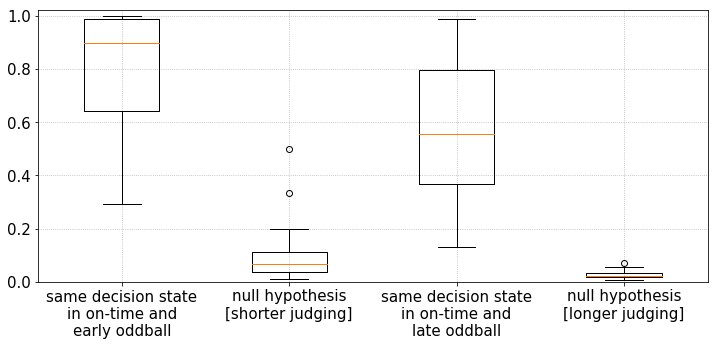

In [236]:
rndFn = "longer-shorter/34-setup-same-sensor-10k/rnd-2000.csv"

rnd_34_2000 = pd.read_csv(rndFn, index_col=0)
rnd_34_2000['probFsmLo']=1.0/rnd_34_2000.fsmLo
rnd_34_2000['probFsmSh']=1.0/rnd_34_2000.fsmSh
rnd_34_2000['probDecLo']=1.0/rnd_34_2000.decLo
rnd_34_2000['probDecSh']=1.0/rnd_34_2000.decSh

vis34_2000=pd.read_csv("longer-shorter/34-setup-same-sensor-10k/vis-1-50-2000.csv",
                  index_col=[0,1,2,3,4],dtype=int)


# average across trials for each Brain
visRep34=vis34_2000.sum(level=0)
visRep34['igProb']=visRep34.ig/visRep34.fa

# average across trials for each Brain, early oddballs 
vis34_2000_early=vis34_2000[vis34_2000.index.get_level_values('delay')<0]
vis34_2000_early_rep=vis34_2000_early.sum(level=0)
vis34_2000_early_rep['igProb']=vis34_2000_early_rep.ig/vis34_2000_early_rep.fa

# average across trials for each Brain, late oddballs 
vis34_2000_late=vis34_2000[vis34_2000.index.get_level_values('delay')>0]
vis34_2000_late_rep=vis34_2000_late.sum(level=0)
vis34_2000_late_rep['igProb']=vis34_2000_late_rep.ig/vis34_2000_late_rep.fa


plt.figure(figsize=(12,5))
plt.boxplot([vis34_2000_early_rep.igProb.tolist(), rnd_34_2000.probFsmSh.tolist(),
             vis34_2000_late_rep.igProb.tolist(), rnd_34_2000.probFsmLo.tolist()],
            labels=['same decision state\nin on-time and\nearly oddball','null hypothesis\n[shorter judging]',
                    'same decision state\nin on-time and\nlate oddball','null hypothesis\n[longer judging]']
            )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(which='both',linestyle=':')

plt.ylim(0,1.02)

print (stats.mannwhitneyu(visRep34.igProb.tolist(), rnd_34_2000.probFsmSh.tolist(),alternative='greater'))
print (stats.mannwhitneyu(visRep34.igProb.tolist(), rnd_34_2000.probFsmLo.tolist(),alternative='greater'))

print (stats.mannwhitneyu(vis34_2000_early_rep.igProb.tolist(), rnd_34_2000.probFsmSh.tolist(),alternative='greater'))
print (stats.mannwhitneyu(vis34_2000_late_rep.igProb.tolist(), rnd_34_2000.probFsmLo.tolist(),alternative='greater'))


plt.savefig("longer-shorter/34-setup-same-sensor-10k/perceptions-4-datapoints.pdf",bbox_inches='tight')

MannwhitneyuResult(statistic=4994.0, pvalue=1.3692561987640867e-23)


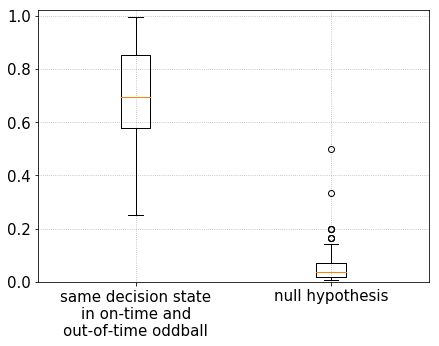

In [283]:
plt.figure(figsize=(7,5))
plt.boxplot([visRep34.igProb.tolist(), 
            rnd_34_2000.probFsmSh.tolist()+rnd_34_2000.probFsmLo.tolist()],
            labels=['same decision state\nin on-time and\nout-of-time oddball','null hypothesis']
           )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(which='both',linestyle=':')

plt.ylim(0,1.02)

print (stats.mannwhitneyu(visRep34.igProb.tolist(), rnd_34_2000.probFsmSh.tolist()+rnd_34_2000.probFsmLo.tolist(),
                          alternative='greater'))

plt.savefig("longer-shorter/34-setup-same-sensor-10k/perceptions-2-datapoints.pdf",bbox_inches='tight')

([<matplotlib.axis.XTick at 0x1a2df43b00>,
 <a list of 16 Text xticklabel objects>)

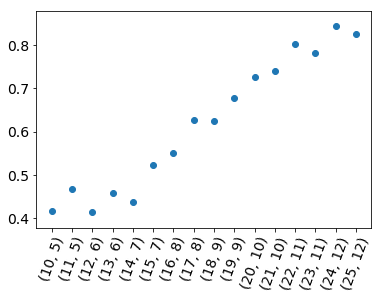

In [438]:
visTrial34=tmp.sum(level=[1,2])
visTrial34['igProb']=visTrial34.ig/visTrial34.fa
plt.scatter(xs,visTrial34.igProb.tolist())
plt.xticks(xs,[str(x) for x in patterns],rotation=70)

In [423]:
tmp=vis34_2000[vis34_2000.trials!=0].copy(deep=True)
temp=tmp.sum(level=0)
temp['igProb']=temp.ig/temp.fa
temp.igProb.describe()

count    50.000000
mean      0.702326
std       0.164266
min       0.252577
25%       0.578373
50%       0.695498
75%       0.853194
max       0.993991
Name: igProb, dtype: float64

In [424]:
visRep34.igProb.describe()

count    50.000000
mean      0.702326
std       0.164266
min       0.252577
25%       0.578373
50%       0.695498
75%       0.853194
max       0.993991
Name: igProb, dtype: float64

In [401]:
vis34_2000[vis34_2000.unseen!=0]
#len(vis34_2000[vis34_2000.index.get_level_values('delay')!=0])//4

trials  fa  ig  unseen
rep ioi tone ob delay                        
1   10  5    8  -4          4   4   0       4

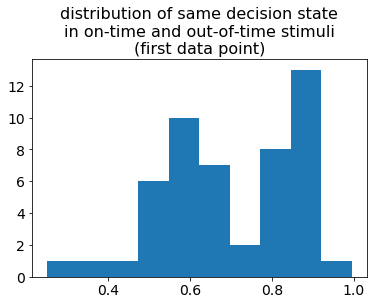

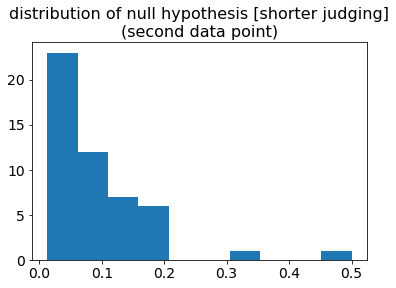

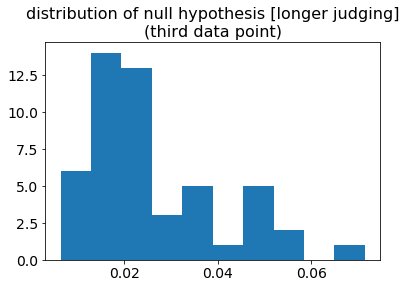

0.6954980701110731 0.06904761904761905 MannwhitneyuResult(statistic=2494.0, pvalue=5.0285714228777366e-18)
0.6954980701110731 0.022727272727272728 MannwhitneyuResult(statistic=2500.0, pvalue=3.513960663101903e-18)


In [3]:
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

plt.hist(visRep34.igProb.tolist())
plt.title("distribution of same decision state\nin on-time and out-of-time stimuli\n(first data point)",fontsize=16)
plt.show()

plt.title("distribution of null hypothesis [shorter judging]\n(second data point)",fontsize=16)
plt.hist(rnd_34_2000.probFsmSh.tolist())
plt.show()

plt.title("distribution of null hypothesis [longer judging]\n(third data point)",fontsize=16)
plt.hist(rnd_34_2000.probFsmLo.tolist())
plt.show()


print (np.median(visRep34.igProb), np.median(rnd_34_2000.probFsmSh), 
       stats.mannwhitneyu(visRep34.igProb, rnd_34_2000.probFsmSh, alternative='greater'))

print (np.median(visRep34.igProb), np.median(rnd_34_2000.probFsmLo), 
       stats.mannwhitneyu(visRep34.igProb, rnd_34_2000.probFsmLo, alternative='greater'))


In [6]:
print (np.median(visRep34.igProb), np.median(rnd_34_2000.probDecSh), 
       stats.mannwhitneyu(visRep34.igProb, rnd_34_2000.probDecSh, alternative='greater'))

print (np.median(visRep34.igProb), np.median(rnd_34_2000.probDecLo), 
       stats.mannwhitneyu(visRep34.igProb, rnd_34_2000.probDecLo, alternative='greater'))


0.6954980701110731 0.3333333333333333 MannwhitneyuResult(statistic=1569.0, pvalue=0.01372998652480033)
0.6954980701110731 0.08012820512820512 MannwhitneyuResult(statistic=2450.0, pvalue=6.507830697333204e-17)


{'whiskers': [<matplotlib.lines.Line2D at 0x1a22fb8e10>,
 'caps': [<matplotlib.lines.Line2D at 0x1a22fc2710>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a22fb8cc0>,
 'medians': [<matplotlib.lines.Line2D at 0x1a22fc2f60>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a22fca3c8>,
 'means': []}

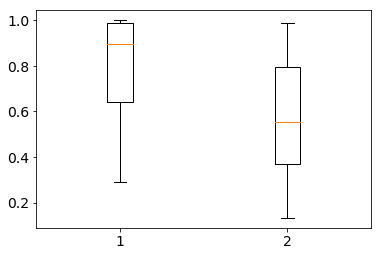

In [17]:
vis34_2000_early=vis34_2000[vis34_2000.index.get_level_values('delay')<0]
vis34_2000_early_rep=vis34_2000_early.sum(level=0)
vis34_2000_early_rep['igProb']=vis34_2000_early_rep.ig/vis34_2000_early_rep.fa

vis34_2000_late=vis34_2000[vis34_2000.index.get_level_values('delay')>0]
vis34_2000_late_rep=vis34_2000_late.sum(level=0)
vis34_2000_late_rep['igProb']=vis34_2000_late_rep.ig/vis34_2000_late_rep.fa

plt.boxplot([vis34_2000_early_rep.igProb, vis34_2000_late_rep.igProb])

In [18]:
vis34_2000_early_rep.describe()

trials           fa           ig     unseen     igProb
count    50.0    50.000000    50.000000  50.000000  50.000000
mean   6656.0  2165.700000  1761.920000   0.080000   0.811893
std       0.0   615.736866   660.544854   0.565685   0.211909
min    6656.0   246.000000    96.000000   0.000000   0.292354
25%    6656.0  2183.000000  1399.250000   0.000000   0.640090
50%    6656.0  2333.000000  1840.000000   0.000000   0.897673
75%    6656.0  2466.250000  2256.000000   0.000000   0.988087
max    6656.0  2872.000000  2686.000000   4.000000   1.000000

In [19]:
vis34_2000_late_rep.describe()

trials           fa           ig  unseen     igProb
count    50.0    50.000000    50.000000    50.0  50.000000
mean   6656.0  1528.220000   853.940000     0.0   0.564072
std       0.0   297.404095   444.413735     0.0   0.251573
min    6656.0   604.000000   198.000000     0.0   0.132903
25%    6656.0  1468.500000   570.500000     0.0   0.367857
50%    6656.0  1553.000000   781.000000     0.0   0.555546
75%    6656.0  1663.500000  1069.000000     0.0   0.796592
max    6656.0  2252.000000  2168.000000     0.0   0.987250

In [24]:
stats.mannwhitneyu(vis34_2000_early_rep.igProb, vis34_2000_late_rep.igProb, alternative='greater')

MannwhitneyuResult(statistic=1973.0, pvalue=3.1458611752867456e-07)

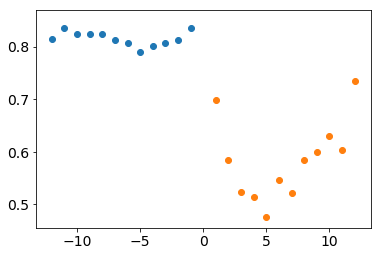

In [33]:
vis34_2000_early_onset=vis34_2000_early.sum(level=4)
vis34_2000_early_onset['igProb']=vis34_2000_early_onset.ig/vis34_2000_early_onset.fa

vis34_2000_late_onset=vis34_2000_late.sum(level=4)
vis34_2000_late_onset['igProb']=vis34_2000_late_onset.ig/vis34_2000_late_onset.fa

plt.scatter(vis34_2000_early_onset.index,vis34_2000_early_onset.igProb)
plt.scatter(vis34_2000_late_onset.index,vis34_2000_late_onset.igProb)

## 3-2) Information shared between Perception and 
## i)   oddball tone length
## ii)  oddball tone onset
## iii) oddball tone end time

In [ ]:
import pandas as pd
import numpy as np
from math import *
import sys

def entropy(l):
    h=0
    N=len(l)
    for i in set(l):
        pi = l.count(i)/N
        if (pi!=0 and pi!=1):
            h += -pi*log(pi,2)
    return(h)


def condEnt(y,x):#h(y|x)
    xy=list(zip(x,y))
    h=0
    for ij in set(xy):
        pij = xy.count(ij)/len(xy)
        pj = x.count(ij[0])/len(x)
        h += -pij*log(pij/pj, 2)
    return h


ad=sys.argv[1]
repInit = int(sys.argv[2])
repFin = int(sys.argv[3])
outFn = sys.argv[4]
gen=2000

ind=[]
reps=range(repInit,repFin+1)
temp = pd.read_csv(ad+"tests_"+str(repInit)+"_"+str(gen)+".csv")
temp['pattern'] = list(zip(temp.ioi,temp.tone))
patterns=temp.pattern.unique()

index=pd.MultiIndex.from_product([reps, patterns],names=['rep','pattern'])
inf = pd.DataFrame(index=index, columns=['H(length)','H(onset)','H(endPoint)','H(decision)','I(dec:len)','I(dec:ons)','I(dec:end)'])

for rep in reps:
    print (rep)
    tst = pd.read_csv(ad+"tests_"+str(rep)+"_"+str(gen)+".csv")
    tst['decState'] = tst.apply(lambda row: row.vid.split(',')[(row.obPos+1)*row.ioi], axis=1)
    tst['endPoint'] = tst.obTone+tst.obDelay
    tst.drop(['vid','states'], inplace=True, axis=1)

    for pat in patterns:
        ioi,tone=pat

        tst_ioi = tst[(tst.ioi==ioi) & (tst.tone==tone)]
        #tst_sh=tst_ioi[(tst_ioi.endPoint>0) & (tst_ioi.endPoint<tone) & (tst_ioi.obDelay<=0)]
        #tst_lo=tst_ioi[(tst_ioi.endPoint>0) & (tst_ioi.endPoint<tone) & (tst_ioi.obDelay<=0)]

        tst_all=tst_ioi[tst_ioi.endPoint>0] #all onsets, all oddball durations as long as part of oddball occur during interval
        tst_sh=tst_ioi[(tst_ioi.endPoint>0) & (tst_ioi.obTone<tst_ioi.tone)]

        length=tst_all.obTone.tolist()#.decState.unique()
        onset=tst_all.obDelay.tolist()
        endpoints=tst_all.endPoint.tolist()
        decision=tst_all.decState.tolist()

        hLen = entropy(length)
        hOns = entropy(onset)
        hEnd = entropy(endpoints)
        hDec = entropy(decision)

        I_dec_len = hDec - condEnt(decision,length)
        I_dec_ons = hDec - condEnt(decision,onset)
        I_dec_end = hDec - condEnt(decision,endpoints)

        inf.loc[rep, pat] = [hLen, hOns, hEnd, hDec, I_dec_len, I_dec_ons, I_dec_end]#[I,hY,hYX,N,x.count(0)/N,x.count(1)/N,len(set(y))]
        
    del tst_ioi

inf.to_csv(outFn)


In [238]:
infLength34 = pd.read_csv("longer-shorter/34-setup-same-sensor-10k/inf-2000.csv",index_col=[0,1],
                          converters={'pattern':ast.literal_eval})

infM34 = infLength34.mean(level=1)
infE34 = infLength34.sem(level=1)
infM34


H(length)  H(onset)  H(endPoint)  H(decision)  I(dec:len)  \
pattern                                                               
(10, 5)    3.143866  3.546564     3.143866     3.772623    1.409857   
(11, 5)    3.302895  3.752135     3.302895     3.772997    1.320011   
(12, 6)    3.433276  3.838883     3.433276     3.728777    1.285401   
(13, 6)    3.564788  4.008814     3.564788     3.654466    1.183092   
(14, 7)    3.674228  4.081570     3.674228     3.616657    1.144770   
(15, 7)    3.786346  4.226437     3.786346     3.567356    1.005967   
(16, 8)    3.880643  4.289106     3.880643     3.478754    0.963256   
(17, 8)    3.978355  4.415374     3.978355     3.418990    0.847398   
(18, 9)    4.061192  4.470422     4.061192     3.344421    0.820732   
(19, 9)    4.147779  4.582334     4.147779     3.278917    0.747523   
(20, 10)   4.221640  4.631420     4.221640     3.208881    0.710239   
(21, 10)   4.299378  4.731914     4.299378     3.137314    0.661602   
(22, 11)   4.366018  4.776205     4.366018     3.083350    0.613743   
(23, 11)   4.436547  4.867400     4.436547     3.017474    0.594360   
(24, 12)   4.497254  4.907752     4.497254     2.953885    0.534144   
(25, 12)   4.561798  4.991224     4.561798     2.877049    0.531103   

          I(dec:ons)  I(dec:end)  
pattern                           
(10, 5)     1.727672    1.774238  
(11, 5)     1.657957    1.802193  
(12, 6)     1.516955    1.790212  
(13, 6)     1.425521    1.804927  
(14, 7)     1.357231    1.821437  
(15, 7)     1.220012    1.817452  
(16, 8)     1.155392    1.825689  
(17, 8)     1.058980    1.829992  
(18, 9)     1.022737    1.838325  
(19, 9)     0.974651    1.844532  
(20, 10)    0.914776    1.834507  
(21, 10)    0.896825    1.837850  
(22, 11)    0.830925    1.830985  
(23, 11)    0.837370    1.818143  
(24, 12)    0.751046    1.800772  
(25, 12)    0.772370    1.793930

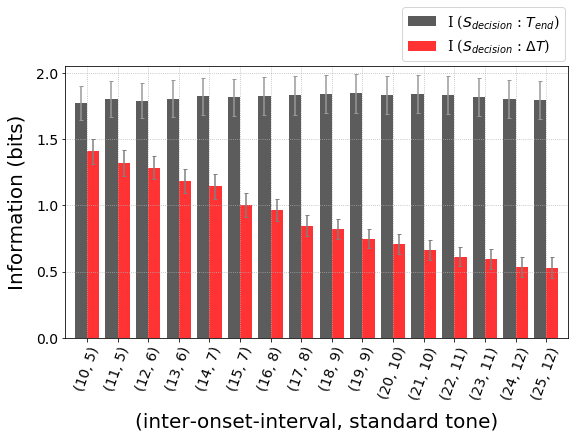

In [16]:
import matplotlib.font_manager as font_manager

plt.figure(figsize=(9,5))

patterns=infM34.index.tolist()
xs=range(len(patterns))

plt.bar([x-0.2 for x in xs], infM34['I(dec:end)'], yerr=[e*2 for e in infE34['I(dec:end)']],
        color='0.2', alpha=0.8, width=0.4, capsize=2, ecolor='0.6', label='I ($S_{decision}$ : $T_{end}$)')
plt.bar([x+0.2 for x in xs], infM34['I(dec:len)'], yerr=[e*2 for e in infE34['I(dec:len)']],
        color='red', alpha=0.8, width=0.4, capsize=2, ecolor='0.5', label='I ($S_{decision}$ : $\Delta T$)')

plt.grid(which='both',linestyle=':')

plt.xlabel('(inter-onset-interval, standard tone)',fontsize=20,labelpad=10)
plt.ylabel('Information (bits)',fontsize=20, labelpad=10)
xPos=[x for x in xs]
plt.xticks(xPos,patterns,fontsize=14,rotation=70,position=(0,0),ha='center')
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=14)

plt.ylim(0,2.05)
plt.xlim(-0.7,15.7)

font = font_manager.FontProperties(family='serif', weight='normal', style='normal', size=14)
plt.legend(loc=[0.67,1.02], prop=font)
                 
plt.savefig("longer-shorter/34-setup-same-sensor-10k/information-perception.pdf",bbox_inches='tight')

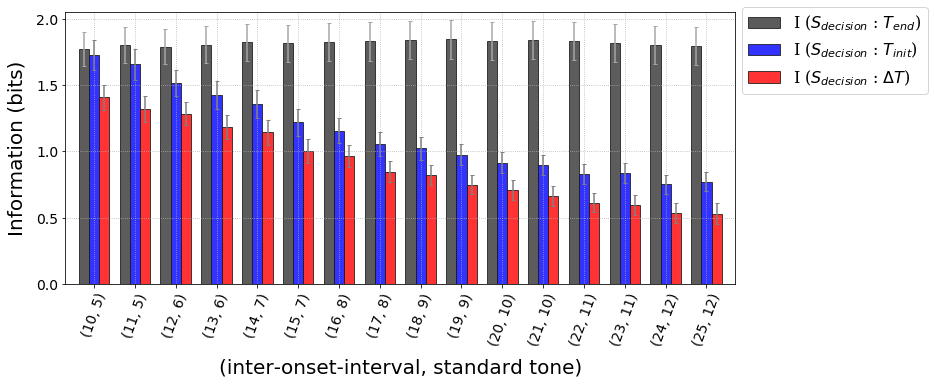

In [247]:
import matplotlib.font_manager as font_manager

plt.figure(figsize=(12,5))

patterns=infM34.index.tolist()
xs=range(len(patterns))

plt.bar([x-0.25 for x in xs], infM34['I(dec:end)'], yerr=[e*2 for e in infE34['I(dec:end)']],
        color='0.2',edgecolor='0.1', alpha=0.8, width=0.25, capsize=2, ecolor='0.65', label='I ($S_{decision}$ : $T_{end}$)')
plt.bar([x+0.0 for x in xs], infM34['I(dec:ons)'], yerr=[e*2 for e in infE34['I(dec:ons)']],
        color='b',edgecolor='0.1', alpha=0.8, width=0.25, capsize=2, ecolor='0.5', label='I ($S_{decision}$ : $T_{init}$)')
plt.bar([x+0.25 for x in xs], infM34['I(dec:len)'], yerr=[e*2 for e in infE34['I(dec:len)']],
        color='r',edgecolor='0.1', alpha=0.8, width=0.25, capsize=2, ecolor='0.5', label='I ($S_{decision}$ : $\Delta T$)')

plt.grid(which='both',linestyle=':')

plt.xlabel('(inter-onset-interval, standard tone)',fontsize=20,labelpad=10)
plt.ylabel('Information (bits)',fontsize=20, labelpad=10)
xPos=[x for x in xs]
plt.xticks(xPos,patterns,fontsize=14,rotation=70,position=(0,0),ha='center')
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=14)

plt.ylim(0,2.05)
plt.xlim(-0.7,15.7)

font = font_manager.FontProperties(family='serif', weight='normal', style='normal', size=16)
plt.legend(loc=[1.01,0.70], prop=font)
                 
plt.savefig("longer-shorter/34-setup-same-sensor-10k/information-perception-supp.pdf",bbox_inches='tight')

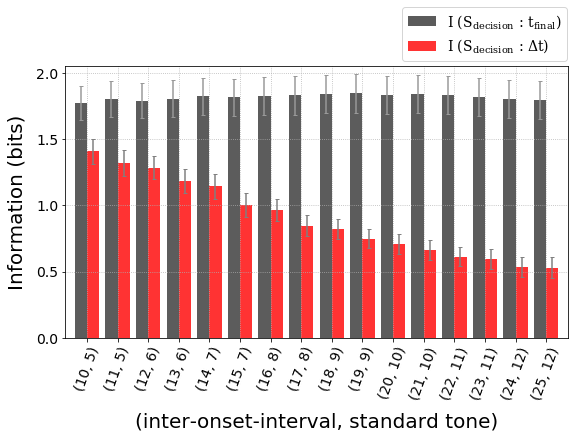

In [460]:
import matplotlib.font_manager as font_manager

plt.figure(figsize=(9,5))

patterns=infM34.index.tolist()
xs=range(len(patterns))

plt.bar([x-0.2 for x in xs], infM34['I(dec:end)'], yerr=[e*2 for e in infE34['I(dec:end)']],
        color='0.2', alpha=0.8, width=0.4, capsize=2, ecolor='0.6', label='I ($S_{decision}$ : $t_{final}$)')
plt.bar([x+0.2 for x in xs], infM34['I(dec:len)'], yerr=[e*2 for e in infE34['I(dec:len)']],
        color='red', alpha=0.8, width=0.4, capsize=2, ecolor='0.5', label='I ($S_{decision}$ : $\Delta t$)')

plt.grid(which='both',linestyle=':')

plt.xlabel('(inter-onset-interval, standard tone)',fontsize=20,labelpad=10)
plt.ylabel('Information (bits)',fontsize=20, labelpad=10)
xPos=[x for x in xs]
plt.xticks(xPos,patterns,fontsize=14,rotation=70,position=(0,0),ha='center')
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=14)

plt.ylim(0,2.05)
plt.xlim(-0.7,15.7)

font = font_manager.FontProperties(family='serif', weight='normal', style='normal', size=14)
plt.legend(loc=[0.67,1.02], prop=font)
                 
plt.savefig("longer-shorter/34-setup-same-sensor-10k/information-perception.pdf",bbox_inches='tight')

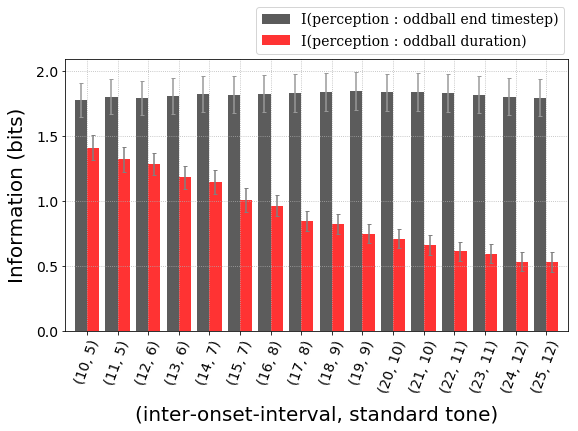

In [447]:
import matplotlib.font_manager as font_manager

plt.figure(figsize=(9,5))

patterns=infM34.index.tolist()
xs=range(len(patterns))

plt.bar([x-0.2 for x in xs], infM34['I(dec:end)'], yerr=[e*2 for e in infE34['I(dec:end)']],
        color='0.2', alpha=0.8, width=0.4, capsize=2, ecolor='0.6', label='I(perception : oddball end timestep)')
plt.bar([x+0.2 for x in xs], infM34['I(dec:len)'], yerr=[e*2 for e in infE34['I(dec:len)']],
        color='red', alpha=0.8, width=0.4, capsize=2, ecolor='0.5', label='I(perception : oddball duration)')

plt.grid(which='both',linestyle=':')

plt.xlabel('(inter-onset-interval, standard tone)',fontsize=20,labelpad=10)
plt.ylabel('Information (bits)',fontsize=20, labelpad=10)
xPos=[x for x in xs]
plt.xticks(xPos,patterns,fontsize=14,rotation=70,position=(0,0),ha='center')
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=14)

#plt.ylim(0,2.5)
plt.xlim(-0.7,15.7)

font = font_manager.FontProperties(family='serif', weight='normal', style='normal', size=14)
plt.legend(loc=[0.38,1.02], prop=font)
                 
plt.savefig("longer-shorter/34-setup-same-sensor-10k/information-perception.pdf",bbox_inches='tight')

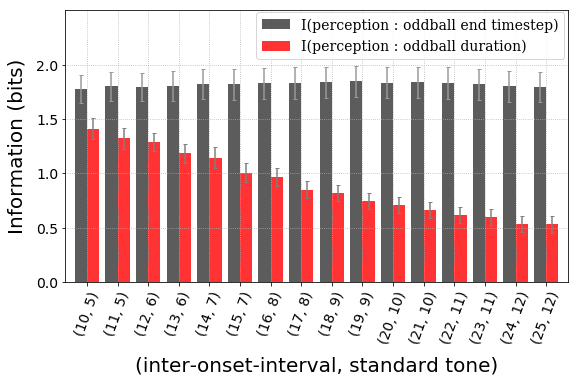

In [300]:
import matplotlib.font_manager as font_manager

plt.figure(figsize=(9,5))

patterns=infM34.index.tolist()
xs=range(len(patterns))

plt.bar([x-0.2 for x in xs], infM34['I(dec:end)'], yerr=[e*2 for e in infE34['I(dec:end)']],
        color='0.2', alpha=0.8, width=0.4, capsize=2, ecolor='0.6', label='I(perception : oddball end timestep)')
plt.bar([x+0.2 for x in xs], infM34['I(dec:len)'], yerr=[e*2 for e in infE34['I(dec:len)']],
        color='red', alpha=0.8, width=0.4, capsize=2, ecolor='0.5', label='I(perception : oddball duration)')

plt.grid(which='both',linestyle=':')

plt.xlabel('(inter-onset-interval, standard tone)',fontsize=20,labelpad=10)
plt.ylabel('Information (bits)',fontsize=20, labelpad=10)
xPos=[x for x in xs]
plt.xticks(xPos,patterns,fontsize=14,rotation=70,position=(0,0),ha='center')
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=14)

plt.ylim(0,2.5)
plt.xlim(-0.7,15.7)

font = font_manager.FontProperties(family='serif', weight='normal', style='normal', size=14)
plt.legend(loc=[0.38,0.82], prop=font)
                 
plt.savefig("longer-shorter/34-setup-same-sensor-10k/information-perception.pdf",bbox_inches='tight')

## 3-2) Experiences (sequence of Brain states leading to decision)

In [12]:
def normalize(row, col):
    if row.delay>0:
        return row[col]/row.ioi
    else:
        return row[col]/(row.ioi+abs(row.delay))
    
def readSeqFile(fn):
    seq=pd.read_csv(fn,usecols=[1,2,3,4,5,6,7,8],dtype=int)#,index_col=[0,1,2,3,4,5]
    
    ## normalized depth and similarity
    seq['normDepth']=seq.apply(normalize, axis=1, args=('depth',))
    seq['normSimilarity']=seq.apply(normalize, axis=1, args=('similarity',))
    seq.set_index(['rep','ioi','tone','ob','delay','pos'],inplace=True)
    
    ## average across oddball position
    seqPos = seq.mean(level=[0,1,2,3,4])
    return seqPos

In [42]:
def plotSeqHist(seq,col):
    
    var = seq[col].tolist()
    delta=0.1
    weights = np.ones_like(var)/float(len(var))
    bins = np.arange(0,1+delta,delta)

    plt.figure(figsize=(7,4))
    plt.grid(which='both',linestyle=':')#'--',dashes=(4,2),zorder=0)
    r = plt.hist(var,bins=bins,weights=weights,edgecolor='0.8',zorder=3,color='0.4',alpha=0.8, align='mid')#color=u'#1f77b4'
    #ax[0].set_yticks(np.arange(0,0.16,0.02))
    plt.tick_params(labelsize=14)
    #plt.xlabel('normalized sequence length',fontsize=20)
    plt.ylabel('trials percentage',fontsize=20)
    #plt.set_title('sequence similarity depth', fontsize=18)
    return r

In [13]:
seq34_2000=pd.read_csv("longer-shorter/34-setup-same-sensor-10k/seq-1-50-2000.csv",index_col=0)
seq34_2000['normDepth']=seq34_2000.apply(normalize, axis=1, args=('depth',))
seq34_2000['normSimilarity']=seq34_2000.apply(normalize, axis=1, args=('similarity',))
seq34_2000.set_index(['rep','ioi','tone','ob','delay','pos'],inplace=True)
seq34_2000.sort_index(inplace=True)
seq34_2000[seq34_2000.normDepth==0]

Empty DataFrame
Columns: [depth, similarity, normDepth, normSimilarity]
Index: []

In [56]:
len(seq34_2000[seq34_2000.normDepth==1])/len(seq34_2000)

0.006246511663468228

In [55]:
len(seq34_2000)

130793

(array([  618.,  3715., 10344., 16715., 26881., 30436., 24856., 13990.,
         2625.,   613.]),
 array([-23. , -18.6, -14.2,  -9.8,  -5.4,  -1. ,   3.4,   7.8,  12.2,
         16.6,  21. ]),
 <a list of 10 Patch objects>)

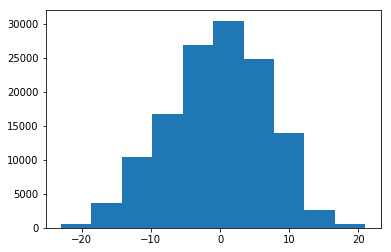

In [248]:
seq34_2000['endPoint']=0
seq34_2000['endPoint']=seq34_2000.apply(lambda row: 
                                        row.index.get_level_values('ob')+row.index.get_level_values('delay'),
                                        axis=0)

plt.hist(seq34_2000.depth-seq34_2000.endPoint)#, bins=range(-15,15,4))

In [135]:
seq34_2000['endDepth']=0

seq34_2000['endDepth']=seq34_2000.apply(lambda row: 
                                        row.index.get_level_values('ioi')-
                                        (row.index.get_level_values('ob')+row.index.get_level_values('delay')),
                                        axis=0)
# seq34_2000['depthMinus']=seq34_2000.apply(lambda row: 
#                                           row.index.get_level_values('ioi')-row.endPoint,axis=1)

seq34_2000

depth  similarity  normDepth  normSimilarity  \
rep ioi tone ob delay pos                                                 
1   10  5    6  -4    4        1           1   0.071429        0.071429   
                      5        1           1   0.071429        0.071429   
                      6        1           1   0.071429        0.071429   
                      7        1           1   0.071429        0.071429   
    11  5    5  -3    4        3           3   0.214286        0.214286   
                      5        3           3   0.214286        0.214286   
                      6        3           3   0.214286        0.214286   
                      7        3           3   0.214286        0.214286   
                -1    4        1           1   0.083333        0.083333   
                      5        1           1   0.083333        0.083333   
                      6        1           1   0.083333        0.083333   
                      7        1           1   0.083333        0.083333   
             6  -5    4        3           3   0.187500        0.187500   
                      5        3           3   0.187500        0.187500   
                      6        3           3   0.187500        0.187500   
                      7        3           3   0.187500        0.187500   
                -2    4        1           1   0.076923        0.076923   
                      5        1           1   0.076923        0.076923   
                      6        1           1   0.076923        0.076923   
                      7        1           1   0.076923        0.076923   
             7  -5    4        3           3   0.187500        0.187500   
                      5        3           3   0.187500        0.187500   
                      6        3           3   0.187500        0.187500   
                      7        3           3   0.187500        0.187500   
                -3    4        1           1   0.071429        0.071429   
                      5        1           1   0.071429        0.071429   
                      6        1           1   0.071429        0.071429   
                      7        1           1   0.071429        0.071429   
             9  -5    4        1           1   0.062500        0.062500   
                      5        1           1   0.062500        0.062500   
...                          ...         ...        ...             ...   
50  25  12   21 -10   6       15          15   0.428571        0.428571   
                      7       15          15   0.428571        0.428571   
                -9    4       15          16   0.441176        0.470588   
                      5       15          16   0.441176        0.470588   
                      6       15          16   0.441176        0.470588   
                      7       15          16   0.441176        0.470588   
             22 -12   4       15          15   0.405405        0.405405   
                      5       15          15   0.405405        0.405405   
                      6       15          15   0.405405        0.405405   
                      7       15          15   0.405405        0.405405   
                -11   4       15          15   0.416667        0.416667   
                      5       15          15   0.416667        0.416667   
                      6       15          15   0.416667        0.416667   
                      7       15          15   0.416667        0.416667   
                -10   4       15          15   0.428571        0.428571   
                      5       15          15   0.428571        0.428571   
                      6       15          15   0.428571        0.428571   
                      7       15          15   0.428571        0.428571   
             23 -12   4       15          15   0.405405        0.405405   
                      5       15          15   0.405405        0.405405   
                      6       15          15   0.405

In [64]:
np.sum([n>0 for n in list(seq34_2000.depth-seq34_2000.endDepth)])/len(list(seq34_2000.depth-seq34_2000.endDepth))

0.4589007056952589

(array([0.00024466, 0.00716399, 0.01954233, 0.05112659, 0.12457853,
        0.08180101, 0.04568287, 0.02704273, 0.02256237, 0.02349514,
        0.0089225 , 0.00675113, 0.00942711, 0.01071158, 0.03368682,
        0.06835993, 0.11724634, 0.10038764, 0.07854396, 0.05735781,
        0.03650807, 0.02558241, 0.01513078, 0.01129265, 0.00852492,
        0.00538255, 0.00188083, 0.00075692, 0.00030583]),
 array([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
         -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11,  12,  13,  14]),
 <a list of 29 Patch objects>)

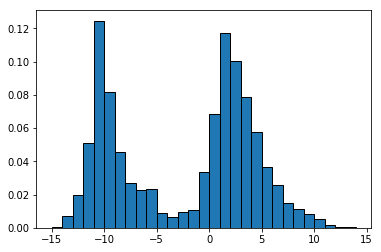

In [144]:
plt.hist(seq34_2000.depth-seq34_2000.endDepth,bins=range(-15,15),edgecolor='k',density=True)

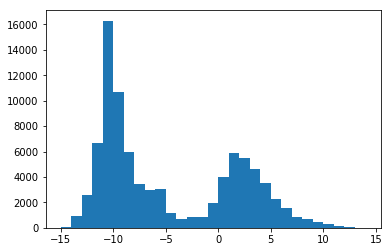

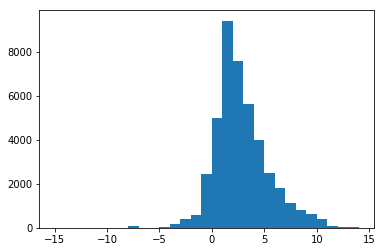

In [47]:
seq34_2000_early=seq34_2000[seq34_2000.index.get_level_values('delay')<0]
seq34_2000_late=seq34_2000[seq34_2000.index.get_level_values('delay')>0]
plt.hist(seq34_2000_early.depth-seq34_2000_early.endDepth, bins=range(-15,15))
plt.show()
plt.hist(seq34_2000_late.depth-seq34_2000_late.endDepth, bins=range(-15,15))
plt.show()

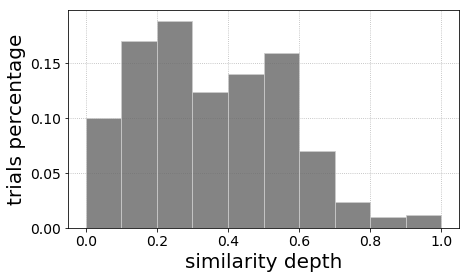

In [529]:
## average across oddball position
seq34Pos = seq34_2000.mean(level=[0,1,2,3,4])
seq34Pos

r1=plotSeqHist(seq34Pos,'normDepth')
plt.xlabel('similarity depth',fontsize=20)
plt.savefig("longer-shorter/34-setup-same-sensor-10k/similarity-depth.pdf",bbox_inches='tight')

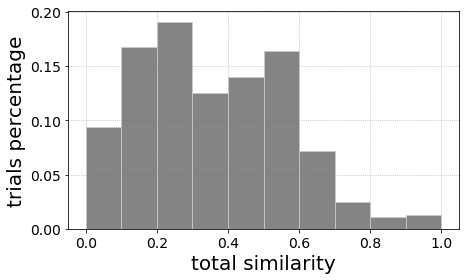

In [302]:
r2=plotSeqHist(seq34Pos,'normSimilarity')
plt.xlabel('total similarity',fontsize=20)
plt.savefig("longer-shorter/34-setup-same-sensor-10k/total-similarity.pdf",bbox_inches='tight')

In [44]:
r1[0]-r2[0]

array([ 0.00671435,  0.00248139, -0.0020143 , -0.00105094,  0.00046709,
       -0.00379507, -0.00119691, -0.00055466, -0.00037951, -0.00067143])

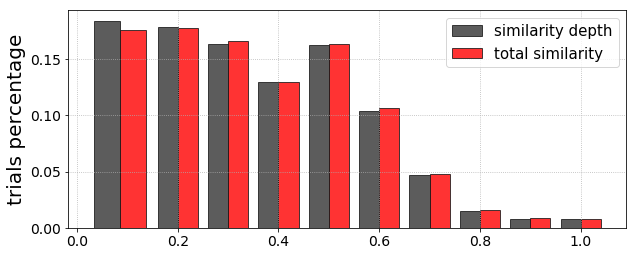

In [289]:
plt.figure(figsize=(10,4))
plt.grid(which='both',linestyle=':')#'--',dashes=(4,2),zorder=0)

delta=0.1
bins = [0.02,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05]#np.arange(0.02,1.06,delta)

depSim = seq34Pos.normDepth.tolist()
w_d = np.ones_like(depSim)/float(len(depSim))

totSim = seq34Pos.normSimilarity.tolist()
w_t = np.ones_like(totSim)/float(len(totSim))

plt.hist([depSim,totSim],bins=bins,weights=[w_d,w_t],zorder=1,color=['0.2','red'],edgecolor='0.1',alpha=0.8,
         label=['similarity depth','total similarity'])

plt.tick_params(labelsize=14)
#plt.xlabel('normalized sequence length',fontsize=20)
plt.ylabel('trials percentage',fontsize=20)
plt.legend(fontsize=15)#,bbox_to_anchor=[1,1])

plt.savefig("longer-shorter/34-setup-same-sensor-10k/sequences-similarity-two-measures.pdf",
            bbox_inches='tight')

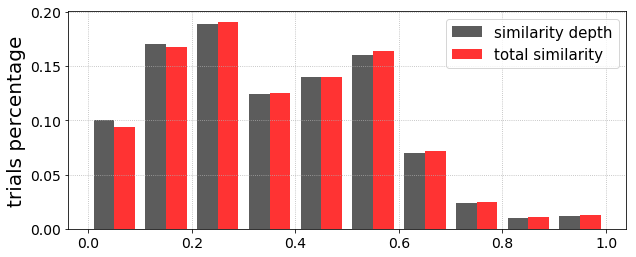

In [146]:
seq34Pos = seq34_2000.mean(level=[0,1,2,3,4])
plt.figure(figsize=(10,4))
plt.grid(which='both',linestyle=':')#'--',dashes=(4,2),zorder=0)

delta=0.1
bins = np.arange(0,1+delta,delta)

depSim = seq34Pos.normDepth.tolist()
w_d = np.ones_like(depSim)/float(len(depSim))

totSim = seq34Pos.normSimilarity.tolist()
w_t = np.ones_like(totSim)/float(len(totSim))

plt.hist([depSim,totSim],bins=bins,weights=[w_d,w_t],zorder=1,color=['0.2','red'],alpha=0.8,
         label=['similarity depth','total similarity'])

plt.tick_params(labelsize=14)
#plt.xlabel('normalized sequence length',fontsize=20)
plt.ylabel('trials percentage',fontsize=20)
plt.legend(fontsize=15)#,bbox_to_anchor=[1,1])

plt.savefig("longer-shorter/34-setup-same-sensor-10k/sequences-similarity-two-measures.pdf",bbox='tight_layout')

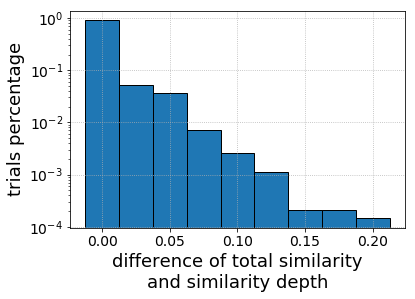

In [291]:
seq34Pos['ns-nd']=seq34Pos.normSimilarity-seq34Pos.normDepth

ns_nd = seq34Pos['ns-nd'].tolist()
weights = np.ones_like(ns_nd)/float(len(ns_nd))

plt.figure(figsize=(6,4))
plt.hist(ns_nd,weights=weights,edgecolor='k',bins=np.arange(-0.0125,0.22,0.025))
plt.yscale('log')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('difference of total similarity\nand similarity depth',fontsize=18)
plt.ylabel('trials percentage',fontsize=18)

plt.grid(which='major',linestyle=':')

plt.savefig("longer-shorter/34-setup-same-sensor-10k/sequences-difference.pdf",bbox_inches='tight')

# 4) State-Space Statistics

In [ ]:
import numpy as np
import sys
import pandas as pd
import itertools

def findCycle(l, ioi):
    up = len(l)
    for p in range(1, up+1):
        cycle = True
        for i in range(0, len(l)-p):
            if (l[i]!=l[i+p]):
                cycle=False
                break
        if cycle:
            break
    #print (p)
    #print (cycle, end='\t')
    return p

def fillLoopsDf(ad,gen,patterns,reps):
    loops=pd.DataFrame(columns=['count'])

    dfs = list()
    for rep in reps:
        dfs.append( pd.read_csv(ad+"tests_"+str(rep)+"_"+str(gen)+".csv", index_col=[0,1,2,3,4]) )

    #for tone in tones:
    for (ioi,tone) in patterns:
        lTone=list()
        for rep in range(len(reps)):
            df = dfs[rep] #= pd.read_csv(ad+"tests_"+str(rep)+"_2000.csv", index_col=[0,1,2,3,4])
            #ioi=tone*2
            vid=df.loc[ioi,tone,tone,0,7].vid
            v=[int(s) for s in vid.split(',')]
            v=v[4*ioi:]
            lTone.append(findCycle(v, ioi))
        loops.loc[ioi]=[lTone]
        
    del dfs
    return loops

def svStats(ad,reps,gen):
    df=pd.read_csv(ad+"tests_"+str(reps[0])+"_"+str(gen)+".csv")
    df['pattern']=list(zip(df.ioi,df.tone))
    patterns=df.pattern.unique()
    del df

    vis=pd.DataFrame(columns=['total','totTrain','trainPerTrial','totEntrain','entrainPerTrial',
                              'shDecPerTrial','LoDecPerTrial'],
                     index=reps)
    
    for rep in reps:
        df=pd.read_csv(ad+"tests_"+str(rep)+"_"+str(gen)+".csv")#,index_col=[0,1,2,3,4])
        df['decState']=df.apply(lambda row: int(row.vid.split(',')[(row.obPos+1)*row.ioi]), axis=1)
        df.set_index(['ioi','tone','obTone','obDelay','obPos'], inplace=True)
        print (rep, end=" ")
        sys.stdout.flush()
        vidTot=[int(s) for v in df.vid for s in v.split(',')]
        total=len(set(vidTot))
        dfTrain=df[df.index.get_level_values('obDelay')==0]
        vidTotTrain=[int(s) for v in dfTrain.vid for s in v.split(',')]

        totTrain=len(set(vidTotTrain))
        trainPerTrial=list()
        entrainPerTrial=list()
        vidTotEntrain=list()
        loDecPerTrial=list()
        shDecPerTrial=list()
        for pat in patterns:
            #print (pat)
            ioi,tone=pat
            vidTrainTr=[int(s) for v in dfTrain.loc[(ioi,tone)].vid for s in v.split(',')]
            trainPerTrial.append(len(set(vidTrainTr)))
            vidEntrain=[int(s) for s in dfTrain.loc[ioi,tone,tone,0,4].vid.split(',')[ioi*4:]]
            entrainPerTrial.append(len(set(vidEntrain)))
            vidTotEntrain=vidTotEntrain+list(set(vidEntrain))
            vidTotEntrain=list(set(vidTotEntrain))
            
            decs = list(set(dfTrain.loc[ioi,tone].decState.tolist()))
            #print (decs)
            
            loDec=list(filter(lambda n: n%2==1, decs))
            shDec=list(filter(lambda n: n%2==0, decs))
            
            loDecPerTrial.append(len(loDec))
            shDecPerTrial.append(len(shDec))
            #print (loDec)
            
        totEntrain=len(set(vidTotEntrain))

        vis.loc[rep]=[total,totTrain,str(trainPerTrial),totEntrain,str(entrainPerTrial),str(shDecPerTrial),str(loDecPerTrial)]
        del df
    
    print ("\n")
    return vis


# 1) loops
ad = sys.argv[1]
loopOutFn = sys.argv[2]
stOutFn = sys.argv[3]
gen = sys.argv[4]
repInit=int(sys.argv[5])
repFin=int(sys.argv[6])
reps = range(repInit, repFin+1)

temp=pd.read_csv(ad+"tests_"+str(repInit)+"_"+str(gen)+".csv",index_col=[0,1])
patterns=list(temp.index.unique())
del temp

print ("cycle detection ...")
loops = fillLoopsDf(ad, gen, patterns, reps)
print ("writing loop file:",loopOutFn)
loops.to_csv(loopOutFn)

# 2) state stats
print ("state statistics ...")
vis=svStats(ad,reps,gen)
print ("writing stat file:",stOutFn)
vis.to_csv(stOutFn)

In [68]:
from collections import Counter

def plotScatters(df):
    dic=dict()
    plt.figure(figsize=(10,6))
    for ind, ioi in enumerate(df.index):
        l = df['count'].loc[ioi]
        d = dict(Counter(l))
        dic[ioi]=d
        loopSz, cnt = [int(k) for k in list(d.keys())], [int(v) for v in list(d.values())]
        xs = [int(ioi)]*(len(d))
        #print (xs,'\t', loopSz, cnt)
        c=np.arange(16)
        plt.scatter(xs, loopSz, s=[c*15 for c in cnt], edgecolor=(0,0,0,1.0), color=(0.3,0.3,0.3,0.4))
        
    return dic

## 4-1) Loop Lengths in Entrainment (in the absence of the oddball tone)

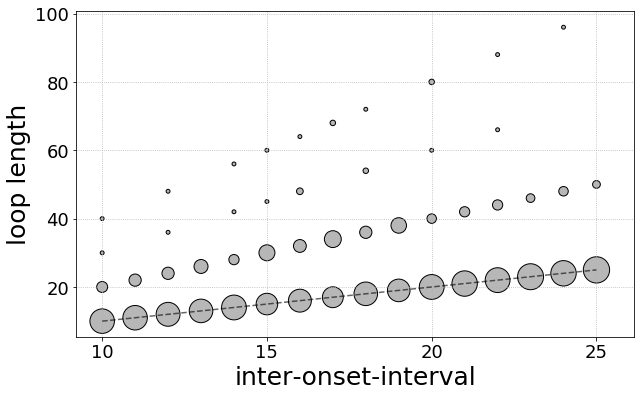

In [21]:
loop34_2000=pd.read_csv("longer-shorter/34-setup-same-sensor-10k/loops-2000.csv",
                        index_col=0,
                        converters={"count":ast.literal_eval})
plotScatters(loop34_2000)

iois = range(10,26)
plt.plot(iois,iois,'--',color='k',alpha=0.6,markersize=4)#,zorder=-1)

plt.xlabel('inter-onset-interval', fontsize=25)
plt.ylabel('loop length', fontsize=25)
plt.xticks(range(10,26,5),fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(0,120)
plt.grid(which='both',linestyle=':')
#plt.savefig("longer-shorter/34-setup-same-sensor-10k/loop-lengths.pdf",bbox_inches='tight')

In [38]:
dic=dict()
l=[]
for ioi in loop34_2000.index:
    dic[ioi]=dict(Counter(loop34_2000['count'].loc[ioi]))
    l.append(dic[ioi][ioi]/50)
#dic
print (l)
np.mean(l),np.std(l),stats.sem(l)

[0.8, 0.8, 0.76, 0.74, 0.82, 0.62, 0.7, 0.58, 0.74, 0.68, 0.82, 0.86, 0.82, 0.9, 0.86, 0.92]


(0.7762500000000001, 0.09279513726483733, 0.023959601415716417)

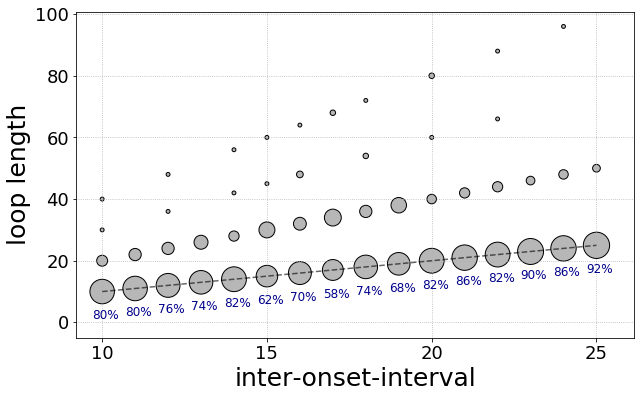

In [117]:
import random
loop34_2000=pd.read_csv("longer-shorter/34-setup-same-sensor-10k/loops-2000.csv",
                        index_col=0,
                        converters={"count":ast.literal_eval})
loopCounts34=plotScatters(loop34_2000)

iois = range(10,26)
plt.plot(iois,iois,'--',color='k',alpha=0.6,markersize=4)#,zorder=-1)

plt.xlabel('inter-onset-interval', fontsize=25)
plt.ylabel('loop length', fontsize=25)
plt.xticks(range(10,26,5),fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-5,100.8)
plt.grid(which='both',linestyle=':')

for ioi in loopCounts34.keys():
    plt.annotate('%.0f'%(loopCounts34[ioi][ioi]/50*100)+'%',(ioi-0.3,ioi-random.normalvariate(9,0)),
                 fontsize=12,color='darkblue')

#plt.savefig("longer-shorter/34-setup-same-sensor-10k/loop-lengths.pdf",bbox_inches='tight')

In [131]:
loopSameIOI=[loopCounts34[ioi][ioi]/50 for ioi in loopCounts34.keys()]
(np.mean(loopSameIOI), np.std(loopSameIOI),stats.sem(loopSameIOI))

(0.7762500000000001, 0.09279513726483733, 0.023959601415716417)

In [130]:
np.sum(loopSameIOI)/(50*16)

0.77625

In [132]:
loop34_2000

count
10  [10, 10, 10, 10, 40, 10, 20, 20, 10, 10, 10, 1...
11  [11, 11, 11, 11, 22, 11, 11, 11, 11, 11, 11, 1...
12  [12, 12, 12, 12, 48, 12, 24, 12, 12, 24, 24, 1...
13  [13, 13, 13, 13, 13, 13, 13, 13, 26, 26, 26, 2...
14  [14, 14, 28, 14, 56, 14, 28, 14, 14, 14, 14, 1...
15  [15, 15, 15, 15, 30, 15, 15, 30, 30, 15, 15, 1...
16  [32, 16, 32, 16, 64, 16, 16, 16, 16, 48, 16, 3...
17  [34, 17, 34, 17, 17, 17, 17, 17, 17, 68, 17, 1...
18  [54, 18, 18, 18, 72, 18, 36, 18, 18, 18, 36, 3...
19  [19, 19, 19, 19, 38, 38, 19, 19, 38, 19, 38, 3...
20  [40, 20, 20, 20, 80, 20, 40, 20, 20, 20, 20, 2...
21  [21, 21, 21, 21, 21, 21, 42, 21, 21, 21, 21, 2...
22  [44, 22, 22, 22, 88, 22, 44, 22, 22, 44, 22, 2...
23  [23, 23, 23, 23, 46, 23, 23, 23, 23, 23, 23, 2...
24  [24, 24, 24, 24, 96, 24, 24, 24, 24, 48, 24, 2...
25  [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...

## 4-2) Number of Brain states used to
## i)  encode stimuli information
## ii) perform judgement task

In [68]:
from ast import literal_eval

def readStats(fn, col, iois):
    stats = pd.read_csv(fn, index_col=0,
                                     converters={'entrainPerTrial': literal_eval, 'trainPerTrial': literal_eval,
                                                 'shDecPerTrial':literal_eval, 'loDecPerTrial': literal_eval})
    
    val = np.transpose(stats[col].tolist())

    df = pd.DataFrame(columns=['count'], index=iois)

    for i,ioi in enumerate(iois):
        df['count'].at[ioi] = val[i]#set_value(ioi, 'count', val[i])

    return df

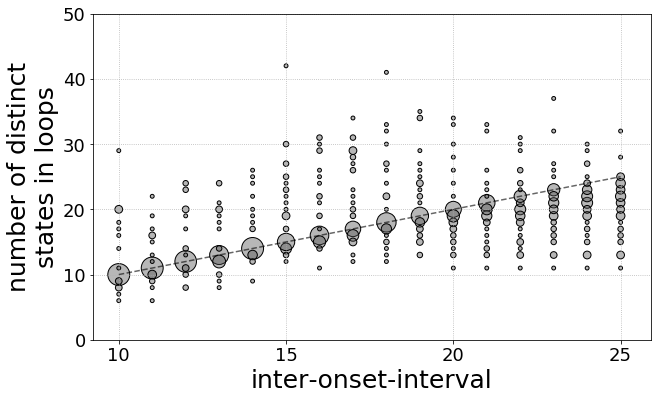

In [412]:
fn = "longer-shorter/34-setup-same-sensor-10k/svStat-34-2000.csv"
iois = range(10,26)
ss_2000 = readStats(fn, 'entrainPerTrial', iois)
plotScatters(ss_2000)

plt.plot(iois,iois,'--o',color='k',alpha=0.6,markersize=0)#,zorder=-1)

plt.xlabel('inter-onset-interval', fontsize=25)
plt.ylabel('number of distinct\nstates in loops', fontsize=25)
plt.xticks(range(10,26,5),fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,50)
plt.grid(which='both',linestyle=':')
#plt.tight_layout()
#plt.savefig("PNAS-images/state-space-25.pdf")
plt.savefig("longer-shorter/34-setup-same-sensor-10k/state-space-loops.pdf",bbox_inches='tight')

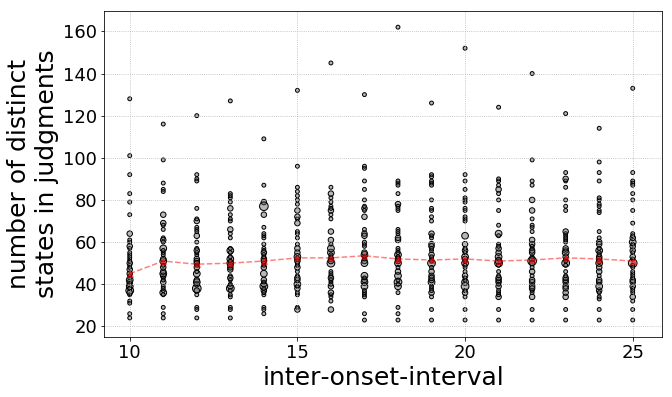

In [306]:
fn = "longer-shorter/34-setup-same-sensor-10k/svStat-34-2000.csv"
iois = range(10,26)
ss_2000 = readStats(fn, 'trainPerTrial', iois)
plotScatters(ss_2000)

#plt.plot(iois,iois,'--o',color='k',alpha=0.6,markersize=0)#,zorder=-1)

plt.xlabel('inter-onset-interval', fontsize=25)
plt.ylabel('number of distinct\nstates in judgments', fontsize=25)
plt.xticks(range(10,26,5),fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(0,50)
plt.grid(which='both',linestyle=':')
#plt.tight_layout()
#plt.savefig("PNAS-images/state-space-25.pdf")

ms=np.mean(ss_2000['count'].tolist(),axis=1)
meds=np.median(ss_2000['count'].tolist(),axis=1)
plt.plot(iois,meds,'--^',color='r',alpha=0.5)
stats.linregress(range(10,41,2),ms)
plt.savefig("longer-shorter/34-setup-same-sensor-10k/state-space-judgements.pdf",bbox_inches='tight')

In [362]:
fn = "longer-shorter/34-setup-same-sensor-10k/svStat-34-2000.csv"
sv34_2000 = pd.read_csv(fn,index_col=0)
sv34_2000

total  totTrain                                      trainPerTrial  \
1     387       238  [128, 116, 120, 127, 109, 132, 145, 130, 162, ...   
2      95        67  [43, 44, 45, 47, 48, 52, 55, 54, 54, 50, 53, 5...   
3      78        56  [41, 44, 49, 50, 54, 51, 54, 54, 53, 52, 52, 5...   
4     101        60  [49, 55, 54, 52, 49, 52, 52, 53, 52, 54, 56, 5...   
5      60        53  [47, 51, 52, 51, 52, 53, 53, 51, 51, 53, 53, 5...   
6      43        41  [32, 36, 38, 38, 38, 40, 41, 41, 41, 41, 41, 4...   
7     115        93  [79, 69, 70, 66, 79, 71, 71, 76, 88, 64, 85, 8...   
8      47        45  [44, 45, 40, 42, 37, 42, 42, 42, 42, 42, 42, 4...   
9     279       125  [83, 85, 70, 83, 77, 86, 86, 89, 89, 89, 89, 8...   
10     41        39  [35, 35, 37, 39, 39, 35, 35, 39, 39, 36, 39, 3...   
11     68        59  [42, 45, 51, 52, 51, 53, 55, 55, 56, 56, 55, 5...   
12     70        47  [37, 37, 38, 38, 40, 38, 44, 35, 44, 44, 39, 3...   
13     48        44  [37, 41, 38, 40, 39, 42, 39, 42, 40, 42, 39, 4...   
14    160       126  [101, 99, 90, 79, 77, 84, 83, 95, 83, 88, 70, ...   
15     35        34  [31, 29, 29, 29, 29, 29, 34, 34, 29, 34, 34, 3...   
16     90        82  [45, 46, 46, 48, 45, 59, 50, 66, 54, 59, 59, 5...   
17     49        46  [42, 43, 42, 44, 42, 46, 46, 44, 44, 46, 44, 4...   
18     31        28  [24, 24, 24, 24, 26, 28, 28, 23, 23, 23, 23, 2...   
19    130        98  [73, 73, 71, 66, 77, 69, 79, 72, 61, 58, 71, 5...   
20     34        28  [26, 26, 28, 28, 28, 28, 28, 26, 26, 28, 28, 2...   
21    169        98  [60, 69, 92, 76, 73, 75, 75, 75, 75, 75, 75, 7...   
22     95        81  [61, 68, 57, 62, 62, 75, 75, 64, 66, 63, 72, 6...   
23     45        45  [42, 42, 41, 38, 40, 40, 32, 41, 41, 38, 41, 4...   
24     55        44  [40, 39, 41, 37, 35, 40, 36, 39, 39, 41, 36, 3...   
25     93        78  [64, 62, 66, 53, 63, 69, 61, 63, 62, 70, 63, 6...   
26     90        73  [57, 57, 55, 56, 57, 57, 65, 60, 57, 57, 57, 5...   
27     65        39  [36, 36, 38, 39, 39, 39, 39, 39, 39, 39, 39, 3...   
28     70        68  [52, 61, 56, 56, 59, 55, 57, 52, 54, 59, 56, 5...   
29    166       104  [58, 60, 63, 71, 73, 80, 77, 76, 78, 80, 79, 8...   
30    164       128  [54, 61, 65, 73, 79, 72, 73, 77, 77, 76, 76, 5...   
31     60        41  [39, 38, 38, 38, 36, 36, 36, 36, 36, 36, 36, 3...   
32     70        62  [55, 48, 56, 55, 56, 55, 57, 58, 55, 43, 43, 5...   
33     57        41  [36, 36, 35, 35, 37, 38, 40, 37, 41, 37, 37, 3...   
34     58        47  [40, 46, 40, 43, 45, 44, 45, 44, 46, 46, 46, 4...   
35     89        76  [48, 51, 60, 64, 64, 62, 59, 59, 64, 62, 63, 6...   
36     63        52  [39, 49, 50, 48, 52, 48, 52, 43, 52, 43, 52, 4...   
37    165       118  [64, 84, 76, 76, 77, 96, 83, 85, 78, 92, 81, 8...   
38     49        45  [39, 41, 37, 34, 39, 43, 43, 41, 41, 41, 41, 4...   
39     76        65  [38, 57, 41, 57, 41, 65, 61, 64, 61, 64, 59, 6...   
40     54        52  [37, 48, 45, 50, 45, 49, 50, 50, 50, 50, 50, 5...   
41     80        54  [51, 51, 50, 49, 50, 50, 50, 50, 50, 50, 50, 5...   
42     82        56  [45, 52, 51, 52, 53, 51, 51, 50, 50, 50, 50, 5...   
43     95        79  [50, 54, 52, 56, 55, 64, 57, 63, 62, 58, 53, 5...   
44     99        80  [50, 56, 67, 70, 67, 72, 65, 72, 65, 72, 63, 6...   
45    121       109  [92, 88, 89, 81, 87, 78, 81, 96, 87, 91, 92, 8...   
46     91        69  [37, 57, 48, 50, 51, 57, 50, 54, 51, 54, 51, 5...   
47    110        98  [58, 73, 63, 82, 77, 82, 76, 80, 76, 87, 80, 8...   
48     97        75  [47, 66, 45, 47, 55, 53, 55, 55, 46, 51, 48, 5...   
49     62        56  [53, 52, 48, 49, 48, 48, 51, 51, 48, 48, 49, 4...   
50     52        48  [41, 45, 42, 43, 42, 43, 43, 44, 44, 44, 44, 4...   

    totEntrain                                    entrainPerTrial  \
1           55  [10, 11, 12, 13, 14, 14, 31, 26, 41, 19, 24, 2...   
2           36  [10, 11, 12, 12, 13, 13, 16, 17, 18, 19, 20, 2...   
3           31  [10, 1

In [389]:
sv34_2000['new-states'] = sv34_2000.total - sv34_2000.totTrain
print ("Brain state visits summed across all 50 Brains")
print ("new states:", sv34_2000['new-states'].sum(),
       "\ttotal training states:", sv34_2000.totTrain.sum(),
       "\ttotal number of states:", sv34_2000.total.sum())

print ("\nBrain state visits stats across all 50 Brains")
print ("\nnew states\tmean:", sv34_2000['new-states'].mean(), 
       "\tmedian:",sv34_2000['new-states'].median(),
       "\tstandard deviation:", np.round(sv34_2000['new-states'].std(),2),
       "\tstandard error of mean:", np.round(sv34_2000['new-states'].sem(),2))

print ("total training\tmean:", sv34_2000.totTrain.mean(),
       "\tmedian:", sv34_2000.totTrain.median(), 
       "\tstandard deviation:", np.round(sv34_2000.totTrain.std()),
       "\tstandard error of mean:", np.round(sv34_2000.totTrain.sem(),2))

print ("total\t\tmean:", sv34_2000.total.mean(),
       "\tmedian:", sv34_2000.total.median(), 
       "\tstandard deviation:", np.round(sv34_2000.total.std()),
       "\tstandard error of mean:", np.round(sv34_2000.total.sem(),2))
print (sv34_2000['new-states'].sum()/sv34_2000.totTrain.sum())

Brain state visits summed across all 50 Brains
new states: 1113 	total training states: 3490 	total number of states: 4603

Brain state visits stats across all 50 Brains

new states	mean: 22.26 	median: 13.5 	standard deviation: 30.63 	standard error of mean: 4.33
total training	mean: 69.8 	median: 59.5 	standard deviation: 36.0 	standard error of mean: 5.07
total		mean: 92.06 	median: 77.0 	standard deviation: 62.0 	standard error of mean: 8.83
0.3189111747851003


In [66]:
from collections import Counter

def subplotsScatters(ad, gens, iois, col, yMin, yMax, xtickStep, figFn=""):
    fig, ax = plt.subplots(4,2,figsize=(14,16))
    for ind,gen in enumerate(gens):
        df=readStats(ad+"stats-"+str(gen)+".csv", col, iois)
        for ioi in df.index:
            l = df['count'].loc[ioi]
            d = dict(Counter(l))
            loopSz, cnt = [int(k) for k in list(d.keys())], [int(v) for v in list(d.values())]
            xs = [int(ioi)]*(len(d))
            c=np.arange(len(iois))
            i,j=ind//2,ind%2
            ax[i,j].scatter(xs, loopSz, s=[c*15 for c in cnt], edgecolor=(0,0,0,1.0), color=(0.3,0.3,0.3,0.4))
        ax[i,j].plot(iois,iois,'--',color='k',alpha=0.6,markersize=0)
        ax[i,j].set_xticks(range(iois[0], iois[-1]+1, xtickStep))
            #ax[i,j].set_yticks(fontsize=18)
        ax[i,j].set_ylim(yMin,yMax)
        ax[i,j].tick_params(axis='both', labelsize=16)
        ax[i,j].grid(which='both',linestyle=':')
        ax[i,j].set_title("generation="+str(gen),fontsize=18)
    
    fig.text(-0.04,0.5,"number of distinct states in loops",rotation=90,fontsize=28,va='center')
    fig.text(0.5,-0.03,"inter-onset-interval",fontsize=28,ha='center')

    
    fig.tight_layout(w_pad=5,h_pad=3)  
    fig.savefig(figFn, bbox_inches='tight')

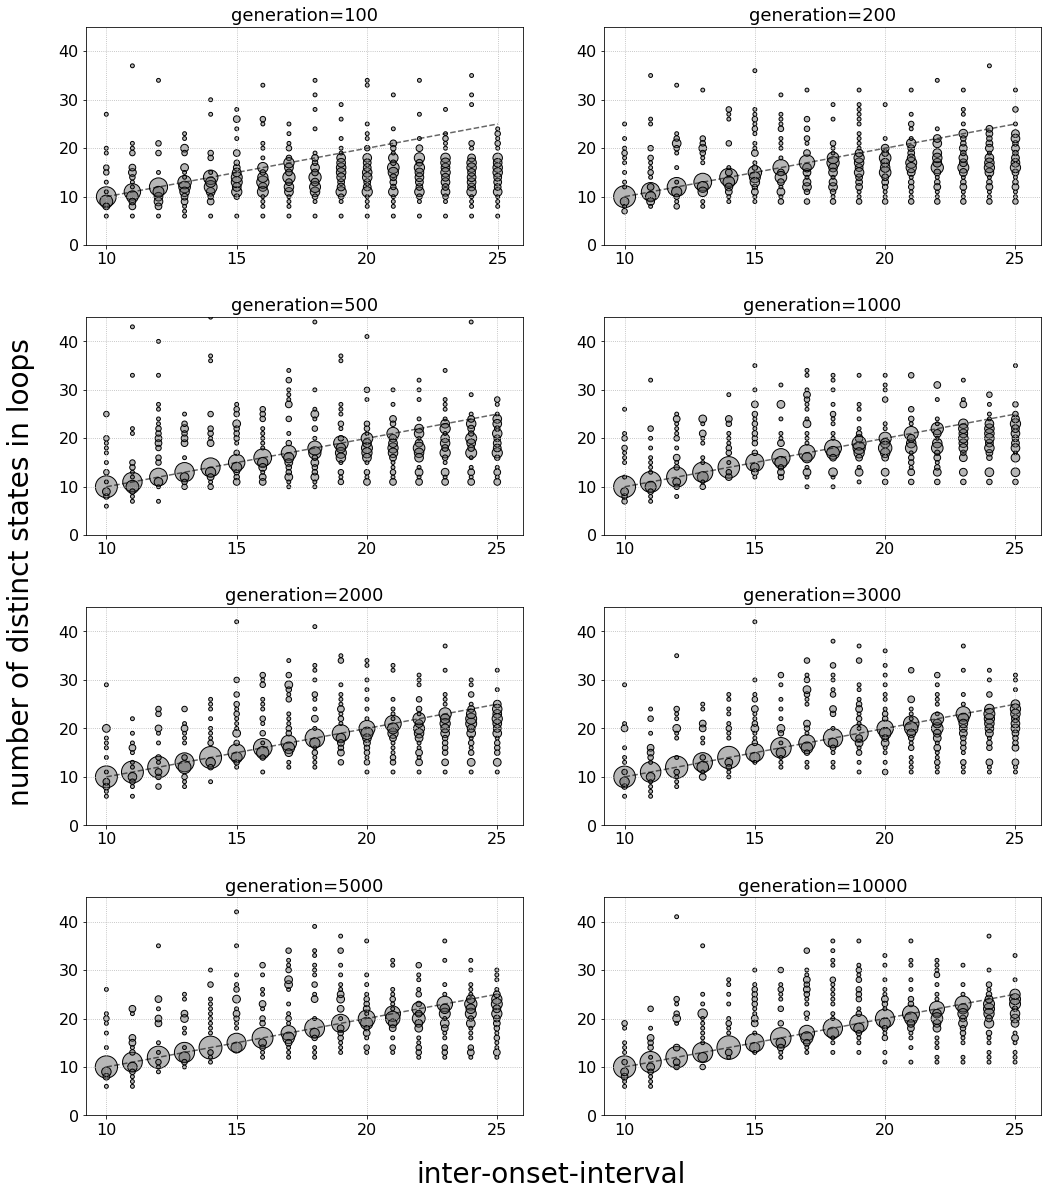

In [41]:
iois=list(range(10,26))
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsScatters("longer-shorter/34-setup-same-sensor-10k/", gens, iois, 'entrainPerTrial', 0, 45, 5, 
                 "longer-shorter/34-setup-same-sensor-10k/state-spaces-gens.pdf")

## Correlation between state-space size used to encode information and 
## i)  performace
## ii) CEs

In [536]:
def readDistributions(ad,gens,iois):
    index=pd.MultiIndex.from_product([gens,iois],names=['gen','ioi'])
    df=pd.DataFrame(columns=['st','absCE','ceErr','L0','L1','L2'],index=index)

    for gen in gens:
        fn=ad+"stats-"+str(gen)+".csv"
        states = pd.read_csv(fn, index_col=0,
                             converters={'entrainPerTrial': literal_eval, 'trainPerTrial': literal_eval,
                                         'shDecPerTrial':literal_eval, 'loDecPerTrial': literal_eval})

        st = np.transpose(states['entrainPerTrial'].tolist())
        st=[s for s in st]
        df['st'].at[gen]=st#list(range(16))
        psy=pd.read_csv(ad+"psy-"+str(gen)+".csv",index_col=[0,1],converters={"pattern":ast.literal_eval})
        df['absCE'].at[gen]=np.abs(psy[psy.index.get_level_values('delay')==0].CE.tolist())
        df['ceErr'].at[gen]=psy[psy.index.get_level_values('delay')==0].PseStd.tolist()
        del states
        
    df['L2']=df.apply(lambda row: np.sqrt(np.sum( [(c-row.name[1])**2 for c in row['st']] )),axis=1)
    df['L2']=df.L2/df.L2.max()
    
    df['L1']=df.apply(lambda row: np.sum( [np.abs(c-row.name[1]) for c in row['st']] )/row.name[1],axis=1)
    df['L1']=df.L1/df.L1.max()
    
    df['L0']=df.apply(lambda row: np.sum( [1 if c!=row.name[1] else 0 for c in row['st']] ),axis=1)    
    df['L0']=df.L0/df.L0.max()

    return df

In [540]:
import inspect

def quad(x,a,b,c):
    return a*x**2 + b*x + c

def exp(x,a):
    return np.exp(a*x)

def linear(x,a,b):
    return a*x+b

def ramp(x,a,b,x0):
    return a*np.maximum(x-x0,0)+b

def softplus(x,a,b,x0):
    return np.log(1+np.exp(a*(x-x0)))+b

def BIC(n,k,RSS):
    return n*np.log(RSS/n)+k*np.log(n)

In [577]:
from scipy.optimize import curve_fit

def fit_data(xdata, ydata, sigmas, func, p0=None):
    popt, pcov = curve_fit(func,xdata,ydata,sigma=sigmas,absolute_sigma=True,p0=p0,maxfev=10000)
    
    residuals = ydata - func(xdata, *popt)
    chi_sq = np.sum( ((ydata - func(xdata,*popt))/np.array(sigmas))**2)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return (popt,pcov,residuals,r_squared,ss_res)
    
def bin_and_plot(df):
    dfMean=df.astype({'absCE':float,'ceErr':float}).pivot_table(index=['L0'],values=['absCE','ceErr'],
                                                                aggfunc={'absCE':np.mean, 'ceErr':np.max})
    
    plt.figure(figsize=(8,5))
    plt.scatter(df.L0, df.absCE, alpha=0.6, marker='o', s=100, color='0.4')
    plt.errorbar(dfMean.index, dfMean.absCE, yerr=dfMean.ceErr,fmt='o',capsize=4,color='b',alpha=0.8)
    
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams['mathtext.rm'] = 'serif'
    
    plt.grid(which='both',linestyle=':')
    plt.xlabel('$\delta_{IOI}$',fontsize=24)
    plt.ylabel('| constant error |',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return dfMean
    
def fit_plot(dfMean, func):
    ls, ces, ceErr = dfMean.index, dfMean.absCE, dfMean.ceErr
    xs=np.linspace(np.min(ls.tolist()),np.max(ls.tolist()),100)
    n=len(ls)
    k=len(inspect.getfullargspec(func)[0])-1
    
    popt,pcov,res,rSq,RSS=fit_data(ls, ces, ceErr, func, [1,0,0.5])
    plt.plot(xs,func(xs,*popt),color='b',alpha=0.5, linestyle='-',linewidth=4,zorder=3)
    
    return (popt,pcov,res,rSq,RSS)
    
def compare_models(dfMean, functions):
    ls, ces, ceErr = dfMean.index, dfMean.absCE, dfMean.ceErr
    n=len(ls)
    
    for i,func in enumerate(functions):
        popt,pcov,res,rSq,RSS=fit_data(ls, ces, ceErr, func, [1,0,0.5])
        k=len(inspect.getfullargspec(func)[0])-1
        print ('{:12s}'.format(func.__name__),'RSS:', 
               np.round(RSS,2), '\tr2:', np.round(rSq,2),'\tBIC:',np.round(BIC(n,k,RSS),2))

LinregressResult(slope=3.0771060230500864, intercept=-1.3707212839246603, rvalue=0.7036842886630987, pvalue=1.9869209121228295e-20, stderr=0.27679053308014073)
LinregressResult(slope=3.716494907581538, intercept=-1.1368522255898894, rvalue=0.6073619568525163, pvalue=2.9410464309517076e-14, stderr=0.43306562717375113)
LinregressResult(slope=4.927717980601202, intercept=-1.7751155857944592, rvalue=0.7104840293637811, pvalue=5.8605483295096464e-21, stderr=0.4348125060227662)


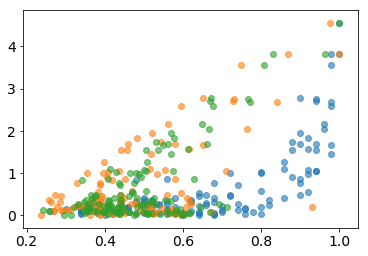

In [538]:
ad="longer-shorter/34-setup-same-sensor-10k/"
iois=range(10,26)
gens=[100,200,500,1000,2000,3000,5000,10000]
df34=readDistributions(ad,gens,iois)
plt.scatter(df34.L0,df34.absCE,alpha=0.6)
plt.scatter(df34.L1,df34.absCE,alpha=0.6)
plt.scatter(df34.L2,df34.absCE,alpha=0.6)
print (stats.linregress( df34.L0.tolist(),df34.absCE.tolist()) )
print (stats.linregress( df34.L1.tolist(),df34.absCE.tolist()) )
print (stats.linregress( df34.L2.tolist(),df34.absCE.tolist()) )

quad         RSS: 6.49 	r2: 0.76 	BIC: -48.29
ramp         RSS: 2.41 	r2: 0.91 	BIC: -83.02
softplus     RSS: 1.9 	r2: 0.93 	BIC: -91.39


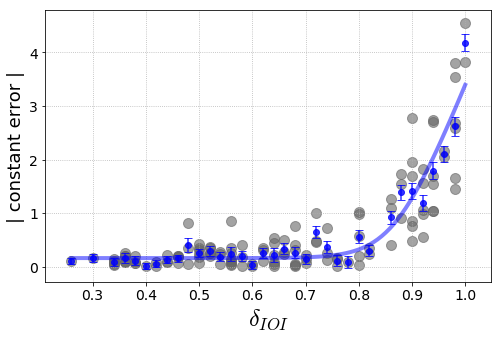

In [578]:
df34Mean=bin_and_plot(df34)
fit_plot(df34Mean, softplus)

functions=[quad, ramp, softplus]
compare_models(df34Mean, functions)
plt.savefig("longer-shorter/34-setup-same-sensor-10k/CE-delta-34.pdf",bbox_inches='tight')

# Supplementary Experiments

## 34-setup non-uniform training in trials

In [102]:
res34nw_10000 = readResponseFile("longer-shorter/34-setup-same-sensor-non-weber/res-10000.csv")
psy34nw_10000 = pd.read_csv("longer-shorter/34-setup-same-sensor-non-weber/psy-10000.csv",
                            converters={"pattern":ast.literal_eval},index_col=[0,1])
psy34nw_10000[psy34nw_10000.index.get_level_values('delay')==0]

PSE    PseStd       JND    JndStd  PseJndCov    relJND  \
pattern  delay                                                                 
(10, 5)  0       4.975409  0.066573  0.278126  0.051927  -0.014908  0.055625   
(11, 5)  0       5.109636  0.044807  0.191107  0.028046  -0.003089  0.038221   
(12, 6)  0       5.856016  0.066974  0.296071  0.039087   0.008233  0.049345   
(13, 6)  0       6.214007  0.067450  0.268576  0.034216  -0.014768  0.044763   
(14, 7)  0       6.938239  0.053860  0.233775  0.037050   0.000036  0.033396   
(15, 7)  0       7.107228  0.068703  0.322664  0.041042  -0.004771  0.046095   
(16, 8)  0       8.153710  0.067482  0.294578  0.033914  -0.011675  0.036822   
(17, 8)  0       8.208749  0.056086  0.192900  0.032995  -0.017044  0.024113   
(18, 9)  0       8.794118  0.063684  0.312192  0.039860   0.006697  0.034688   
(19, 9)  0       9.000000  0.101404  0.487393  0.111407  -0.023178  0.054155   
(20, 10) 0       9.553133  0.068573  0.310750  0.042345   0.003080  0.031075   
(21, 10) 0       9.734713  0.061139  0.259206  0.039395   0.008343  0.025921   
(22, 11) 0      10.644890  0.067061  0.273202  0.039920   0.006763  0.024837   
(23, 11) 0      11.185942  0.064003  0.266415  0.040612  -0.007472  0.024220   
(24, 12) 0      12.177140  0.079255  0.368754  0.050623  -0.003194  0.030729   
(25, 12) 0      12.997185  0.076635  0.315876  0.058992   0.013290  0.026323   

                     DDF        CE  
pattern  delay                      
(10, 5)  0      1.004942 -0.024591  
(11, 5)  0      0.978543  0.109636  
(12, 6)  0      1.024587 -0.143984  
(13, 6)  0      0.965561  0.214007  
(14, 7)  0      1.008902 -0.061761  
(15, 7)  0      0.984913  0.107228  
(16, 8)  0      0.981148  0.153710  
(17, 8)  0      0.974570  0.208749  
(18, 9)  0      1.023411 -0.205882  
(19, 9)  0      1.000000  0.000000  
(20, 10) 0      1.046777 -0.446867  
(21, 10) 0      1.027252 -0.265287  
(22, 11) 0      1.033360 -0.355110  
(23, 11) 0      0.983377  0.185942  
(24, 12) 0      0.985453  0.177140  
(25, 12) 0      0.923277  0.997185

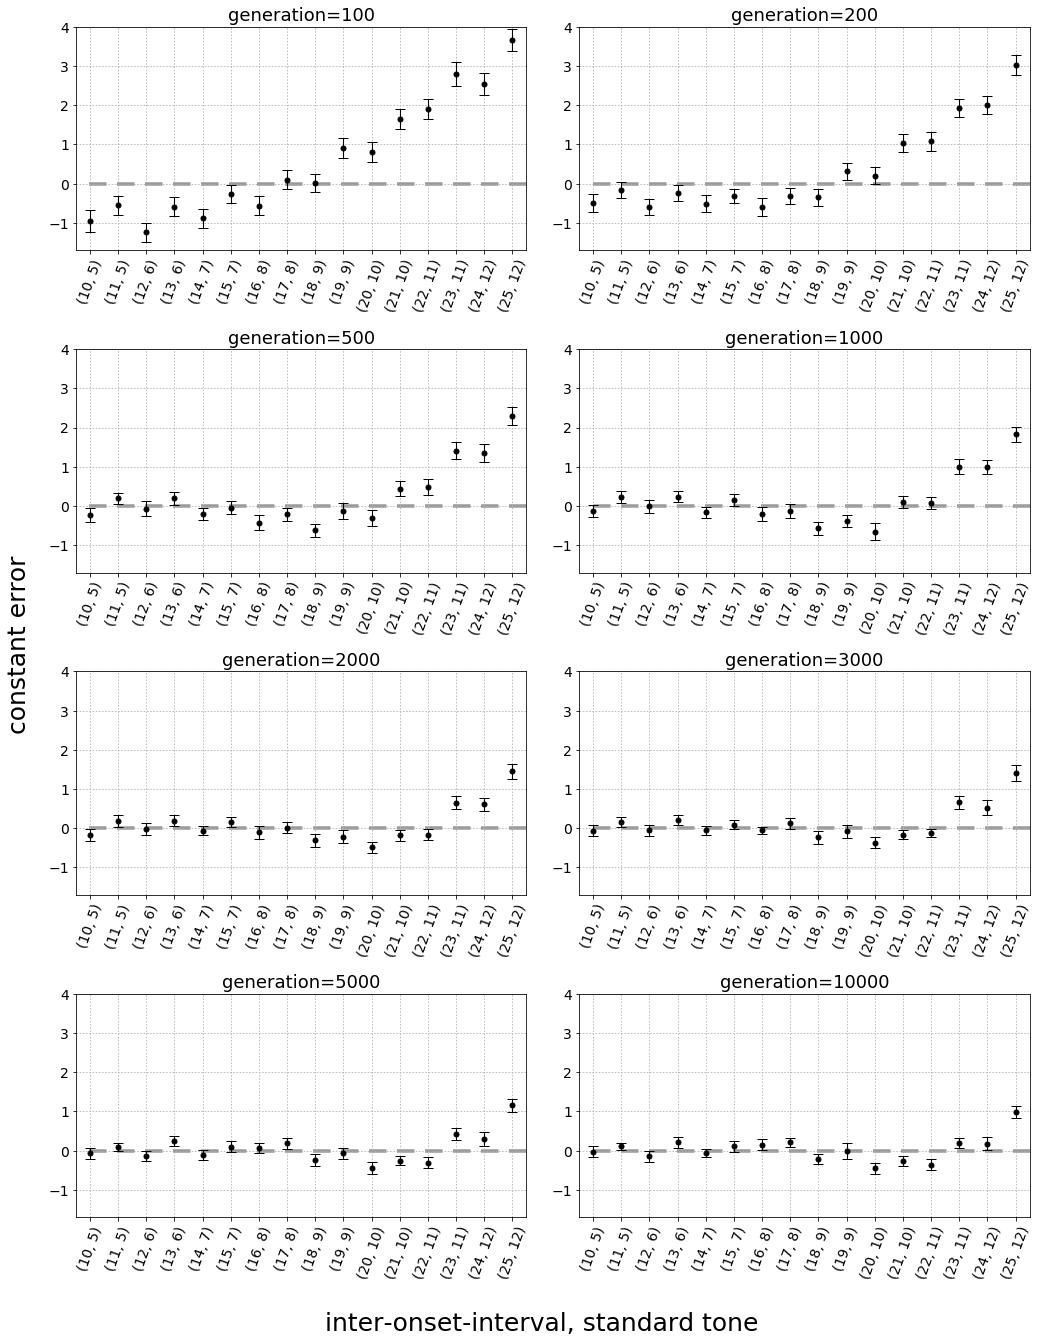

In [461]:
ad = "longer-shorter/34-setup-same-sensor-non-weber/"
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsCEs(ad,gens,"longer-shorter/34-setup-same-sensor-non-weber/CEs.pdf",-1.7,4,range(-1,5))

pattern: (19, 9) 	delay: 0 

psychometric curve for current values:


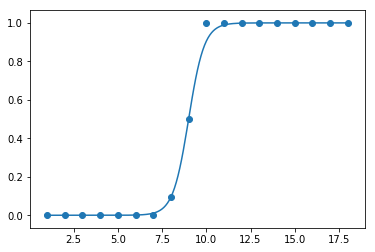

0.03969912351882927
psychometric curve after corrections:


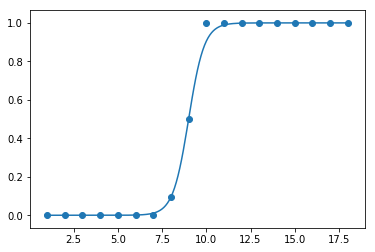

In [58]:
# fn="longer-shorter/34-setup-same-sensor-non-weber/res-10000.csv"
# res34nw_10000=readResponseFile(fn)

# ad="longer-shorter/34-setup-same-sensor-non-weber/"
# psy34nw_10000 = pd.read_csv(ad+"psy-"+str(10000)+".csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy34nw_10000_corrected = psy34nw_10000.copy(deep=True)

inq=[((19,9),0)]
for (pat,delay) in inq:
    print ("pattern:",pat,"\tdelay:",delay,'\n')
    print ("psychometric curve for current values:")
    plotResponseCurve(res34nw_10000, psy34nw_10000, pat, delay)
    
    l=correctFit(res34nw_10000, psy34nw_10000, pat, delay)

    print ("psychometric curve after corrections:")
    psy34nw_10000_corrected.loc[pat,delay]=l
    plotResponseCurve(res34nw_10000, psy34nw_10000_corrected, pat, delay)
    

In [462]:
psy34nw_10000_corrected.to_csv("longer-shorter/34-setup-same-sensor-non-weber/psy-10000.csv")
ad = "longer-shorter/34-setup-same-sensor-non-weber/"
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsCEs(ad,gens,"longer-shorter/34-setup-same-sensor-non-weber/CEs.pdf",-1.7,4,range(-1,5))

NameError: name 'psy34nw_10000_corrected' is not defined

LinregressResult(slope=-0.003109501364200121, intercept=0.06270121662003839, rvalue=-0.683909868259108, pvalue=0.003482891726761471, stderr=0.0008865286051615547)


(0.0, 0.1)

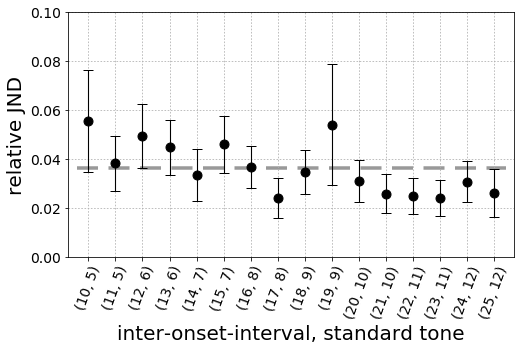

In [60]:
psy34nw_10000=pd.read_csv("longer-shorter/34-setup-same-sensor-non-weber/psy-"+str(10000)+".csv",
                          converters={"pattern":ast.literal_eval},index_col=[0,1])
plotRelJND(psy34nw_10000,1)
plt.ylim(0.0,0.10)
#plt.yticks([0.0,0.05,0.10])

#plt.savefig("longer-shorter/34-setup-same-sensor-10k/relative-JNDs.pdf",bbox_inches='tight')

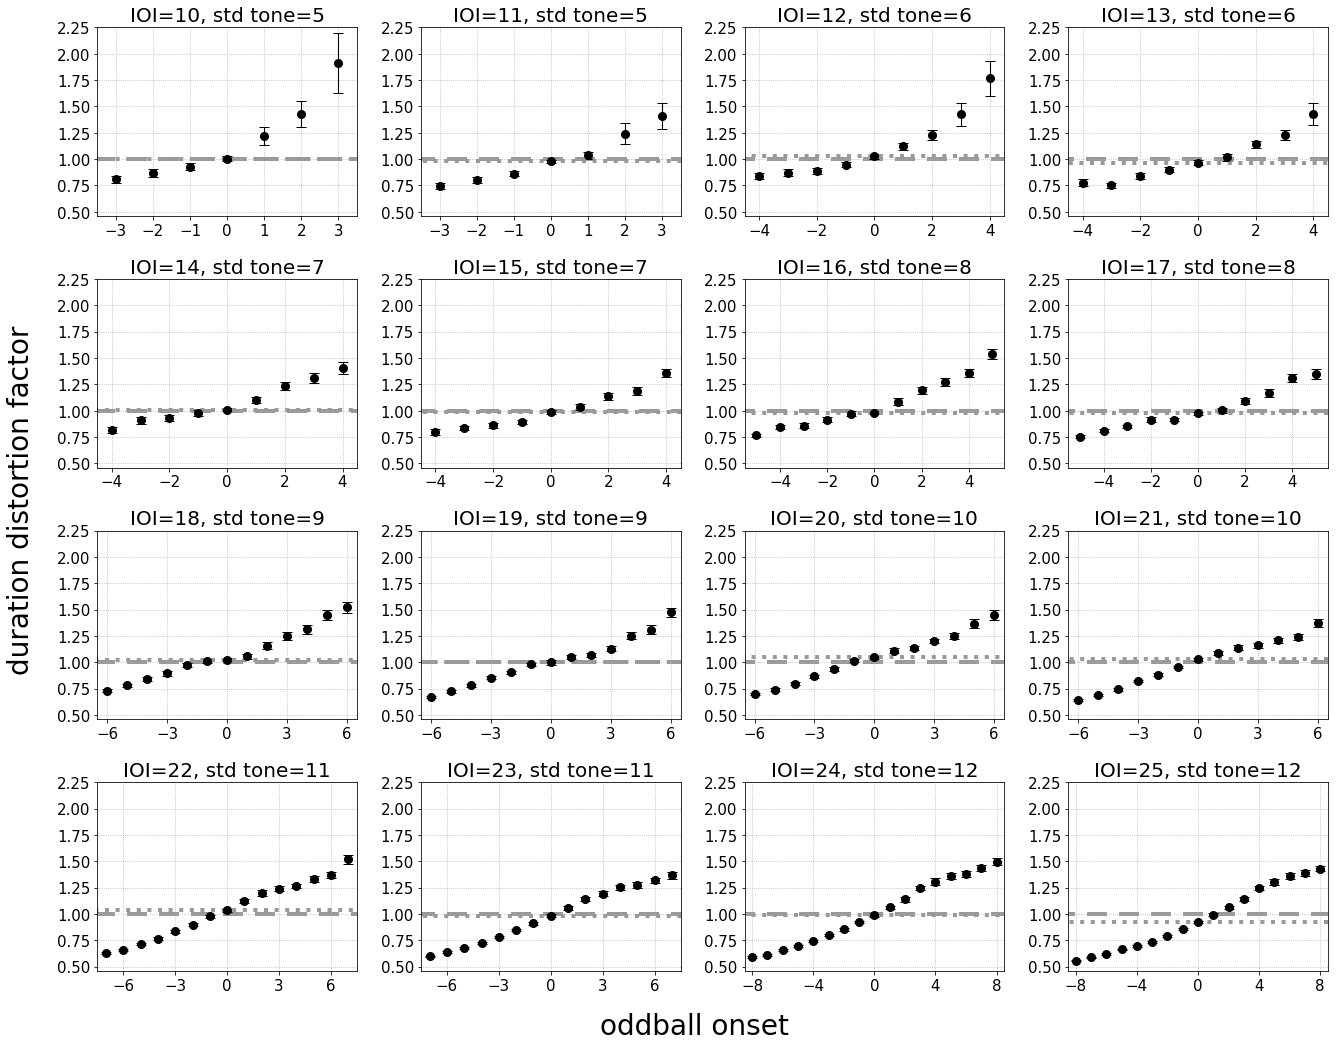

In [61]:
ad="longer-shorter/34-setup-same-sensor-non-weber/"

fig,ax = plotDDFSubplots(pd.read_csv(ad+"psy-10000.csv",index_col=[0,1],
                            converters={"pattern":ast.literal_eval}), 0.46, 2.24, np.arange(0.5,2.26,0.25))
ax[0,0].set_xticks(range(-3,4))
ax[0,1].set_xticks(range(-3,4))
# ax[0,2].set_xticks(range(-4,5))
# ax[0,3].set_xticks(range(-4,5))
ax[1,2].set_xticks(range(-4,5,2))
ax[1,3].set_xticks(range(-4,5,2))
ax[2,0].set_xticks(range(-6,7,3))
ax[2,1].set_xticks(range(-6,7,3))
ax[2,2].set_xticks(range(-6,7,3))
ax[2,3].set_xticks(range(-6,7,3))
ax[3,0].set_xticks(range(-6,7,3))
ax[3,1].set_xticks(range(-6,7,3))
ax[3,2].set_xticks(range(-8,9,4))
ax[3,3].set_xticks(range(-8,9,4))

fig.tight_layout(w_pad=2,h_pad=2)

pattern: (17, 8) 	delay: -5 

psychometric curve for current values:


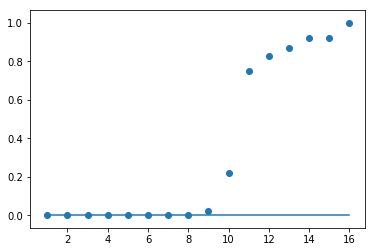

[0.02, 0.22, 0.75, 0.83, 0.87, 0.92, 0.92]
0.01399708424447531
psychometric curve after corrections:


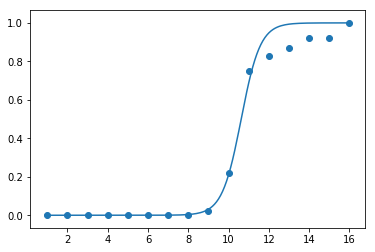

pattern: (18, 9) 	delay: 5 

psychometric curve for current values:


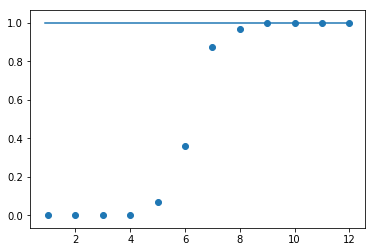

[0.07, 0.36, 0.875, 0.97]
0.022177392423228602
psychometric curve after corrections:


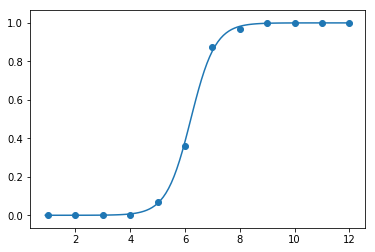

pattern: (22, 11) 	delay: -5 

psychometric curve for current values:


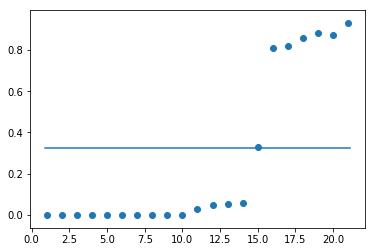

[0.03, 0.05, 0.055, 0.06, 0.33, 0.81, 0.82, 0.86, 0.88, 0.87, 0.93]
0.022177392423228585
psychometric curve after corrections:


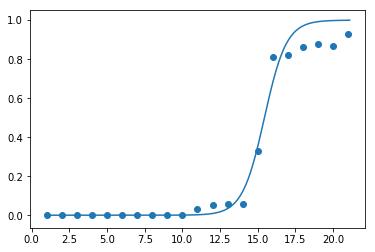

pattern: (23, 11) 	delay: -7 

psychometric curve for current values:


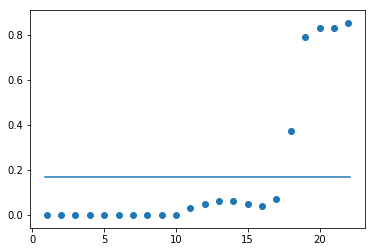

[0.03, 0.05, 0.06, 0.06, 0.05, 0.04, 0.07, 0.37, 0.79, 0.83, 0.83, 0.85]
0.022177392423228588
psychometric curve after corrections:


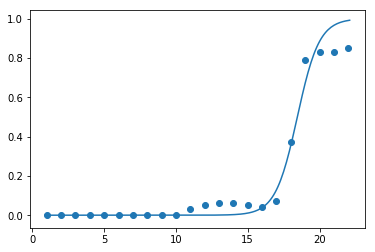

pattern: (23, 11) 	delay: -6 

psychometric curve for current values:


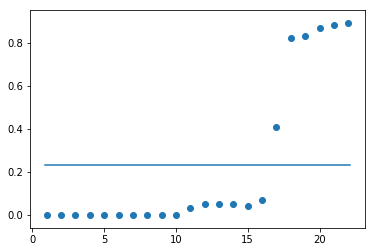

[0.03, 0.05, 0.05, 0.05, 0.04, 0.07, 0.41, 0.82, 0.83, 0.87, 0.88, 0.89]
0.022177392423228585
psychometric curve after corrections:


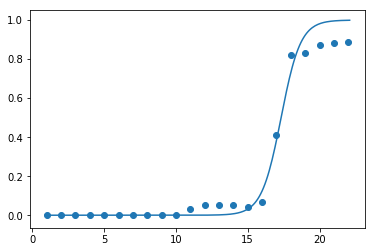

pattern: (24, 12) 	delay: -7 

psychometric curve for current values:


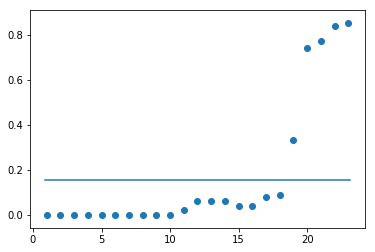

[0.02, 0.06, 0.06, 0.06, 0.04, 0.04, 0.08, 0.09, 0.33, 0.74, 0.77, 0.84, 0.85]
0.019999999999999987
psychometric curve after corrections:


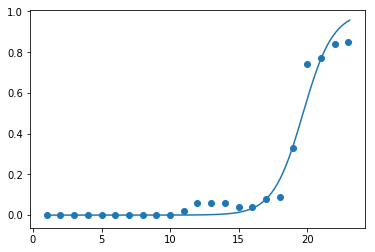

pattern: (25, 12) 	delay: -7 

psychometric curve for current values:


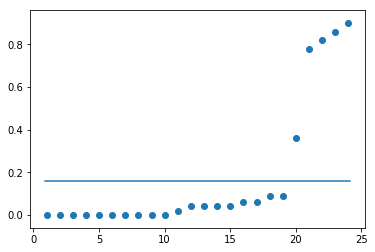

[0.02, 0.04, 0.04, 0.04, 0.04, 0.06, 0.06, 0.09, 0.09, 0.36, 0.78, 0.82, 0.86, 0.9]
0.019999999999999987
psychometric curve after corrections:


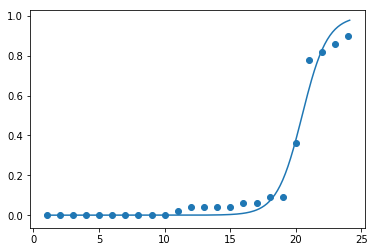

pattern: (25, 12) 	delay: -8 

psychometric curve for current values:


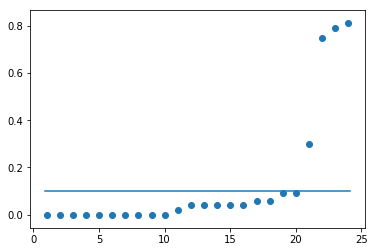

[0.02, 0.04, 0.04, 0.04, 0.04, 0.04, 0.06, 0.06, 0.09, 0.09, 0.3, 0.75, 0.79, 0.81]
0.019999999999999987
psychometric curve after corrections:


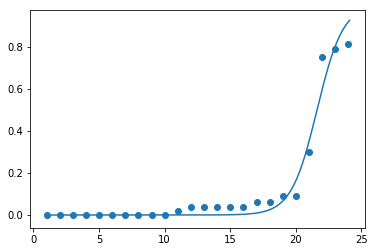

pattern: (25, 12) 	delay: 7 

psychometric curve for current values:


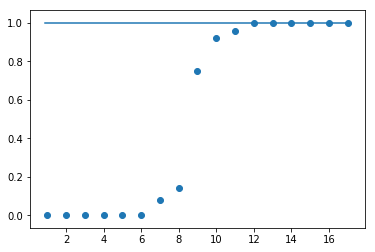

[0.08, 0.14, 0.75, 0.92, 0.96]
0.02799416848895062
psychometric curve after corrections:


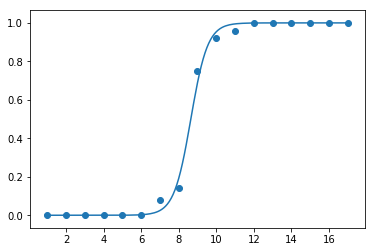

In [76]:
psy34nw_10000_corrected = psy34nw_10000.copy(deep=True)
res34nw_10000 = readResponseFile("longer-shorter/34-setup-same-sensor-non-weber/res-10000.csv")

inq=[((17,8),-5), ((18,9),5), ((22,11),-5), ((23,11),-7), ((23,11),-6), ((24,12),-7), ((25,12),-7), ((25,12),-8),
    ((25,12),7)]

for (pat,delay) in inq:
    print ("pattern:",pat,"\tdelay:",delay,'\n')
    print ("psychometric curve for current values:")
    plotResponseCurve(res34nw_10000, psy34nw_10000, pat, delay)

    l=correctFit(res34nw_10000, psy34nw_10000_corrected, pat, delay)

    print ("psychometric curve after corrections:")
    psy34nw_10000_corrected.loc[pat,delay]=l
    plotResponseCurve(res34nw_10000, psy34nw_10000_corrected, pat, delay)

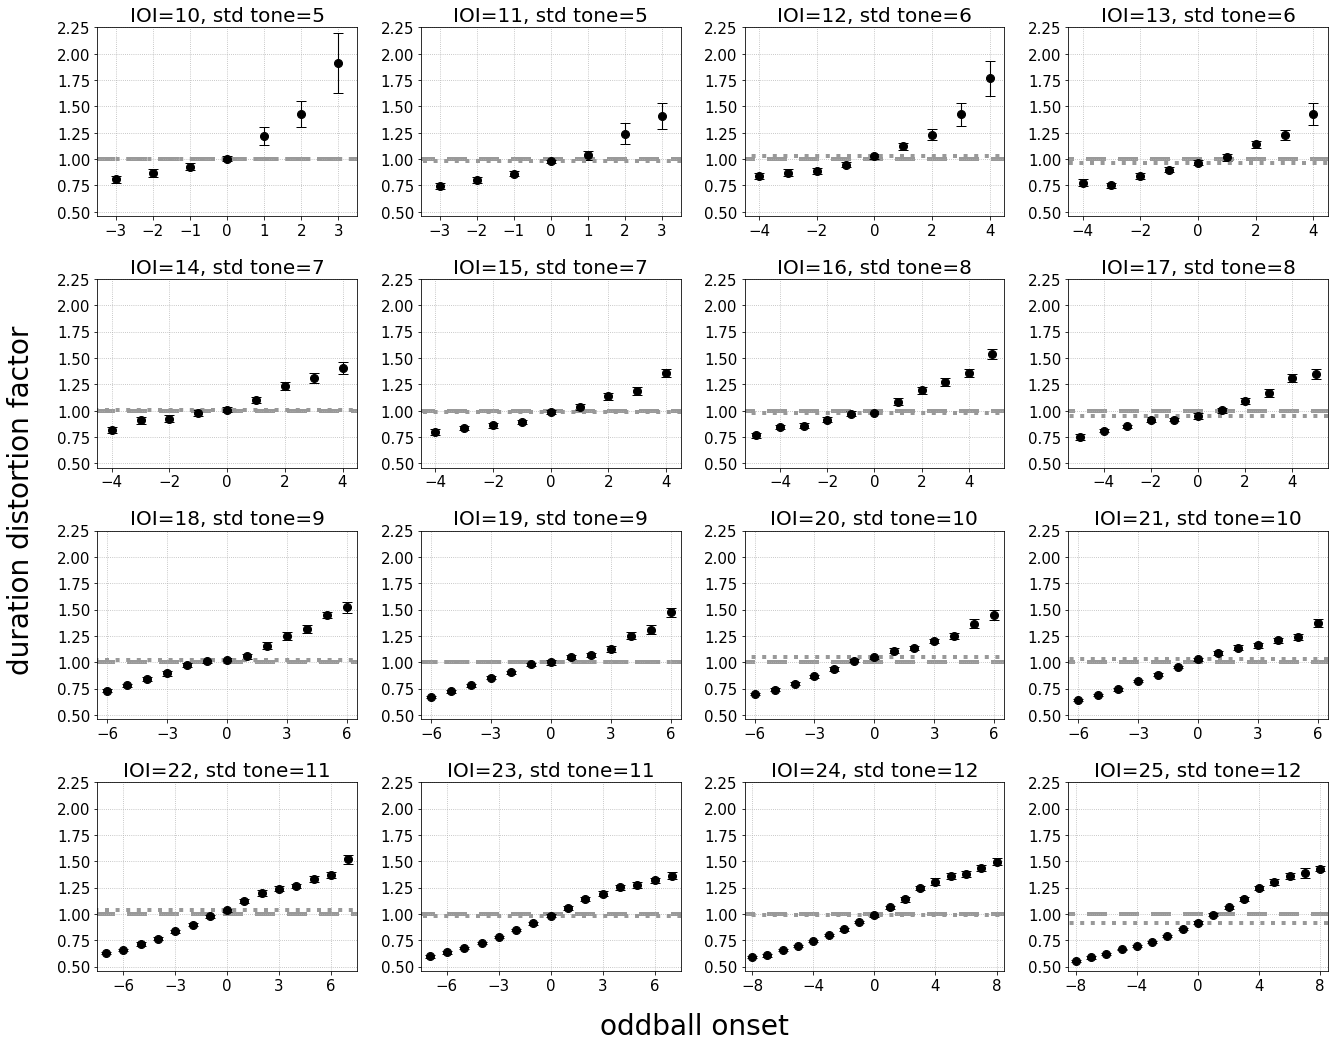

In [80]:
fig,ax = plotDDFSubplots(psy34nw_10000_corrected, 0.46, 2.24, np.arange(0.5,2.26,0.25))

ax[0,0].set_xticks(range(-3,4))
ax[0,1].set_xticks(range(-3,4))
# ax[0,2].set_xticks(range(-4,5))
# ax[0,3].set_xticks(range(-4,5))
ax[1,2].set_xticks(range(-4,5,2))
ax[1,3].set_xticks(range(-4,5,2))
ax[2,0].set_xticks(range(-6,7,3))
ax[2,1].set_xticks(range(-6,7,3))
ax[2,2].set_xticks(range(-6,7,3))
ax[2,3].set_xticks(range(-6,7,3))
ax[3,0].set_xticks(range(-6,7,3))
ax[3,1].set_xticks(range(-6,7,3))
ax[3,2].set_xticks(range(-8,9,4))
ax[3,3].set_xticks(range(-8,9,4))

fig.tight_layout(w_pad=2,h_pad=2)

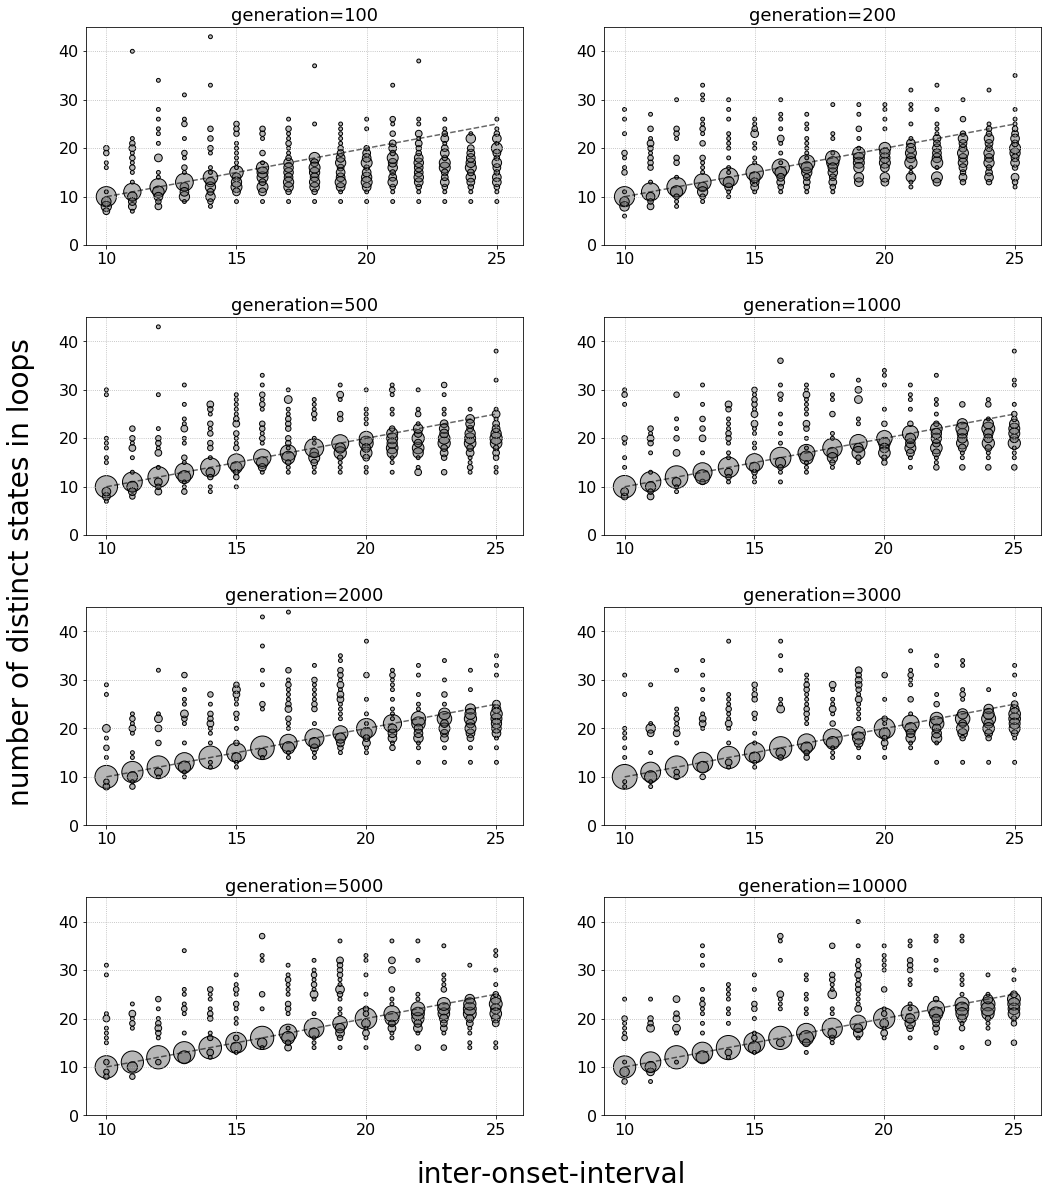

In [6]:
iois=list(range(10,26))
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsScatters("longer-shorter/34-setup-same-sensor-non-weber/", gens, iois, 'entrainPerTrial', 0, 45, 5, 
                 "longer-shorter/34-setup-same-sensor-non-weber/state-spaces-gens.pdf")

LinregressResult(slope=1.9010171007294032, intercept=-0.6653014286714605, rvalue=0.6452965154800716, pvalue=2.00173707442115e-16, stderr=0.20049163037186643)
LinregressResult(slope=1.3337135385686116, intercept=-0.10944683278658984, rvalue=0.30774084040651006, pvalue=0.0004097977730207179, stderr=0.36735618016892163)
LinregressResult(slope=1.670371845019854, intercept=-0.42905394065958746, rvalue=0.3508655889112197, pvalue=4.896479757176392e-05, stderr=0.39715542302625156)


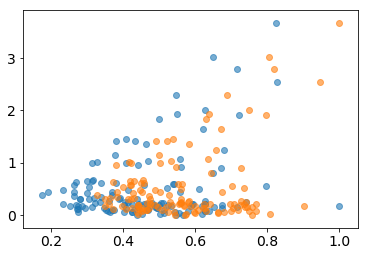

In [560]:
ad="longer-shorter/34-setup-same-sensor-non-weber/"
iois=range(10,26)
gens=[100,200,500,1000,2000,3000,5000,10000]
df34nw=readDistributions(ad,gens,iois)
#plt.scatter(df34nw.L0,df34nw.absCE,alpha=0.6)
plt.scatter(df34nw.L1,df34nw.absCE,alpha=0.6)
plt.scatter(df34nw.L2,df34nw.absCE,alpha=0.6)
print (stats.linregress( df34nw.L0.tolist(),df34nw.absCE.tolist()) )
print (stats.linregress( df34nw.L1.tolist(),df34nw.absCE.tolist()) )
print (stats.linregress( df34nw.L2.tolist(),df34nw.absCE.tolist()) )

quad         RSS: 5.36 	r2: 0.65 	BIC: -66.42
ramp         RSS: 1.59 	r2: 0.9 	BIC: -113.77
softplus     RSS: 1.4 	r2: 0.91 	BIC: -118.65


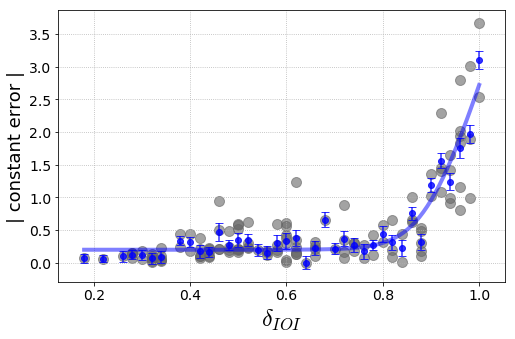

In [579]:
df34nwMean=bin_and_plot(df34nw)
popt,pcov,res,rSq,RSS = fit_plot(df34nwMean, softplus)

functions=[quad, ramp, softplus]
compare_models(df34nwMean, functions)
plt.savefig("longer-shorter/34-setup-same-sensor-non-weber/CE-delta-34nw.pdf",bbox_inches='tight')

## 35-setup

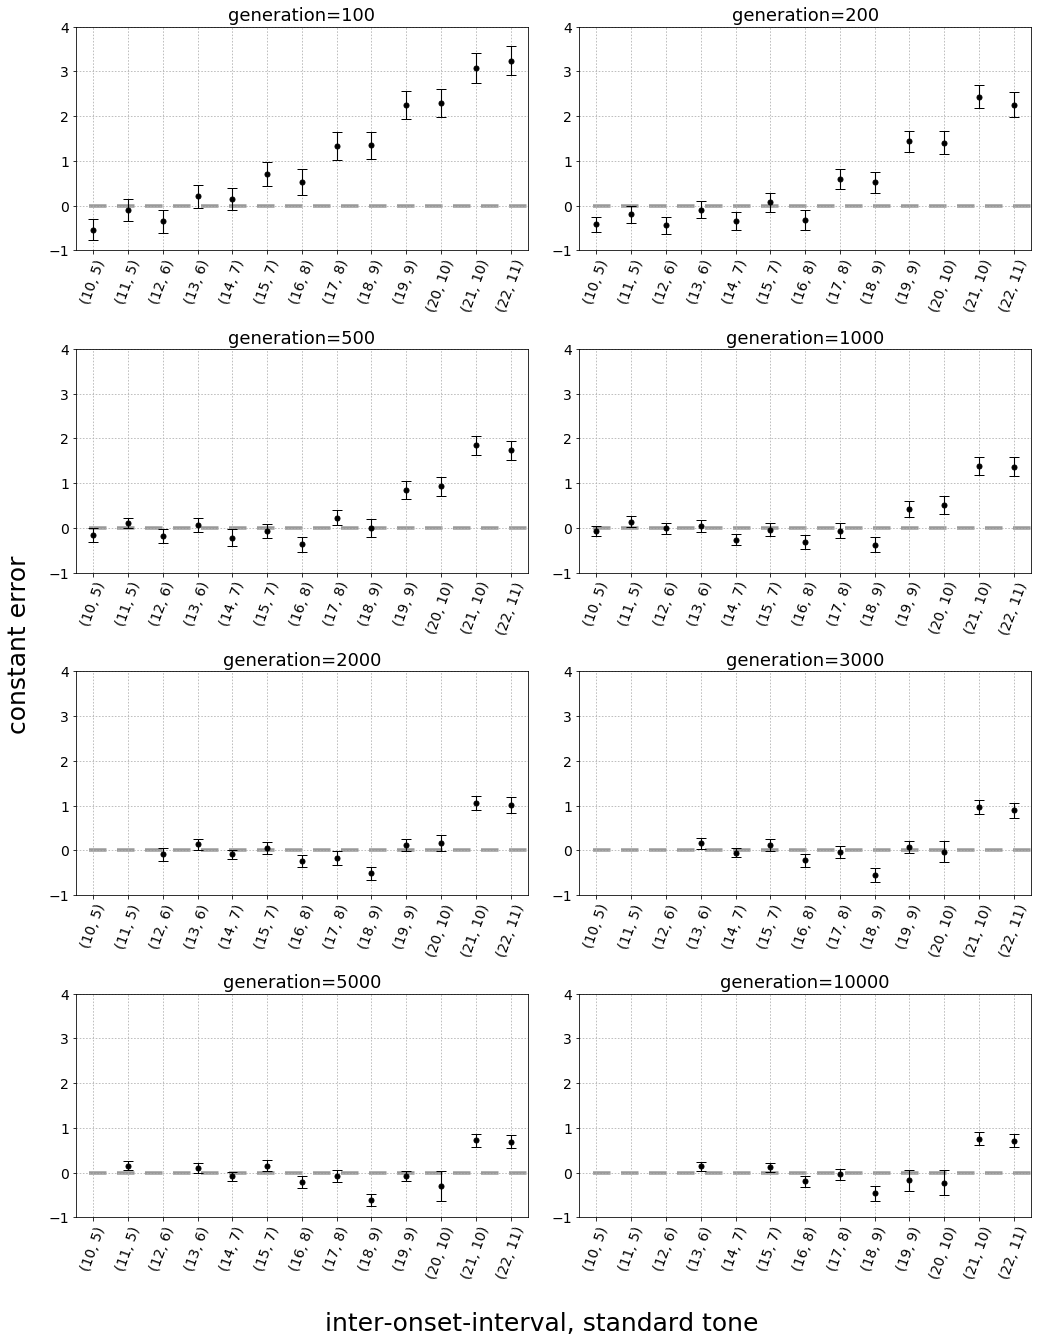

In [463]:
ad = "longer-shorter/35-setup-same-sensor-10k/"
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsCEs(ad,gens,"longer-shorter/35-setup-same-sensor-10k/CEs.pdf",-1,4,range(-1,5))

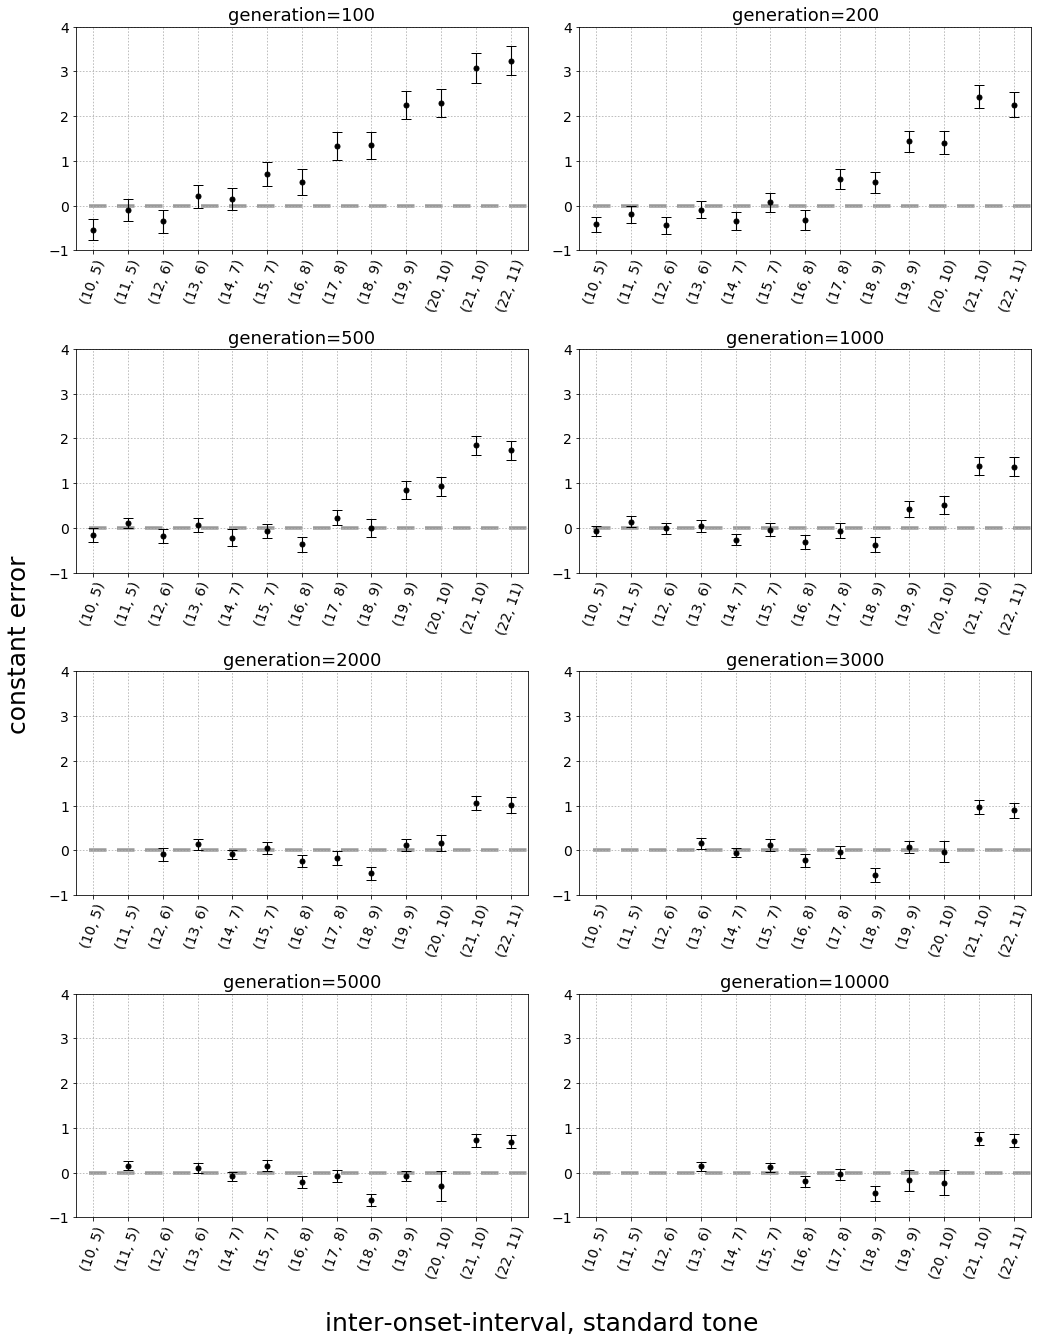

In [4]:
ad = "longer-shorter/35-setup-same-sensor-10k/"
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsCEs(ad,gens,"",-1,4,range(-1,5))

#### The reason some data points are missing in plot above is that the Markov Brains are overfit in performing the task and all 50 Brains judge 100% of oddball tones in those trials (trials with missing datapoints) so it is psychophysically trivial to generate psychometric curves (of course PSE is exatcly std tone but JND can't be calculated). Following lines show average responses of 50 Brains in those trials.

In [150]:
def subplotsCEs(ad,gens,figFn,yMin,yMax,yticks):
    psyList=list()
    for gen in gens:
        psyList.append(pd.read_csv(ad+"psy-"+str(gen)+".csv",converters={"pattern":ast.literal_eval},index_col=[0,1]))

    fig, ax = plt.subplots(4,2,figsize=(14,18))
    for ind,gen in enumerate(gens):
        psy=psyList[gens.index(gen)]
        i, j = ind//2, ind%2

        df = psy[psy.index.get_level_values('delay')==0]
        #tones = [tone for (ioi,tone) in df.index.get_level_values('pattern')]
        patterns=df.index.get_level_values('pattern').tolist()
        xs=range(len(patterns))
        CEs=df.CE.tolist()
        pseErr=[e*2 for e in df.PseStd.tolist()]
        
        ## correct missing datapoints
        redCEs=np.array([0 if str(ce)=='nan' else None for ce in CEs]).astype(np.double)
        ax[i,j].errorbar(xs,redCEs,yerr=[0]*len(xs),fmt='^',markersize=8,color='red')

        ax[i,j].errorbar(xs, CEs, yerr=pseErr, fmt='o', color='k', markersize=5, capsize=5, elinewidth=1.1)
        ax[i,j].axhline(y=0,xmin=0.03,xmax=1.0,linestyle='--',color='0.6',dashes=(5,3),linewidth=3.5,zorder=-1)
        ax[i,j].grid(True,which='both',linestyle='--',dashes=(2,2))
        
        ax[i,j].set_xlim(-0.5, len(xs)-0.5)
        ax[i,j].set_ylim(yMin,yMax)

        ax[i,j].tick_params(axis='both', labelsize=14)
        ax[i,j].tick_params(axis='x', rotation=70)
        ax[i,j].set_xticks(xs)
        ax[i,j].set_xticklabels([str(p) for p in patterns])
        ax[i,j].set_yticks(yticks)
        
        #ax.set_yticks(fontsize=15)
        ax[i,j].set_title("generation="+str(gen),fontsize=18)

    fig.text(-0.03,0.5,"constant error",rotation=90,fontsize=25,va='center')
    fig.text(0.5,-0.03,"inter-onset-interval, standard tone",fontsize=25,ha='center')

    fig.tight_layout(w_pad=2,h_pad=1.5)
    fig.savefig(figFn)

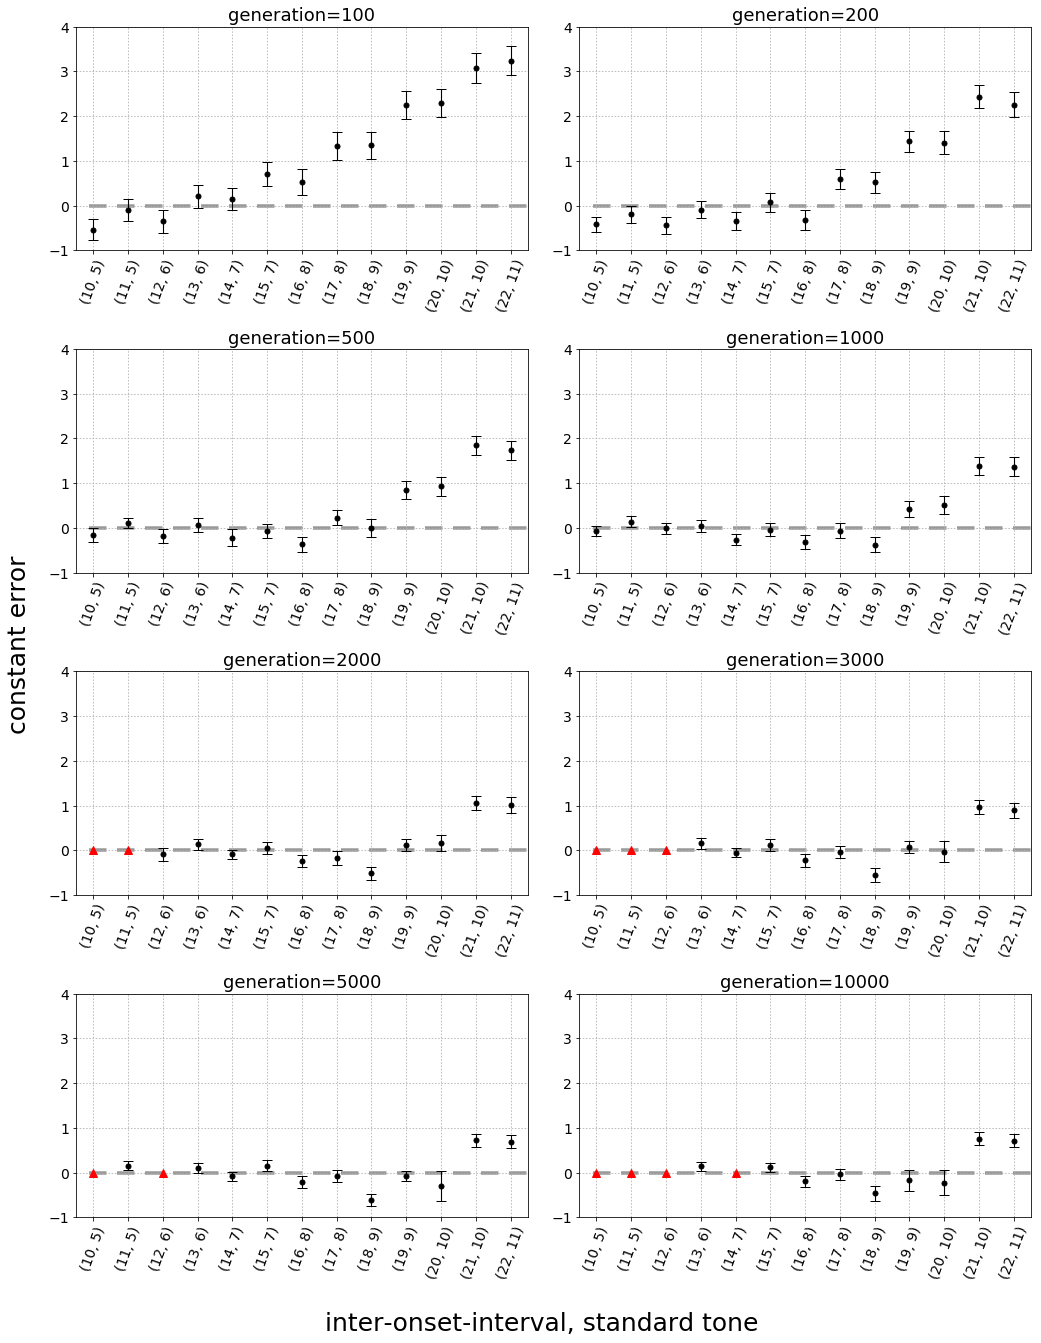

In [152]:
ad = "longer-shorter/35-setup-same-sensor-10k/"
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsCEs(ad,gens,"longer-shorter/35-setup-same-sensor-10k/CEs-fill-missing-datapoints.pdf",-1,4,range(-1,5))

In [76]:
ad = "longer-shorter/35-setup-same-sensor-10k/"
psy35_10000=pd.read_csv(ad+"psy-10000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy35_10000[psy35_10000.isin([np.nan]).any(1)]

PSE  PseStd  JND  JndStd  PseJndCov  relJND  DDF  CE
pattern  delay                                                      
(10, 5)   0     NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(11, 5)   0     NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(12, 6)   0     NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(14, 7)   0     NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(17, 8)   6     NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(18, 9)   7     NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(22, 11) -10    NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN

In [77]:
psy35_5000=pd.read_csv(ad+"psy-5000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy35_5000[psy35_5000.isin([np.nan]).any(1)]

PSE  PseStd  JND  JndStd  PseJndCov  relJND  DDF  CE
pattern delay                                                      
(10, 5) 0      NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(12, 6) 0      NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN

In [78]:
psy35_3000=pd.read_csv(ad+"psy-3000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy35_3000[psy35_3000.isin([np.nan]).any(1)]

PSE  PseStd  JND  JndStd  PseJndCov  relJND  DDF  CE
pattern delay                                                      
(10, 5) 0      NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(11, 5) 0      NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(12, 6) 0      NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN

In [79]:
psy35_2000=pd.read_csv(ad+"psy-2000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy35_2000[psy35_2000.isin([np.nan]).any(1)]

PSE  PseStd  JND  JndStd  PseJndCov  relJND  DDF  CE
pattern delay                                                      
(10, 5) 0      NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN
(11, 5) 0      NaN     NaN  NaN     NaN        NaN     NaN  NaN NaN

In [97]:
ad = "longer-shorter/34-setup-same-sensor-10k/"
psy34_10000=pd.read_csv(ad+"psy-10000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy34_10000[psy34_10000.isin([np.nan]).any(1)]

Empty DataFrame
Columns: [PSE, PseStd, JND, JndStd, PseJndCov, relJND, DDF, CE]
Index: []

In [98]:
ad = "longer-shorter/34-setup-same-sensor-10k/"
psy34_5000=pd.read_csv(ad+"psy-5000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy34_5000[psy34_5000.isin([np.nan]).any(1)]

Empty DataFrame
Columns: [PSE, PseStd, JND, JndStd, PseJndCov, relJND, DDF, CE]
Index: []

In [99]:
ad = "longer-shorter/34-setup-same-sensor-10k/"
psy34_3000=pd.read_csv(ad+"psy-3000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy34_3000[psy34_3000.isin([np.nan]).any(1)]

Empty DataFrame
Columns: [PSE, PseStd, JND, JndStd, PseJndCov, relJND, DDF, CE]
Index: []

In [100]:
ad = "longer-shorter/34-setup-same-sensor-10k/"
psy34_2000=pd.read_csv(ad+"psy-2000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
psy34_2000[psy34_2000.isin([np.nan]).any(1)]

Empty DataFrame
Columns: [PSE, PseStd, JND, JndStd, PseJndCov, relJND, DDF, CE]
Index: []

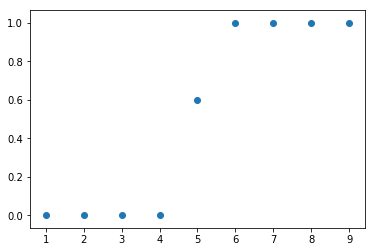

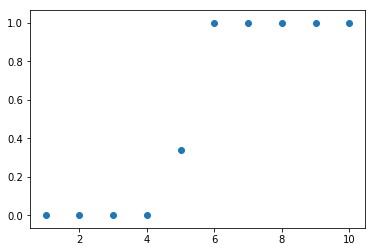

In [9]:
ad = "longer-shorter/35-setup-same-sensor-10k/"
fn=ad+"res-2000.csv"
res35_2000=readResponseFile(fn)
psy35_2000=pd.read_csv(ad+"psy-2000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
for (pat,delay) in [((10,5),0),((11,5),0)]:#[(10,5), (11,5), (12,6), (14,7)]:
    plotResponseCurve(res35_2000, psy35_2000, pat, delay)
    #print (np.mean(res35_10000[res35_10000.index.get_level_values('delay')==0].loc[ioi,tone].response.tolist(),axis=0))

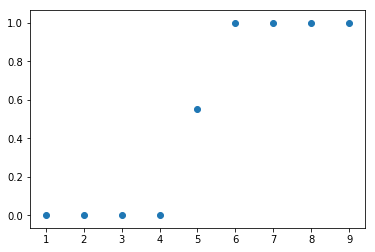

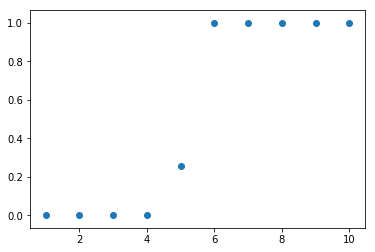

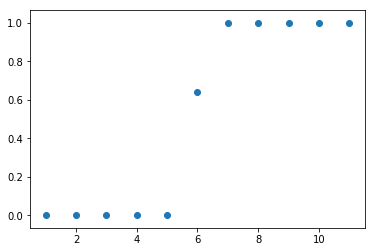

In [11]:
ad = "longer-shorter/35-setup-same-sensor-10k/"
fn=ad+"res-3000.csv"
res35_3000=readResponseFile(fn)
psy35_3000=pd.read_csv(ad+"psy-3000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
for (pat,delay) in [((10,5),0),((11,5),0),((12,6),0)]:#[(10,5), (11,5), (12,6), (14,7)]:
    plotResponseCurve(res35_3000, psy35_3000, pat, delay)

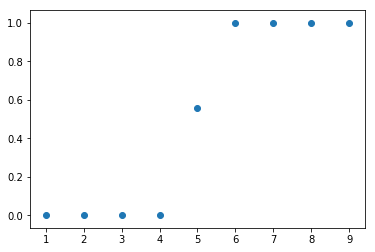

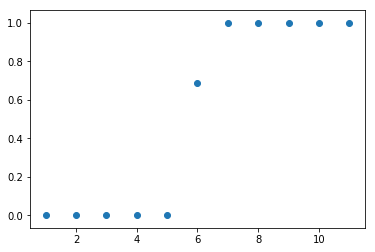

In [12]:
ad = "longer-shorter/35-setup-same-sensor-10k/"
fn=ad+"res-5000.csv"
res35_5000=readResponseFile(fn)
psy35_5000=pd.read_csv(ad+"psy-5000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
for (pat,delay) in [((10,5),0),((12,6),0)]:#[(10,5), (11,5), (12,6), (14,7)]:
    plotResponseCurve(res35_5000, psy35_5000, pat, delay)

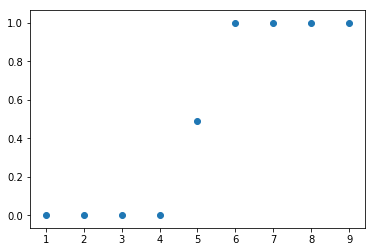

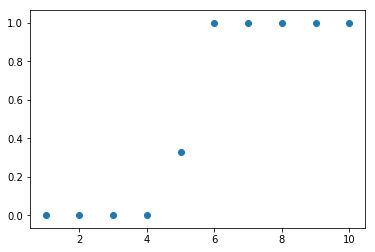

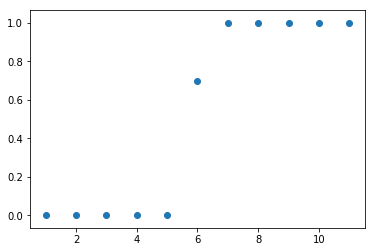

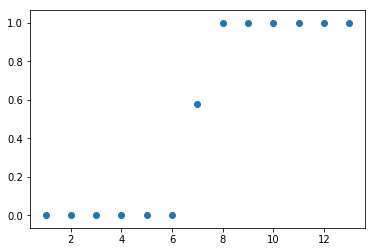

In [14]:
ad = "longer-shorter/35-setup-same-sensor-10k/"
fn=ad+"res-10000.csv"
res35_10000=readResponseFile(fn)
psy35_10000=pd.read_csv(ad+"psy-10000.csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
for (pat,delay) in [((10,5),0),((11,5),0),((12,6),0),((14,7),0)]:
    plotResponseCurve(res35_10000, psy35_10000, pat, delay)

In [262]:
fn=ad+"res-5000.csv"
res35_5000=readResponseFile(fn)
for (ioi,tone) in [((10,5),0),((11,5),0)]:
    print (np.mean(res35_3000[res35_5000.index.get_level_values('delay')==0].loc[ioi,tone].response.tolist(),axis=0))

[0.   0.   0.   0.   0.56 1.   1.   1.   1.  ]
[0.   0.   0.   0.   0.   0.69 1.   1.   1.   1.   1.  ]


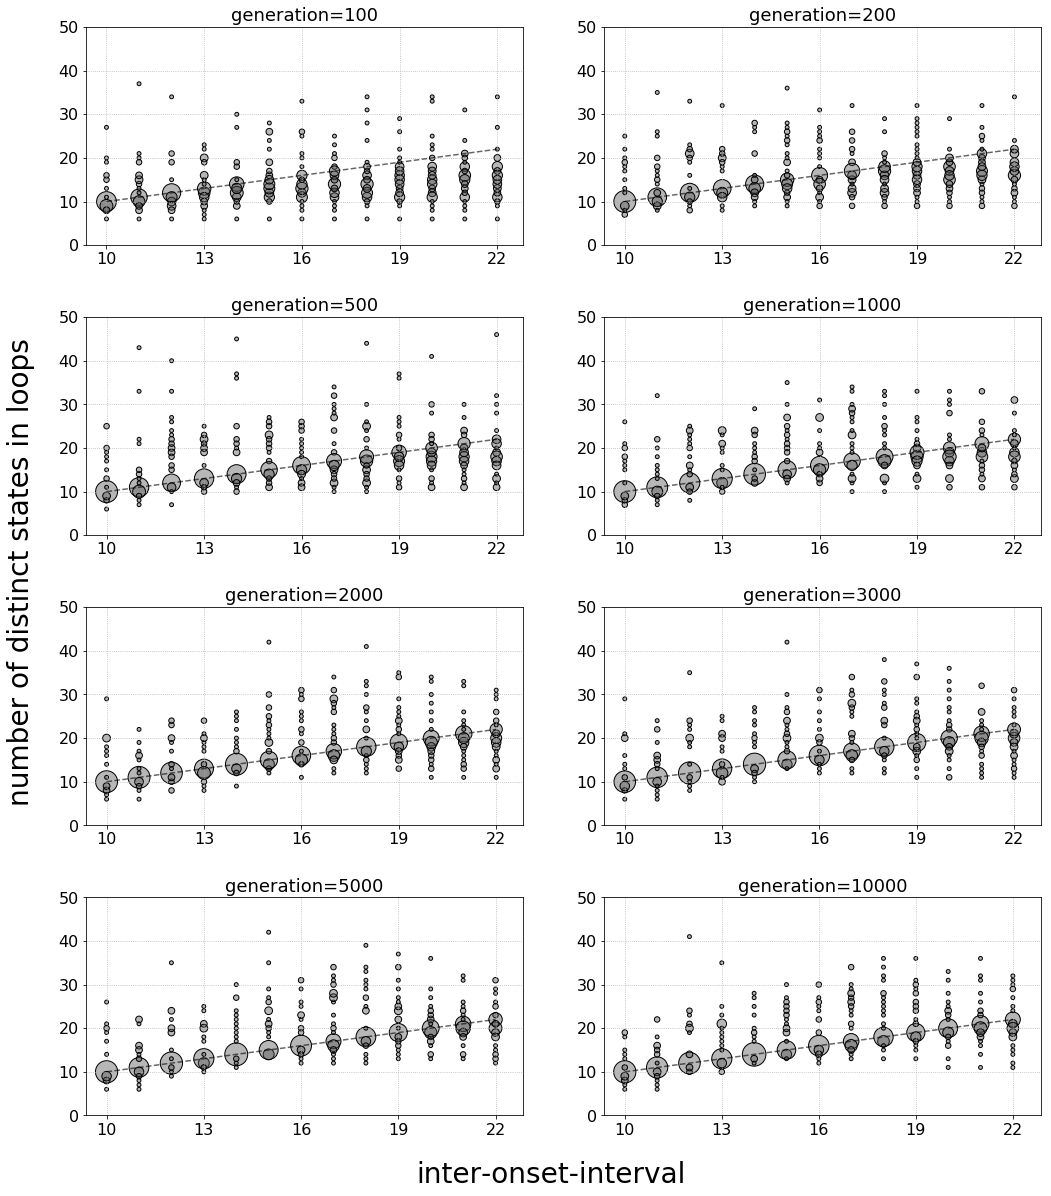

In [51]:
iois=list(range(10,23))
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsScatters("longer-shorter/35-setup-same-sensor-10k/", gens, iois, 'entrainPerTrial', 0, 50, 3, 
                 "longer-shorter/35-setup-same-sensor-10k/state-spaces-35-gens.pdf")

LinregressResult(slope=2.3500068567809356, intercept=-0.9862322468699567, rvalue=0.7127328407722119, pvalue=1.1188608432261035e-15, stderr=0.2424428972922005)
LinregressResult(slope=2.598912573764162, intercept=-0.5403133335610357, rvalue=0.6100632911926956, pvalue=8.509071270458456e-11, stderr=0.35384626503344196)
LinregressResult(slope=3.4430869343537163, intercept=-0.9296817645478885, rvalue=0.6739926654725544, pvalue=1.3175272935418461e-13, stderr=0.39560573840761165)


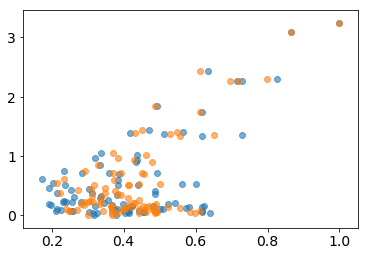

In [562]:
ad="longer-shorter/35-setup-same-sensor-10k/"
iois=range(10,23)
gens=[100,200,500,1000,2000,3000,5000,10000]

df35=readDistributions(ad,gens,iois)
df35=df35.dropna()
#plt.scatter(df35.L0,df35.absCE,alpha=0.6)
plt.scatter(df35.L1,df35.absCE,alpha=0.6)
plt.scatter(df35.L2,df35.absCE,alpha=0.6)
print (stats.linregress( df35.L0.tolist(), df35.absCE.tolist()) )
print (stats.linregress( df35.L1.tolist(), df35.absCE.tolist()) )
print (stats.linregress( df35.L2.tolist(), df35.absCE.tolist()) )

quad         RSS: 2.91 	r2: 0.78 	BIC: -76.33
ramp         RSS: 1.48 	r2: 0.89 	BIC: -99.97
softplus     RSS: 0.98 	r2: 0.93 	BIC: -114.51


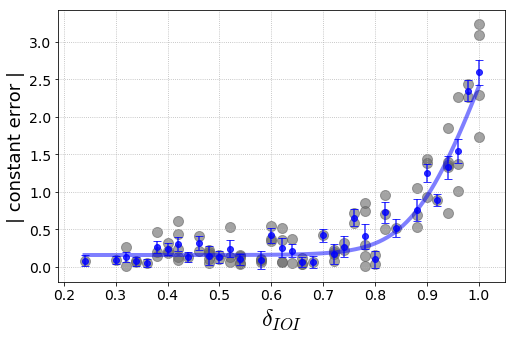

In [580]:
df35Mean=bin_and_plot(df35)
popt,pcov,res,rSq,RSS = fit_plot(df35Mean, softplus)

functions=[quad, ramp, softplus]
compare_models(df35Mean, functions)
plt.savefig("longer-shorter/35-setup-same-sensor-10k/CE-delta-35.pdf",bbox_inches='tight')

## 36-setup

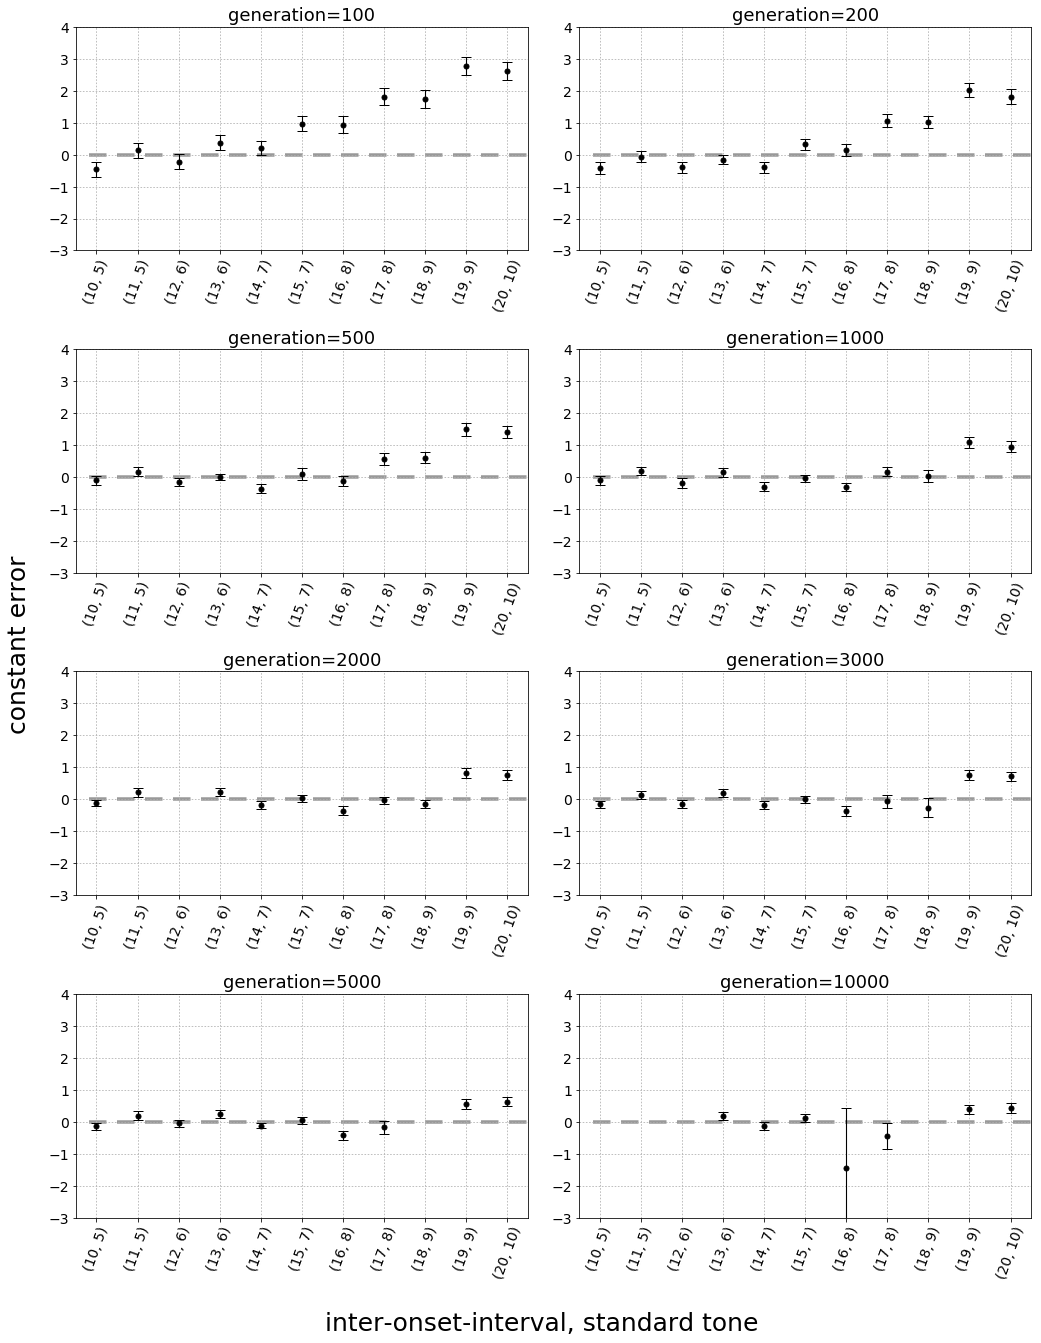

In [86]:
ad = "longer-shorter/36-setup-same-sensor-10k/"
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsCEs(ad,gens,"",-3,4,range(-3,5))

In [323]:
fn=ad+"res-10000.csv"
res36_10000=readResponseFile(fn)

#for (ioi,tone) in [(10,5), (11,5), (12,6), (14,7)]:
ioi,tone=16,8
print (np.mean(res36_10000[res36_10000.index.get_level_values('delay')==0].loc[ioi,tone].response.tolist(),axis=0))
print (np.std(res36_10000[res36_10000.index.get_level_values('delay')==0].loc[ioi,tone].response.tolist(),axis=0))

[0.   0.   0.   0.   0.   0.   0.   0.89 0.98 0.98 1.   1.   1.   1.
 1.  ]
[0.   0.   0.   0.   0.   0.   0.   0.27 0.14 0.14 0.   0.   0.   0.
 0.  ]


pattern: (16, 8) 	delay: 0 

psychometric curve for current values:


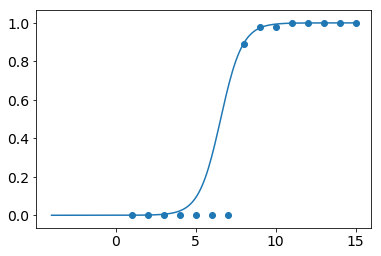

In [324]:
inq=[((16,8),0)]
psy36_10000 = pd.read_csv(ad+"psy-"+str(10000)+".csv",converters={"pattern":ast.literal_eval},index_col=[0,1])
for (pat,delay) in inq:
    print ("pattern:",pat,"\tdelay:",delay,'\n')
    print ("psychometric curve for current values:")
    plotResponseCurve(res36_10000, psy36_10000, pat, delay)

## 37-setup

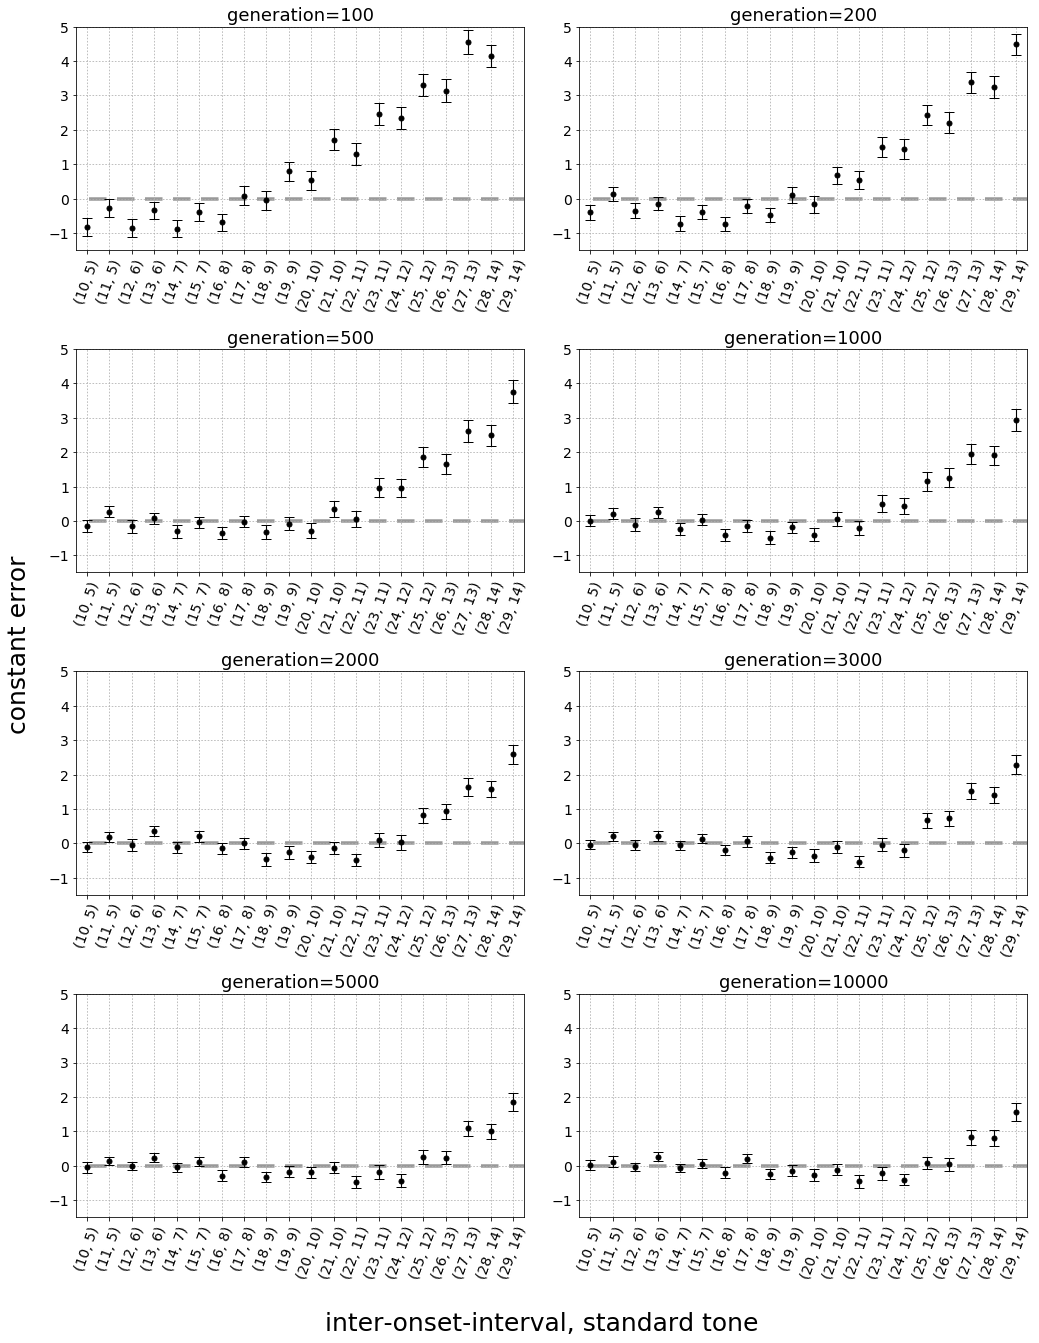

In [464]:
ad = "longer-shorter/37-setup-same-sensor-10k/"
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsCEs(ad,gens,"longer-shorter/37-setup-same-sensor-10k/CEs.pdf",-1.5,5,range(-1,6))

In [411]:
from collections import Counter

def subplotsScatters(ad, gens, iois, col, yMin, yMax, xtickSteps, figFn=""):
    fig, ax = plt.subplots(4,2,figsize=(14,16))
    for ind,gen in enumerate(gens):
        df=readStats(ad+"stats-"+str(gen)+".csv", col, iois)
        for ioi in df.index:
            l = df['count'].loc[ioi]
            d = dict(Counter(l))
            loopSz, cnt = [int(k) for k in list(d.keys())], [int(v) for v in list(d.values())]
            xs = [int(ioi)]*(len(d))
            c=np.arange(len(iois))
            i,j=ind//2,ind%2
            ax[i,j].scatter(xs, loopSz, s=[c*15 for c in cnt], edgecolor=(0,0,0,1.0), color=(0.3,0.3,0.3,0.4))
        ax[i,j].plot(iois,iois,'--',color='k',alpha=0.6,markersize=0)
        ax[i,j].set_xticks(range(iois[0],iois[-1]+2,5))#range(iois[0], iois[-1]+1, xtickStep))
            #ax[i,j].set_yticks(fontsize=18)
        ax[i,j].set_ylim(yMin,yMax)
        ax[i,j].tick_params(axis='both', labelsize=16)
        ax[i,j].grid(which='both',linestyle=':')
        ax[i,j].set_title("generation="+str(gen),fontsize=18)
    
    fig.text(-0.04,0.5,"number of distinct states in loops",rotation=90,fontsize=28,va='center')
    fig.text(0.5,-0.03,"inter-onset-interval",fontsize=28,ha='center')

    
    fig.tight_layout(w_pad=5,h_pad=3)  
    fig.savefig(figFn, bbox_inches='tight')

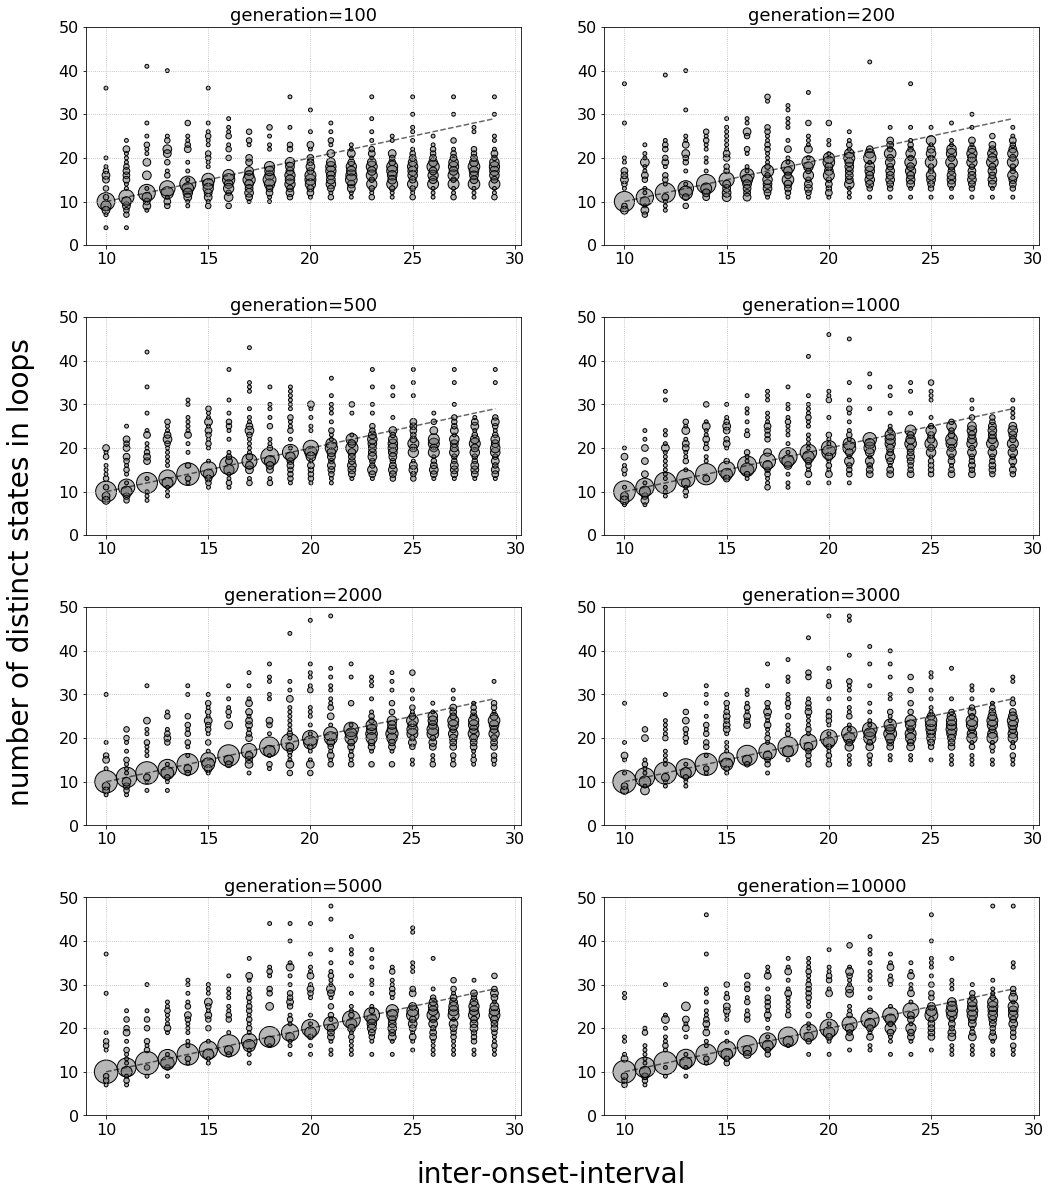

In [412]:
iois=list(range(10,30))
gens=[100,200,500,1000,2000,3000,5000,10000]
subplotsScatters("longer-shorter/37-setup-same-sensor-10k/", gens, iois, 'entrainPerTrial', 0, 50, 5, 
                 "longer-shorter/37-setup-same-sensor-10k/state-spaces-gens.pdf")

LinregressResult(slope=2.9713316862579076, intercept=-1.359852679481683, rvalue=0.6327862708833852, pvalue=2.7970765421517563e-19, stderr=0.28926085646627187)
LinregressResult(slope=4.48222873437095, intercept=-1.5460658307121289, rvalue=0.6372703821864298, pvalue=1.3070355683619253e-19, stderr=0.4312145925888223)
LinregressResult(slope=6.148096870821597, intercept=-2.1635330552141827, rvalue=0.7874780986261748, pvalue=4.965326744246842e-35, stderr=0.38282111622611953)


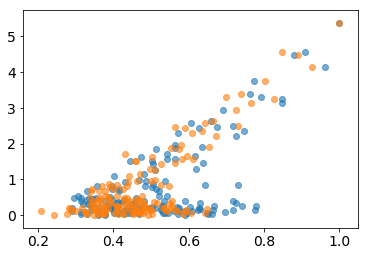

In [566]:
ad="longer-shorter/37-setup-same-sensor-10k/"
iois=range(10,30)
gens=[100,200,500,1000,2000,3000,5000,10000]

df37=readDistributions(ad,gens,iois)
#plt.scatter(df37.L0,df37.absCE,alpha=0.6)
plt.scatter(df37.L1,df37.absCE,alpha=0.6)
plt.scatter(df37.L2,df37.absCE,alpha=0.6)
print (stats.linregress( df37.L0.tolist(),df37.absCE.tolist()) )
print (stats.linregress( df37.L1.tolist(),df37.absCE.tolist()) )
print (stats.linregress( df37.L2.tolist(),df37.absCE.tolist()) )

quad         RSS: 7.03 	r2: 0.48 	BIC: -53.2
ramp         RSS: 1.03 	r2: 0.92 	BIC: -126.34
softplus     RSS: 0.89 	r2: 0.93 	BIC: -131.92


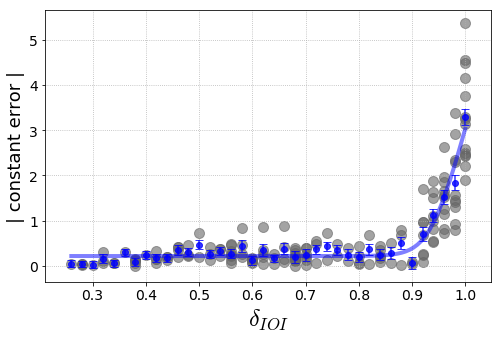

In [581]:
df37Mean=bin_and_plot(df37)
popt,pcov,res,rSq,RSS = fit_plot(df37Mean, softplus)

functions=[quad, ramp, softplus]
compare_models(df37Mean, functions)
plt.savefig("longer-shorter/37-setup-same-sensor-10k/CE-delta-37.pdf",bbox_inches='tight')